#### This notebook is consist of following regarding the Data Science Take Home Project from aifora

- data exploration & preparation
- Time series analysis
- feature engineering and feature analysis
- implementation of machine learning model to forecast the sales
- model evaluation & inference
- A breif analysis and iimplementation of price elasticity method

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sktime
import pickle
import gc
import os
import sys
from sklearn.utils import shuffle 
import warnings
from collections import defaultdict
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
from fastai.tabular.core import add_datepart
from sklearn import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, ParameterGrid,
                                     ParameterSampler, RandomizedSearchCV,
                                     StratifiedKFold, StratifiedShuffleSplit,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.utils import resample
from datetime import datetime, timedelta
from sktime.forecasting.arima import ARIMA,AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.var import VAR
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.fbprophet import Prophet
from datetime import datetime, timedelta
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction,MultioutputTimeSeriesRegressionForecaster,DirectTabularRegressionForecaster,MultioutputTabularRegressionForecaster
from sklearn.linear_model import LinearRegression
from sktime.forecasting.model_selection import temporal_train_test_split, SingleWindowSplitter,SlidingWindowSplitter
from statsmodels.tsa.stattools import adfuller
from termcolor import colored
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, ClassifierMixin
from pandas_profiling import ProfileReport
import holidays

## Data exploration & preparation

In [2]:
train = pd.read_csv('../data/transaction_grid.csv')
print(train.shape)
display(train.head())

#no of style_color_group for each level3
display(train[['level4','level3']].groupby(['level3']).agg(['nunique','unique']).reset_index())

#no of style_color_group for each level3
display(train[['style_color_group','level3']].groupby(['level3']).agg(['nunique','unique']).reset_index())

#no of style_group for each level3
display(train[['style_group','level3']].groupby(['level3']).agg(['nunique','unique']).reset_index())

#no of style_color_group for each level3 & level4 combination
display(train[['style_color_group','level3','level4']].groupby(['level3','level4']).agg(['nunique','unique']).reset_index())

#no of style_group for each level3 & level4 combination
display(train[['style_group','level3','level4']].groupby(['level3','level4']).agg(['nunique','unique']).reset_index())


(12053, 19)


article_id  \
0  7c478b2a19cf829fce778dfa644478b8639e355276588710514dfdb12ffad0f8   
1  7c478b2a19cf829fce778dfa644478b8639e355276588710514dfdb12ffad0f8   
2  7c478b2a19cf829fce778dfa644478b8639e355276588710514dfdb12ffad0f8   
3  7c478b2a19cf829fce778dfa644478b8639e355276588710514dfdb12ffad0f8   
4  7c478b2a19cf829fce778dfa644478b8639e355276588710514dfdb12ffad0f8   

                                                  style_color_group  \
0  8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033   
1  8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033   
2  8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033   
3  8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033   
4  8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033   

                                                        style_group  \
0  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   
1  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   
2  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   
3  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   
4  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   

        level1 level2    level3         level4 sales_channel transaction_date  \
0  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-01   
1  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-02   
2  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-03   
3  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-04   
4  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-05   

   units_sold  original_price  sales_price  final_price  is_promotion  \
0          10           15.99        15.99        15.99             0   
1          10           15.99        15.99        15.92             0   
2           5           15.99        15.99        15.91             0   
3          20           15.99        15.99        15.85             0   
4           7           15.99        15.99        15.94             0   

   month_of_launch season_start_date season_end_date  current_season  \
0                7        2022-06-01      2023-07-14          202402   
1                7        2022-06-01      2023-07-14          202402   
2                7        2022-06-01      2023-07-14          202402   
3                7        2022-06-01      2023-07-14          202402   
4                7        2022-06-01      2023-07-14          202402   

   initial_season  
0          202207  
1          202207  
2          202207  
3          202207  
4          202207

level3  level4                               
            nunique                         unique
0  T-shirts       2  [short-sleeved, long-sleeved]
1  Trousers       2                  [long, short]

level3 style_color_group  \
                      nunique   
0  T-shirts                12   
1  Trousers                10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    unique  
0  [8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033, 8b0fd2c2f458875eff0e99468a5788dedb1f1c16529e4927c67bd22c7e3cf075, 5fa86132888bac6de18d11e46f7e8753048df007dfe0ea9830951b27c78314da, 35361b53afeb02543624d5305ae5c2a48de774b989b73f563434a5e38903d5ee, 60c1ef44757d9534741d2f46b4c9113d2f948f98128e5e7b18f2dfae446303cb, f6f738b272611d30ce957b347a2392bea3324488d71a0b0d3300051d81fd43fe, f4f668668edd7ce475dc21961b683120f25d0e9be0f963b35d48a0743b3a8dc6, 1d22a5563d8ee415aedb726dcaa9cf82ef471f9ae109f2bfe474a8040ee5d952, bd407446febda01d13d058af242faf2f0413839066b7377cb13db5ce00feeb9f, b...  
1  [87d85321d82e8f4fa5da85797da9281aea9c179aab7e1cf223a363b21f513ccb, 0e79d6d157640befbac3ef28ac6e6350792066f9a7ee2f32c74ca7a92786da01, 09b4f9f85573d3e7be7ebd0d35e49a43b441c211ce5a1300c5f45d61fed46020, a070945c410299bf0b34e77fc0189bea1b1da3eecab7c336e1e84df7bdd456c6, 640119d9674c918322552ddc3610d0f22feb8e3ac8cc1b1160d3c89d5742f4e7, 117b8ba74587b581e8aefbf0e97fb2bfa651a9e25a3b5071c9d91783348c6c42, 75192b36dde88f1a599772629c67c4a8ce79370145794d7c7d8d57bc7f159fa1, 181fafea23a284066d1fedf2bf13d1253576d4a019f64c03cf05393e9f80afee, eab3d3e5c6c27eadfbbe3b624f15eff0bd62e0fb6cde3e8226900d87d64136ea, 0...

level3 style_group  \
                nunique   
0  T-shirts           4   
1  Trousers           4   

                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                     unique  
0  [ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f, f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5, aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f, ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0]  
1  [f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4, e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac, 2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5, ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37]

level3         level4 style_color_group  \
                                     nunique   
0  T-shirts   long-sleeved                 4   
1  T-shirts  short-sleeved                 8   
2  Trousers           long                 6   
3  Trousers          short                 4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             unique  
0                                                                                                                                                                                                                                                                          [35361b53afeb02543624d5305ae5c2a48de774b989b73f563434a5e38903d5ee, 60c1ef44757d9534741d2f46b4c9113d2f948f98128e5e7b18f2dfae446303cb, bd407446febda01d13d058af242faf2f0413839066b7377cb13db5ce00feeb9f, b2d8d4d70d4d0ec405bd948a65c063a199497b6a18b3553b65e515a8745d6737]  
1  [8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033, 8b0fd2c2f458875eff0e99468a5788dedb1f1c16529e4927c67bd22c7e3cf075, 5fa86132888bac6de18d11e46f7e8753048df007dfe0ea9830951b27c78314da, f6f738b272611d30ce957b347a2392bea3324488d71a0b0d3300051d81fd43fe, f4f668668edd7ce475dc21961b683120f25d0e9be0f963b35d48a0743b3a8dc6, 1d22a5563d8ee415aedb726dcaa9cf82ef471f9ae109f2bfe474a8040ee5d952, a829ce60a503dd866504a4e0138afae761cd2598f0e05e80a384692f62f87606, 05f1ca17f48654285610d58dbf50f3d06b1a76ef027a1c3a4a7690948a27c1f5]  
2                                                                                                                                      [87d85321d82e8f4fa5da85797da9281aea9c179aab7e1cf223a363b21f513ccb, 0e79d6d157640befbac3ef28ac6e6350792066f9a7ee2f32c74ca7a92786da01, 09b4f9f85573d3e7be7ebd0d35e49a43b441c211ce5a1300c5f45d61fed46020, a070945c410299bf0b34e77fc0189bea1b1da3eecab7c336e1e84df7bdd456c6, 640119d9674c918322552ddc3610d0f22feb8e3ac8cc1b1160d3c89d5742f4e7, 07b1e066f6050b4d362792d69011f9ed24c700163571824adc8af8c884075ffa]  
3                                                                                                                                                                                                                                                                          [117b8ba74587b581e8aefbf0e97fb2bfa651a9e25a3b5071c9d91783348c6c42, 75192b36dde88f1a599772629c67c4a8ce79370145794d7c7d8d57bc7f159fa1, 181fafea23a284066d1fedf2bf13d1253576d4a019f64c03cf05393e9f80afee, eab3d3e5c6c27eadfbbe3b624f15eff0bd62e0fb6cde3e8226900d87d64136ea]

level3         level4 style_group  \
                               nunique   
0  T-shirts   long-sleeved           2   
1  T-shirts  short-sleeved           2   
2  Trousers           long           2   
3  Trousers          short           2   

                                                                                                                                         
                                                                                                                                 unique  
0  [aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f, ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0]  
1  [ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f, f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5]  
2  [f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4, e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac]  
3  [2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5, ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37]

In [3]:
#count of each style_color_group in the dataset 
train['transaction_date'] = pd.to_datetime(train['transaction_date'])
display(train[['style_color_group','transaction_date']].groupby(['style_color_group']).agg(['count','min','max']).reset_index())

#count of each style_group in the dataset 
train['transaction_date'] = pd.to_datetime(train['transaction_date'])
train[['style_group','transaction_date']].groupby(['style_group']).agg(['count','min','max']).reset_index()

style_color_group  \
                                                                       
0   05f1ca17f48654285610d58dbf50f3d06b1a76ef027a1c3a4a7690948a27c1f5   
1   07b1e066f6050b4d362792d69011f9ed24c700163571824adc8af8c884075ffa   
2   09b4f9f85573d3e7be7ebd0d35e49a43b441c211ce5a1300c5f45d61fed46020   
3   0e79d6d157640befbac3ef28ac6e6350792066f9a7ee2f32c74ca7a92786da01   
4   117b8ba74587b581e8aefbf0e97fb2bfa651a9e25a3b5071c9d91783348c6c42   
5   181fafea23a284066d1fedf2bf13d1253576d4a019f64c03cf05393e9f80afee   
6   1d22a5563d8ee415aedb726dcaa9cf82ef471f9ae109f2bfe474a8040ee5d952   
7   35361b53afeb02543624d5305ae5c2a48de774b989b73f563434a5e38903d5ee   
8   5fa86132888bac6de18d11e46f7e8753048df007dfe0ea9830951b27c78314da   
9   60c1ef44757d9534741d2f46b4c9113d2f948f98128e5e7b18f2dfae446303cb   
10  640119d9674c918322552ddc3610d0f22feb8e3ac8cc1b1160d3c89d5742f4e7   
11  75192b36dde88f1a599772629c67c4a8ce79370145794d7c7d8d57bc7f159fa1   
12  87d85321d82e8f4fa5da85797da9281aea9c179aab7e1cf223a363b21f513ccb   
13  8975b6409175f438d071392c28591bd0f79cb88cb72b20eee6f9e65b39812033   
14  8b0fd2c2f458875eff0e99468a5788dedb1f1c16529e4927c67bd22c7e3cf075   
15  a070945c410299bf0b34e77fc0189bea1b1da3eecab7c336e1e84df7bdd456c6   
16  a829ce60a503dd866504a4e0138afae761cd2598f0e05e80a384692f62f87606   
17  b2d8d4d70d4d0ec405bd948a65c063a199497b6a18b3553b65e515a8745d6737   
18  bd407446febda01d13d058af242faf2f0413839066b7377cb13db5ce00feeb9f   
19  eab3d3e5c6c27eadfbbe3b624f15eff0bd62e0fb6cde3e8226900d87d64136ea   
20  f4f668668edd7ce475dc21961b683120f25d0e9be0f963b35d48a0743b3a8dc6   
21  f6f738b272611d30ce957b347a2392bea3324488d71a0b0d3300051d81fd43fe   

   transaction_date                        
              count        min        max  
0               556 2022-01-22 2023-07-31  
1               552 2022-01-26 2023-07-31  
2               577 2022-01-01 2023-07-31  
3               552 2022-01-26 2023-07-31  
4               458 2022-04-30 2023-07-31  
5               458 2022-04-30 2023-07-31  
6               577 2022-01-01 2023-07-31  
7               555 2022-01-23 2023-07-31  
8               577 2022-01-01 2023-07-31  
9               577 2022-01-01 2023-07-31  
10              577 2022-01-01 2023-07-31  
11              458 2022-04-30 2023-07-31  
12              552 2022-01-26 2023-07-31  
13              577 2022-01-01 2023-07-31  
14              577 2022-01-01 2023-07-31  
15              577 2022-01-01 2023-07-31  
16              577 2022-01-01 2023-07-31  
17              577 2022-01-01 2023-07-31  
18              536 2022-02-11 2023-07-31  
19              458 2022-04-30 2023-07-31  
20              571 2022-01-07 2023-07-31  
21              577 2022-01-01 2023-07-31

style_group  \
                                                                      
0  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   
1  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   
2  ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0   
3  ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37   
4  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   
5  e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac   
6  f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5   
7  f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4   

  transaction_date                        
             count        min        max  
0             1374 2022-04-30 2023-07-31  
1             1709 2022-01-01 2023-07-31  
2              536 2022-02-11 2023-07-31  
3              458 2022-04-30 2023-07-31  
4             2302 2022-01-01 2023-07-31  
5             1731 2022-01-01 2023-07-31  
6             2287 2022-01-01 2023-07-31  
7             1656 2022-01-26 2023-07-31

#### As the data-size is not adequate to forecast in style_color_group will forecast in style_group level 

##### - Also we do not need original_price as feature and may use either 'sales_price' or 'final_price' as price feature



#### A quick look at the data

In [38]:
pd.set_option('mode.chained_assignment', None)
selected = ['sales_channel', 'units_sold',
       'original_price', 'sales_price', 'final_price', 'is_promotion',
       'month_of_launch', 'season_start_date', 'season_end_date',
       'current_season', 'initial_season']
prof = ProfileReport(train[selected], title='Pandas Profiling Report', explorative=True)

prof.to_file(output_file='output.html')
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Fortunately there is no missing value in the data
- Naturally stong positive co-relation between units_sold and price especially with final_price & promotion
- as sales_channel has only one value, we can drop it
- As expected in real world, units_sold is left skewed with 21% of 0 sales

### Data preparation:  style_group level

In [4]:
def data_prep(train:pd.DataFrame):

    """
   style_group level Over all Data prep function for forecasting.

    Args:
        transaction Dataframe. 
    Returns:
        style_group level aggregated sales and average price.
    """

    train['transaction_date'] = pd.to_datetime(train['transaction_date'])

    df = train[['level3', 'level4','style_group','transaction_date', 'units_sold','sales_price', 'final_price', \
                                'is_promotion']].groupby(['level3', 'level4','style_group','transaction_date']).\
                                agg({'sales_price':'mean', 'final_price':'mean','is_promotion':'mean','units_sold':'sum',\
                                                                                            'final_price':'mean'}).reset_index().fillna(0)
    
    return df                                                                                   

df = data_prep(train)
display(df.head())
df.shape

level3        level4  \
0  T-shirts  long-sleeved   
1  T-shirts  long-sleeved   
2  T-shirts  long-sleeved   
3  T-shirts  long-sleeved   
4  T-shirts  long-sleeved   

                                                        style_group  \
0  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   
1  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   
2  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   
3  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   
4  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   

  transaction_date  sales_price  final_price  is_promotion  units_sold  
0       2022-01-01        35.99        35.99           0.0           7  
1       2022-01-02        35.99        35.99           0.0           7  
2       2022-01-03        35.99        35.99           0.0           8  
3       2022-01-04        35.99        35.99           0.0          13  
4       2022-01-05        35.99        35.99           0.0           9

(4312, 8)

##### Snek-peak different series

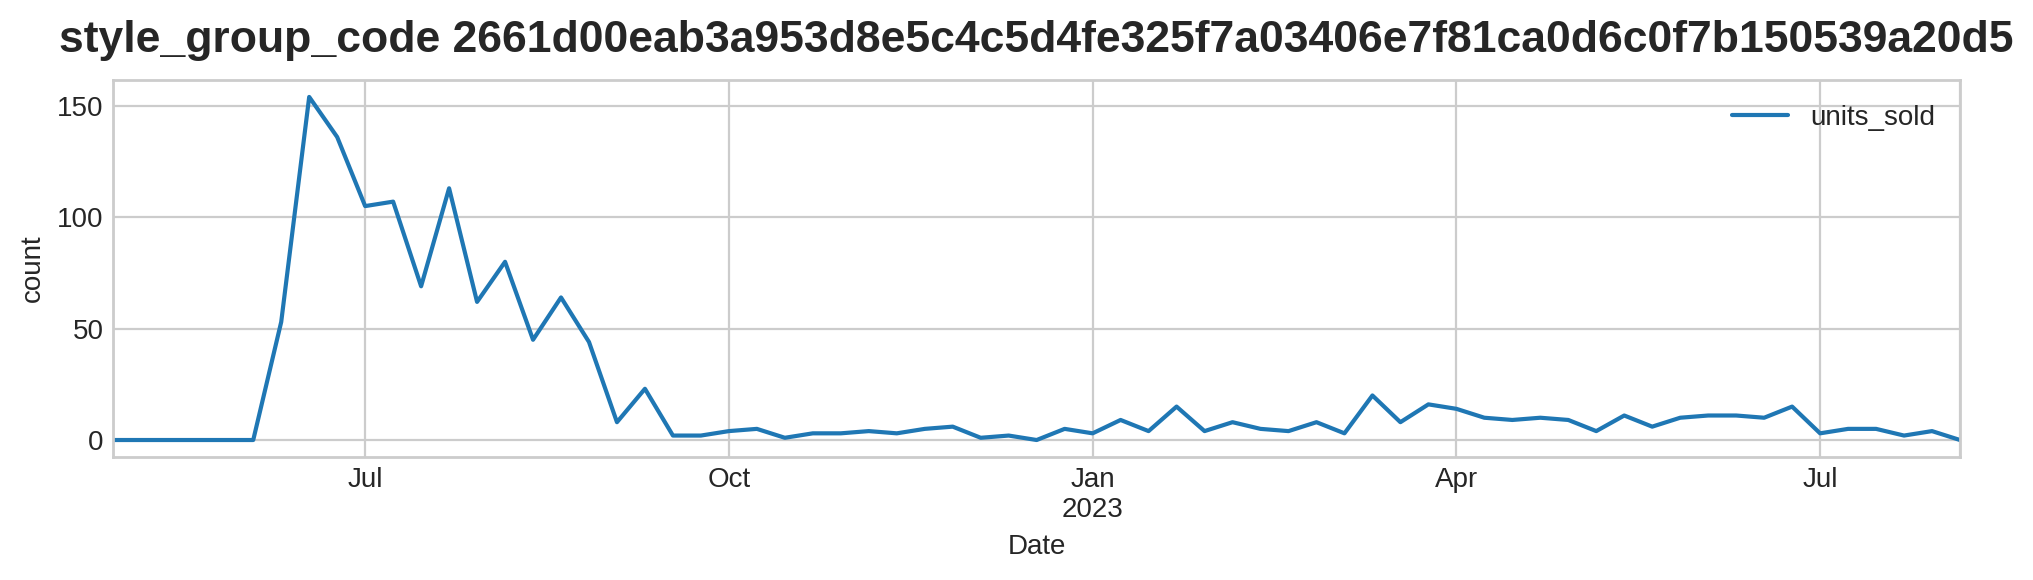

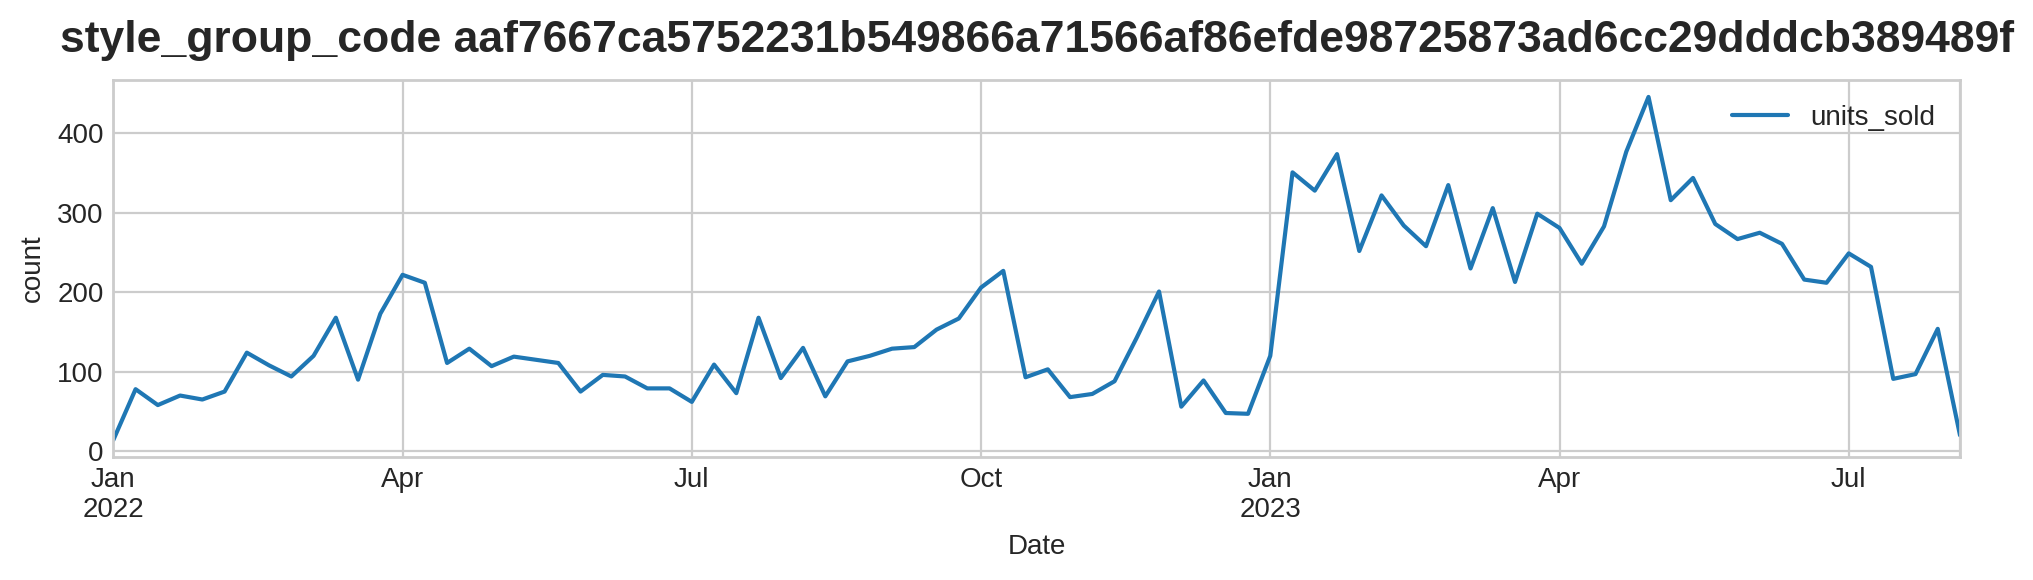

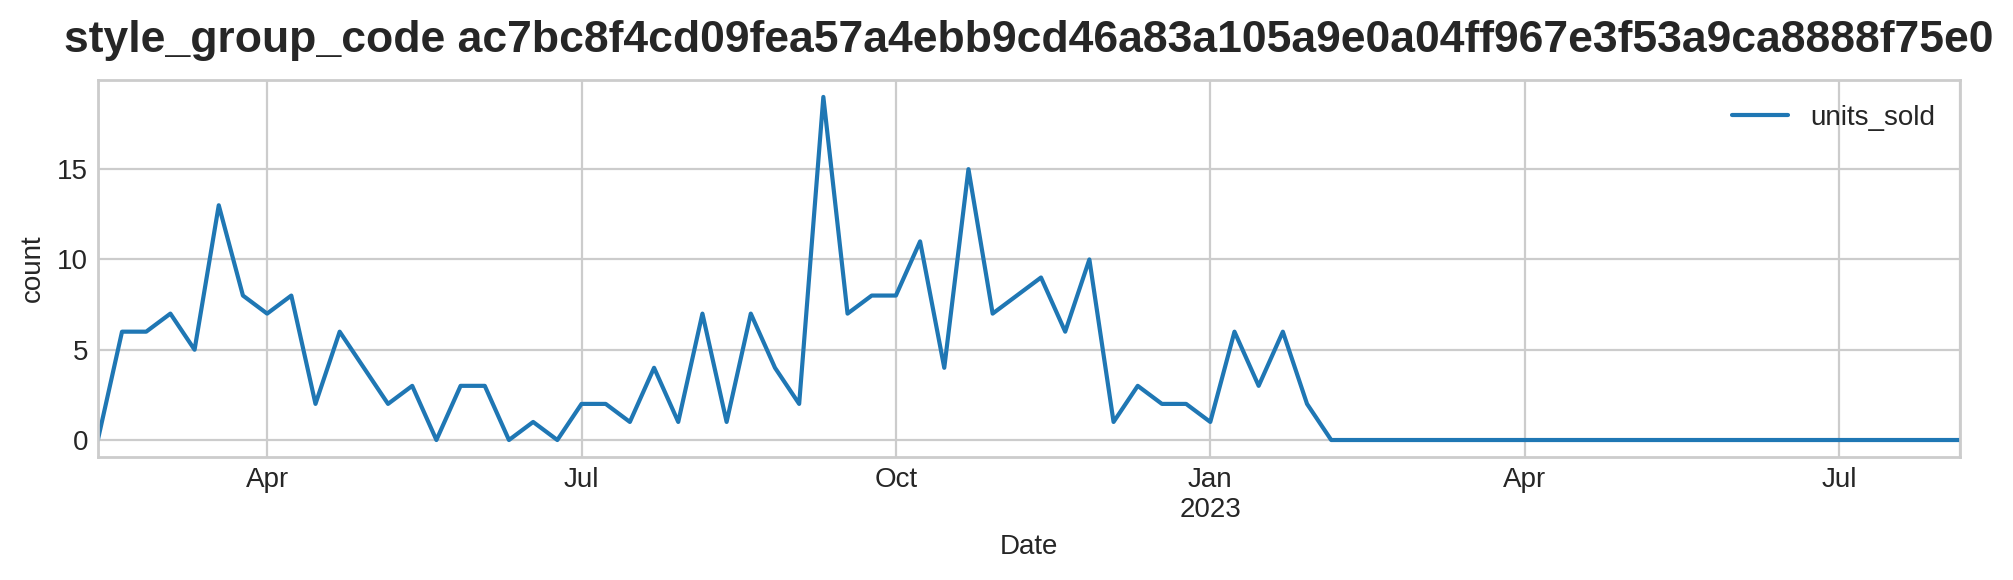

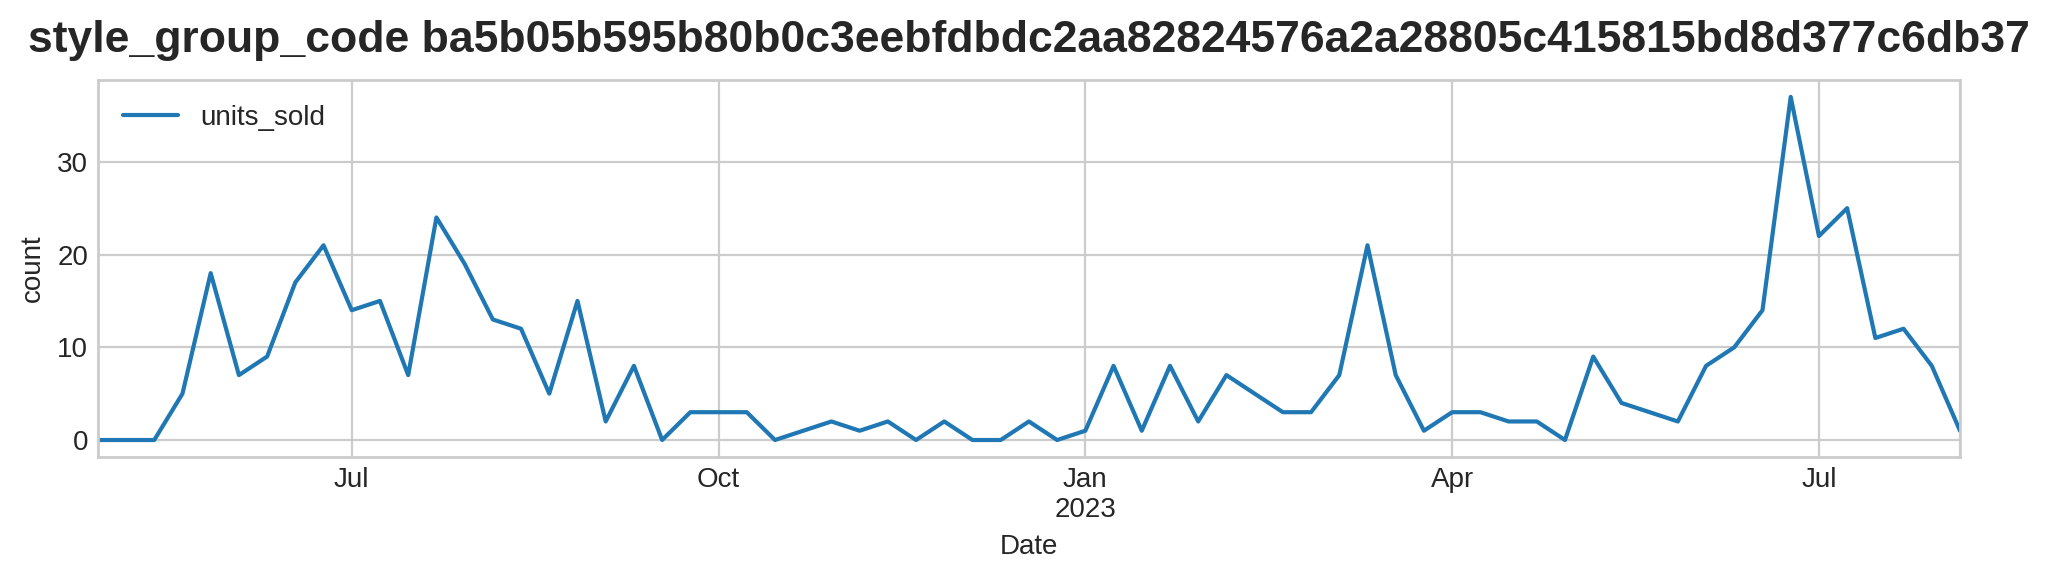

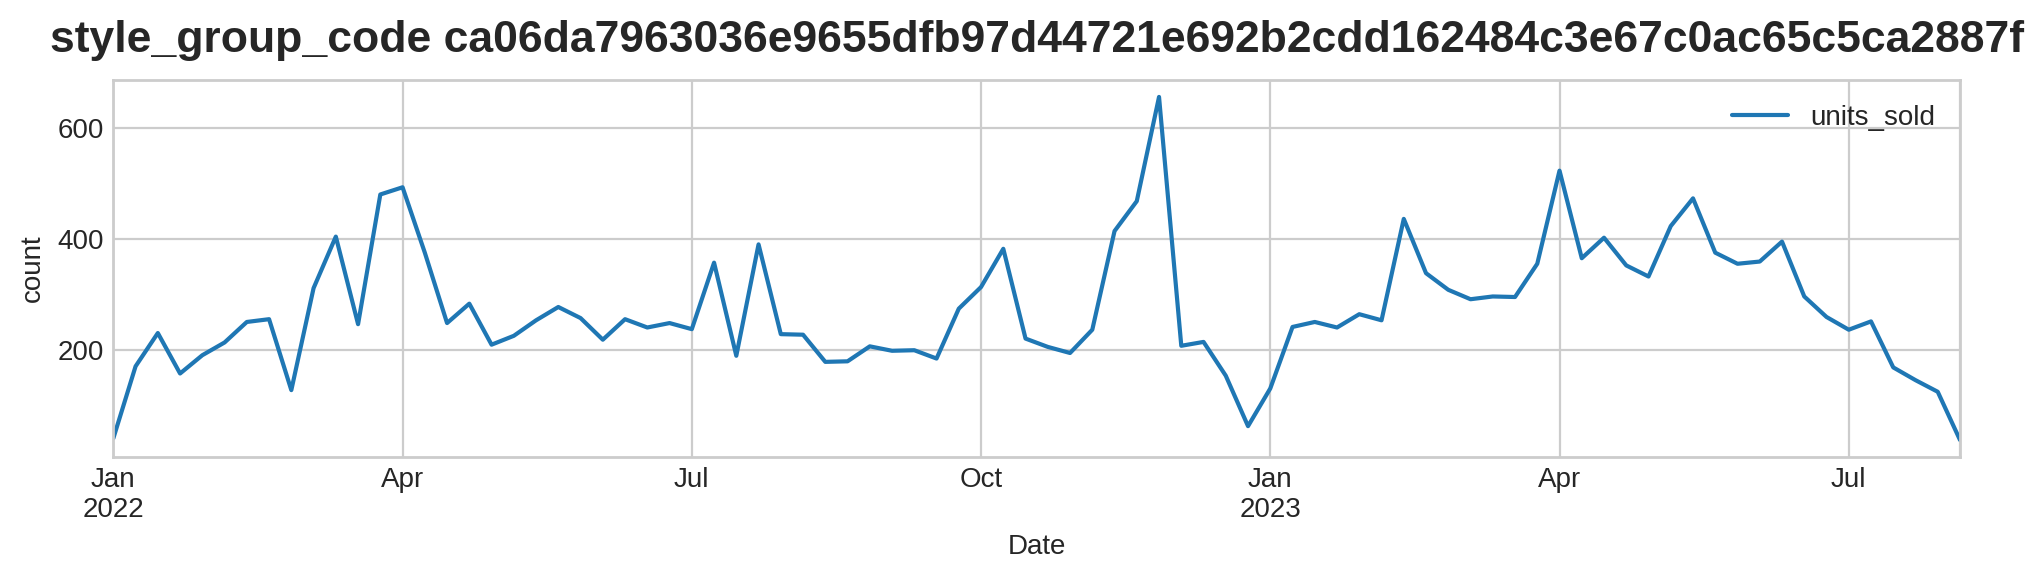

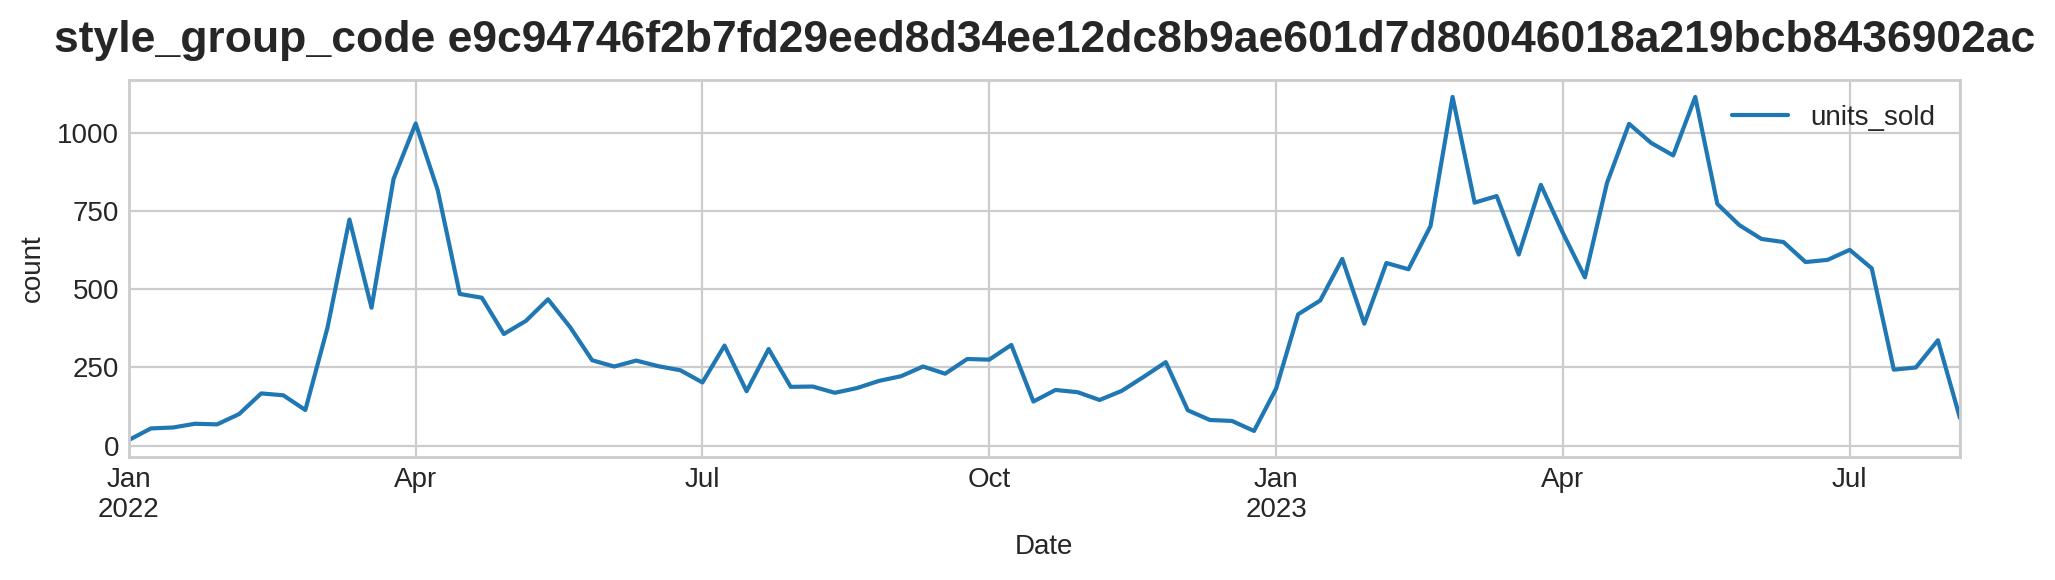

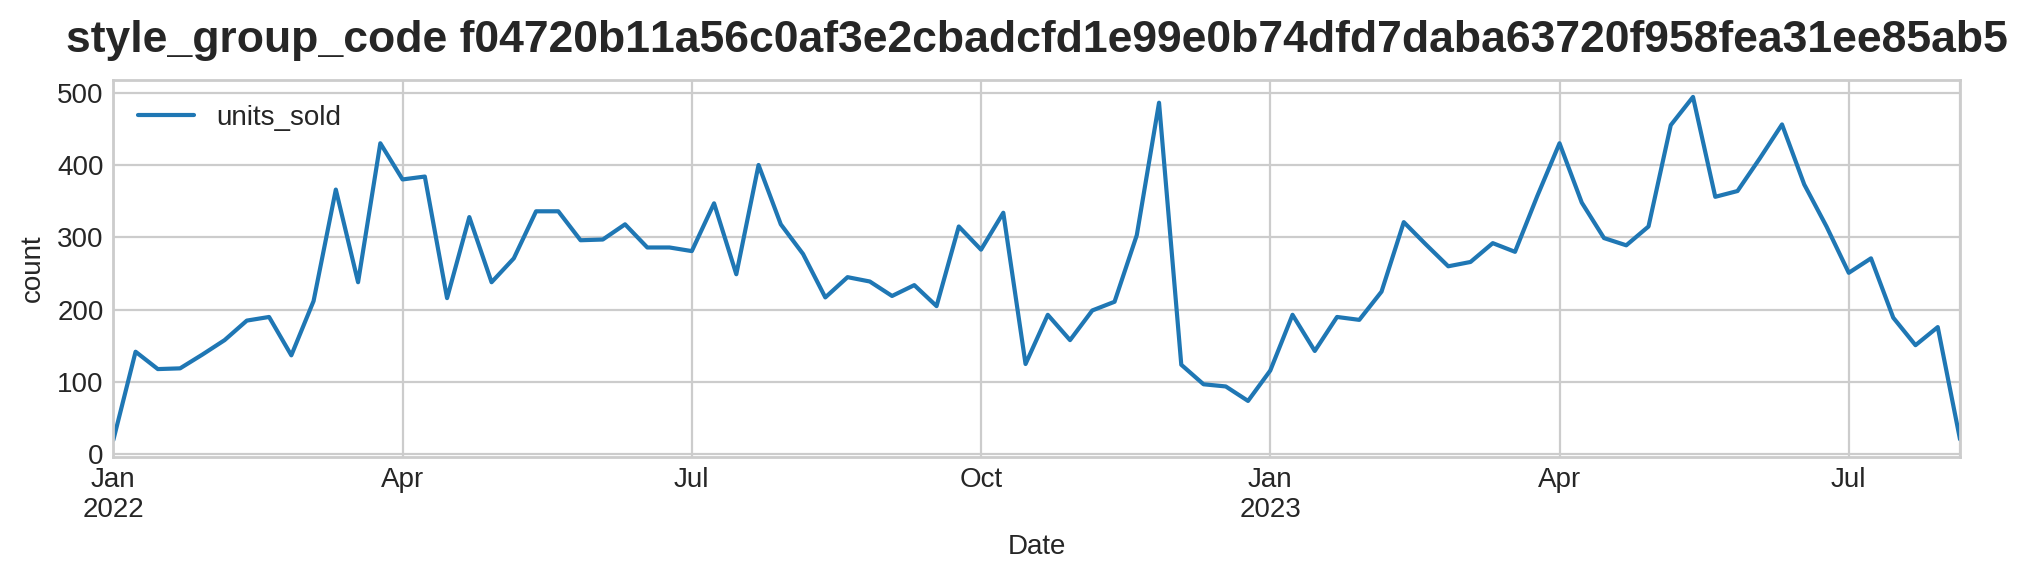

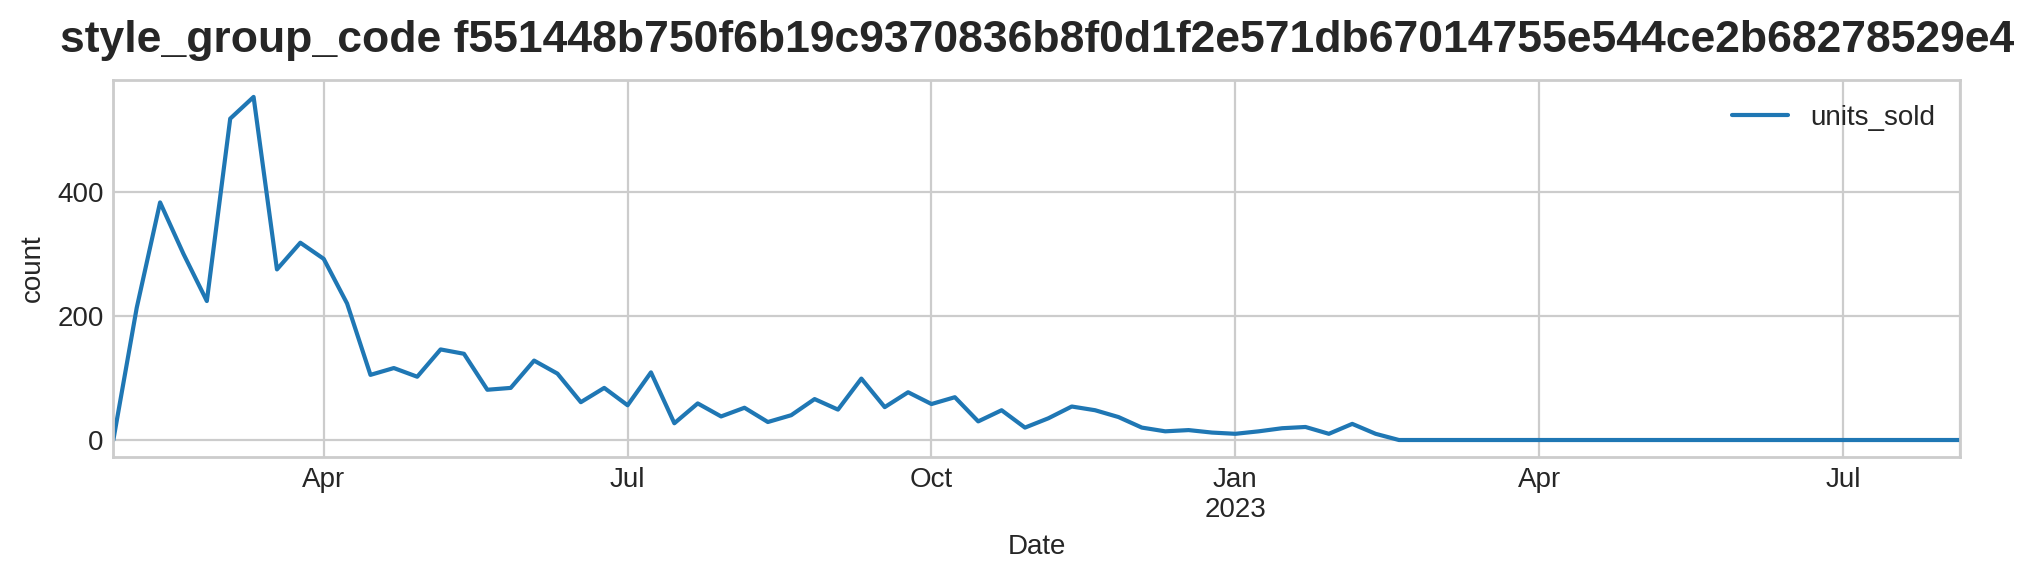

In [476]:
unique_style_group = df.style_group.unique()
import matplotlib
import pylab
for i in unique_style_group:
    train_1 = df[df.style_group == i][['transaction_date', 'units_sold']]
    grpd_weekly = train_1.resample('W',on='transaction_date').sum()
    grpd_weekly.plot(figsize = (10,3), title = f'style_group_code {i}',xlabel = 'Date',ylabel = 'count')
    pylab.show()

- High Volatility and unpredictability coupled with sporadic demand
- Seasonal fashion trends - shorter product life cycles

#### STL decomposition of a time series

'style group 2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5'

'style group aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f'

'style group ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0'

'style group ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37'

'style group ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f'

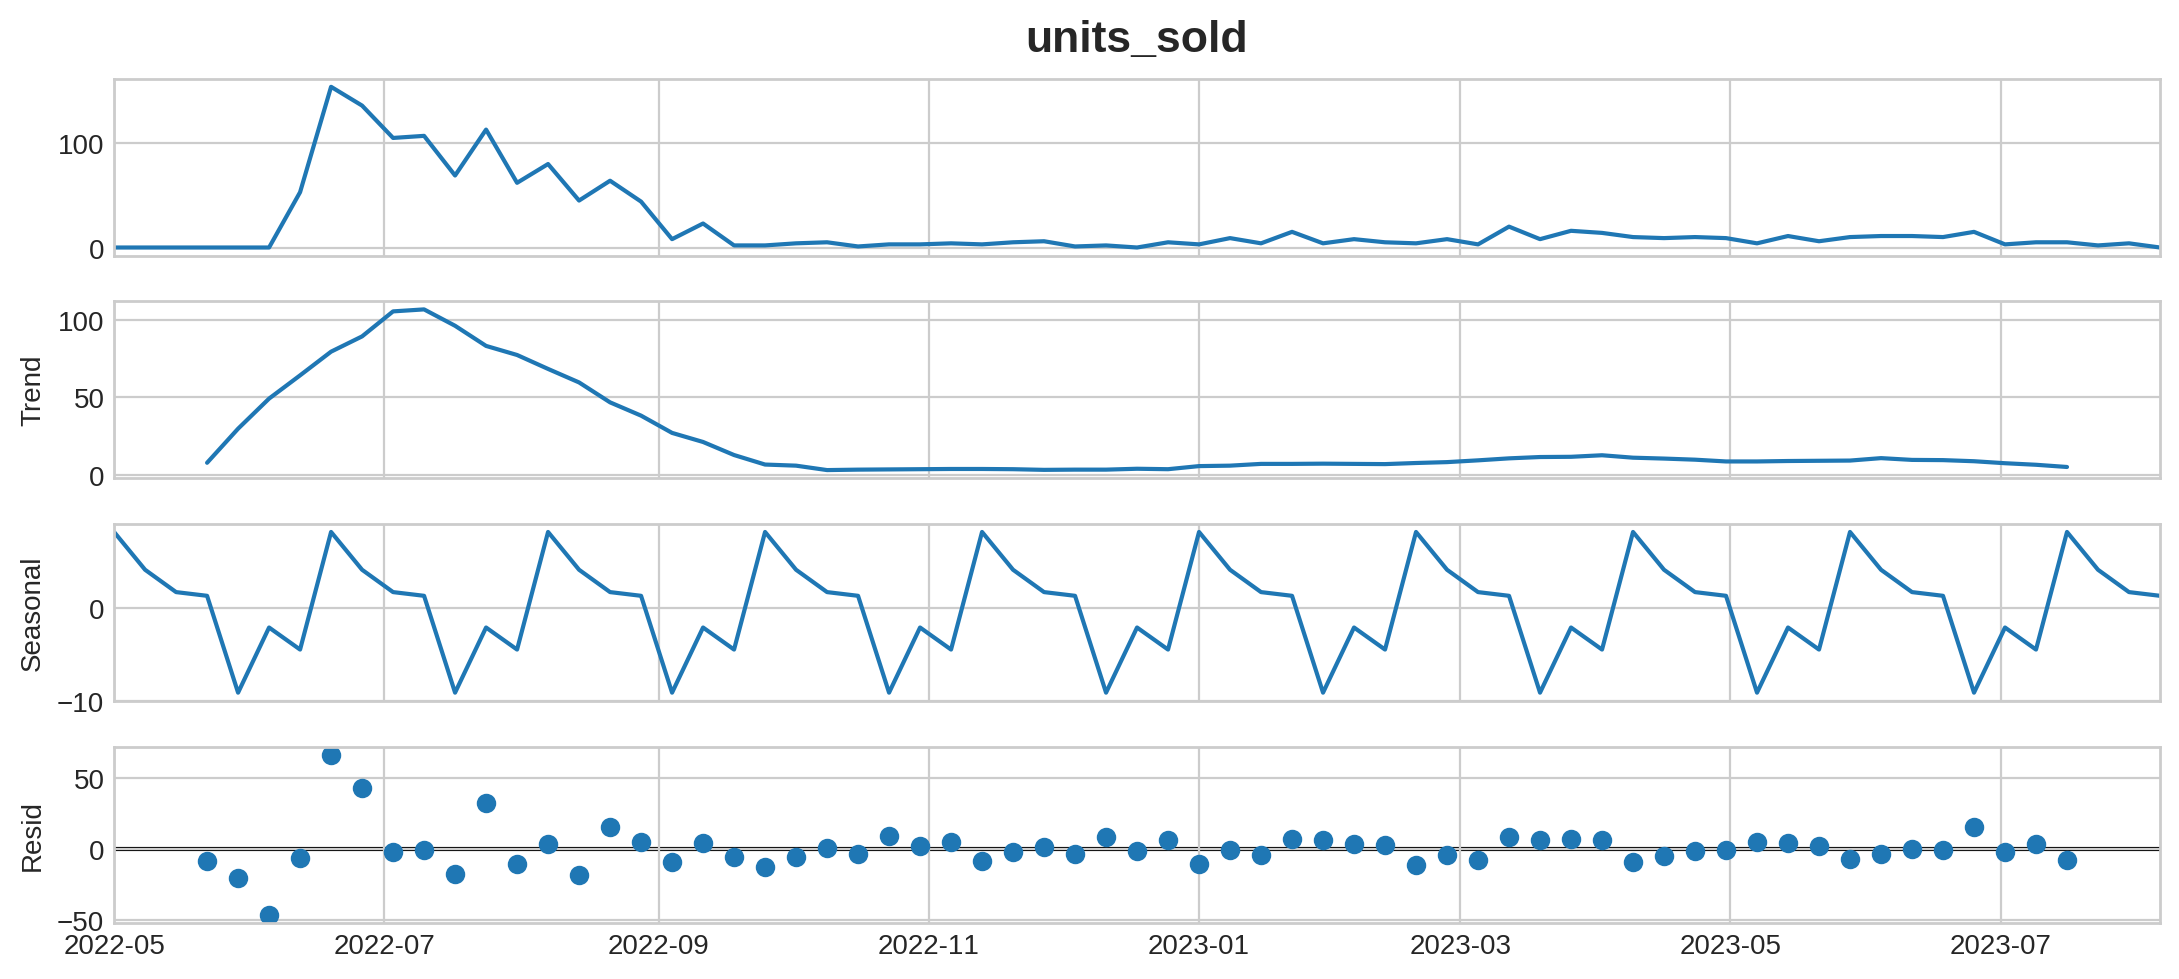

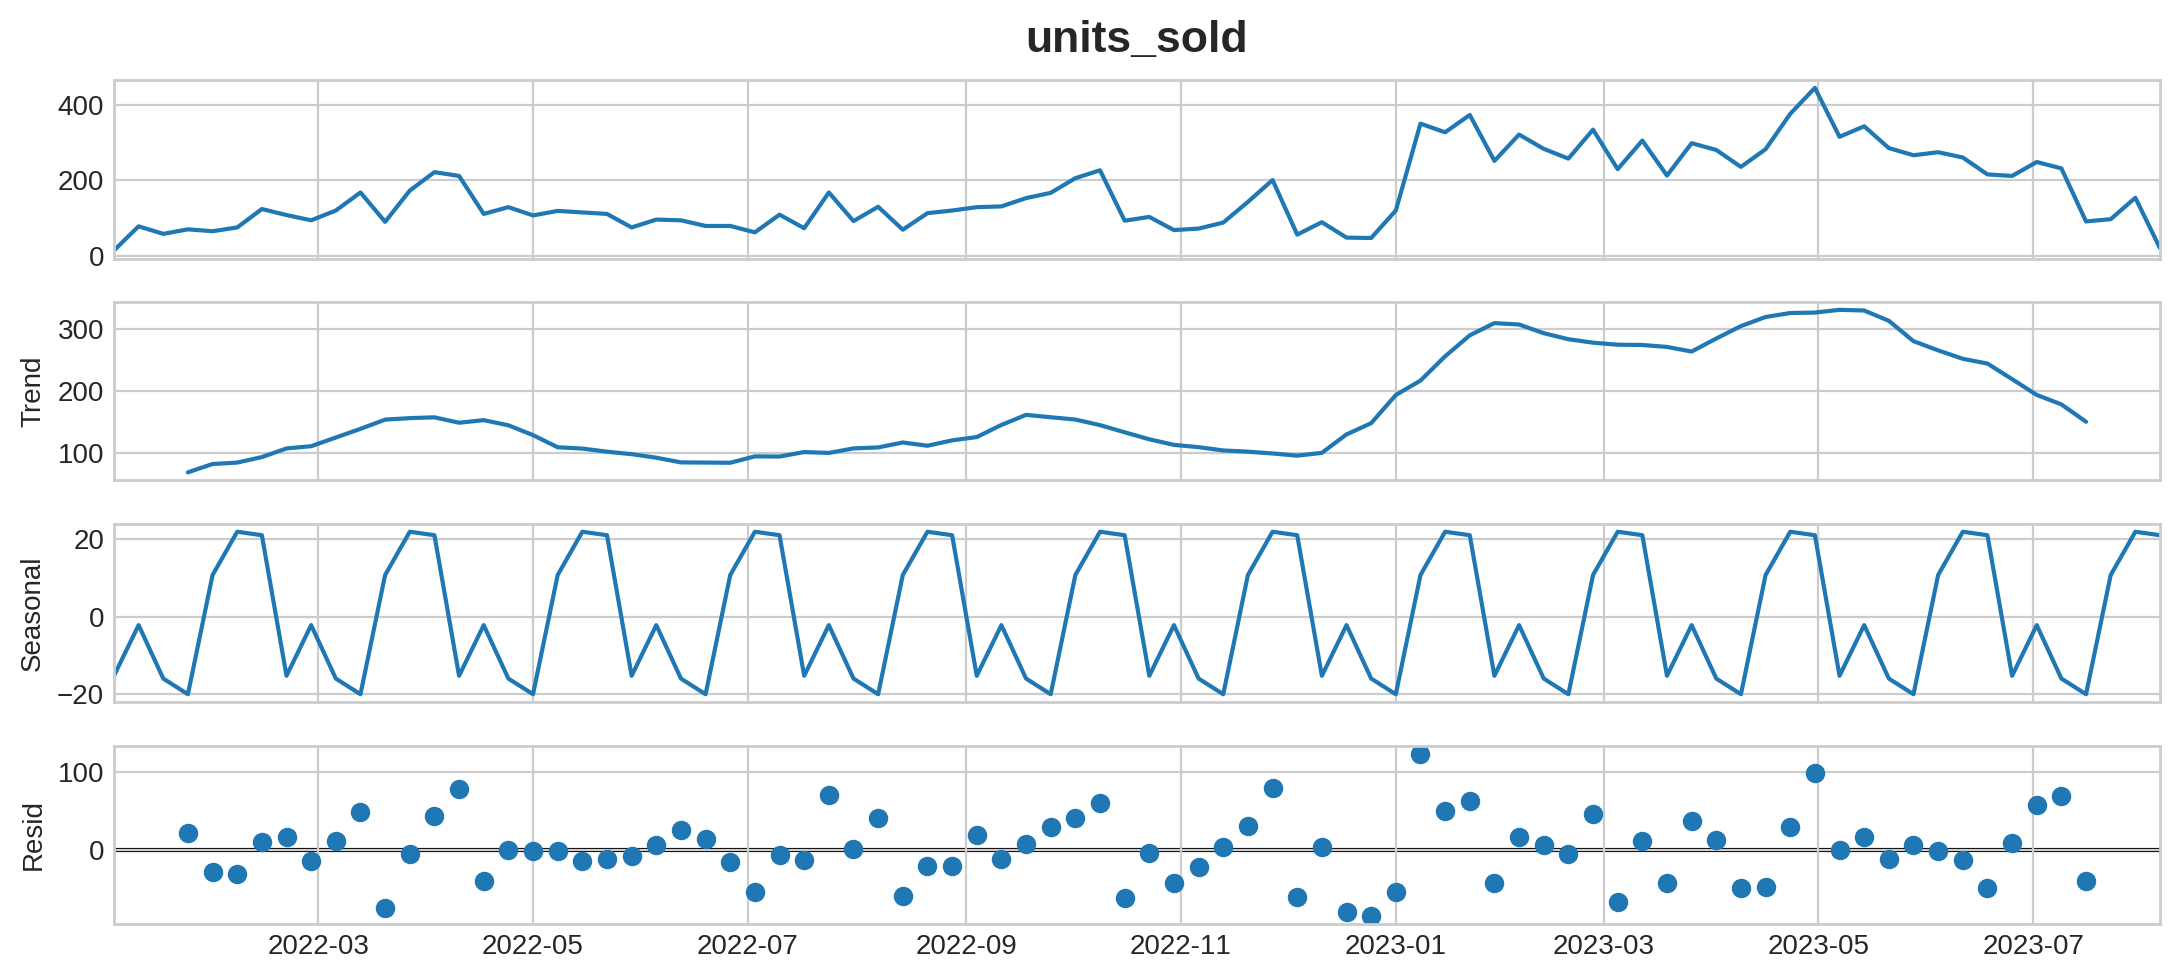

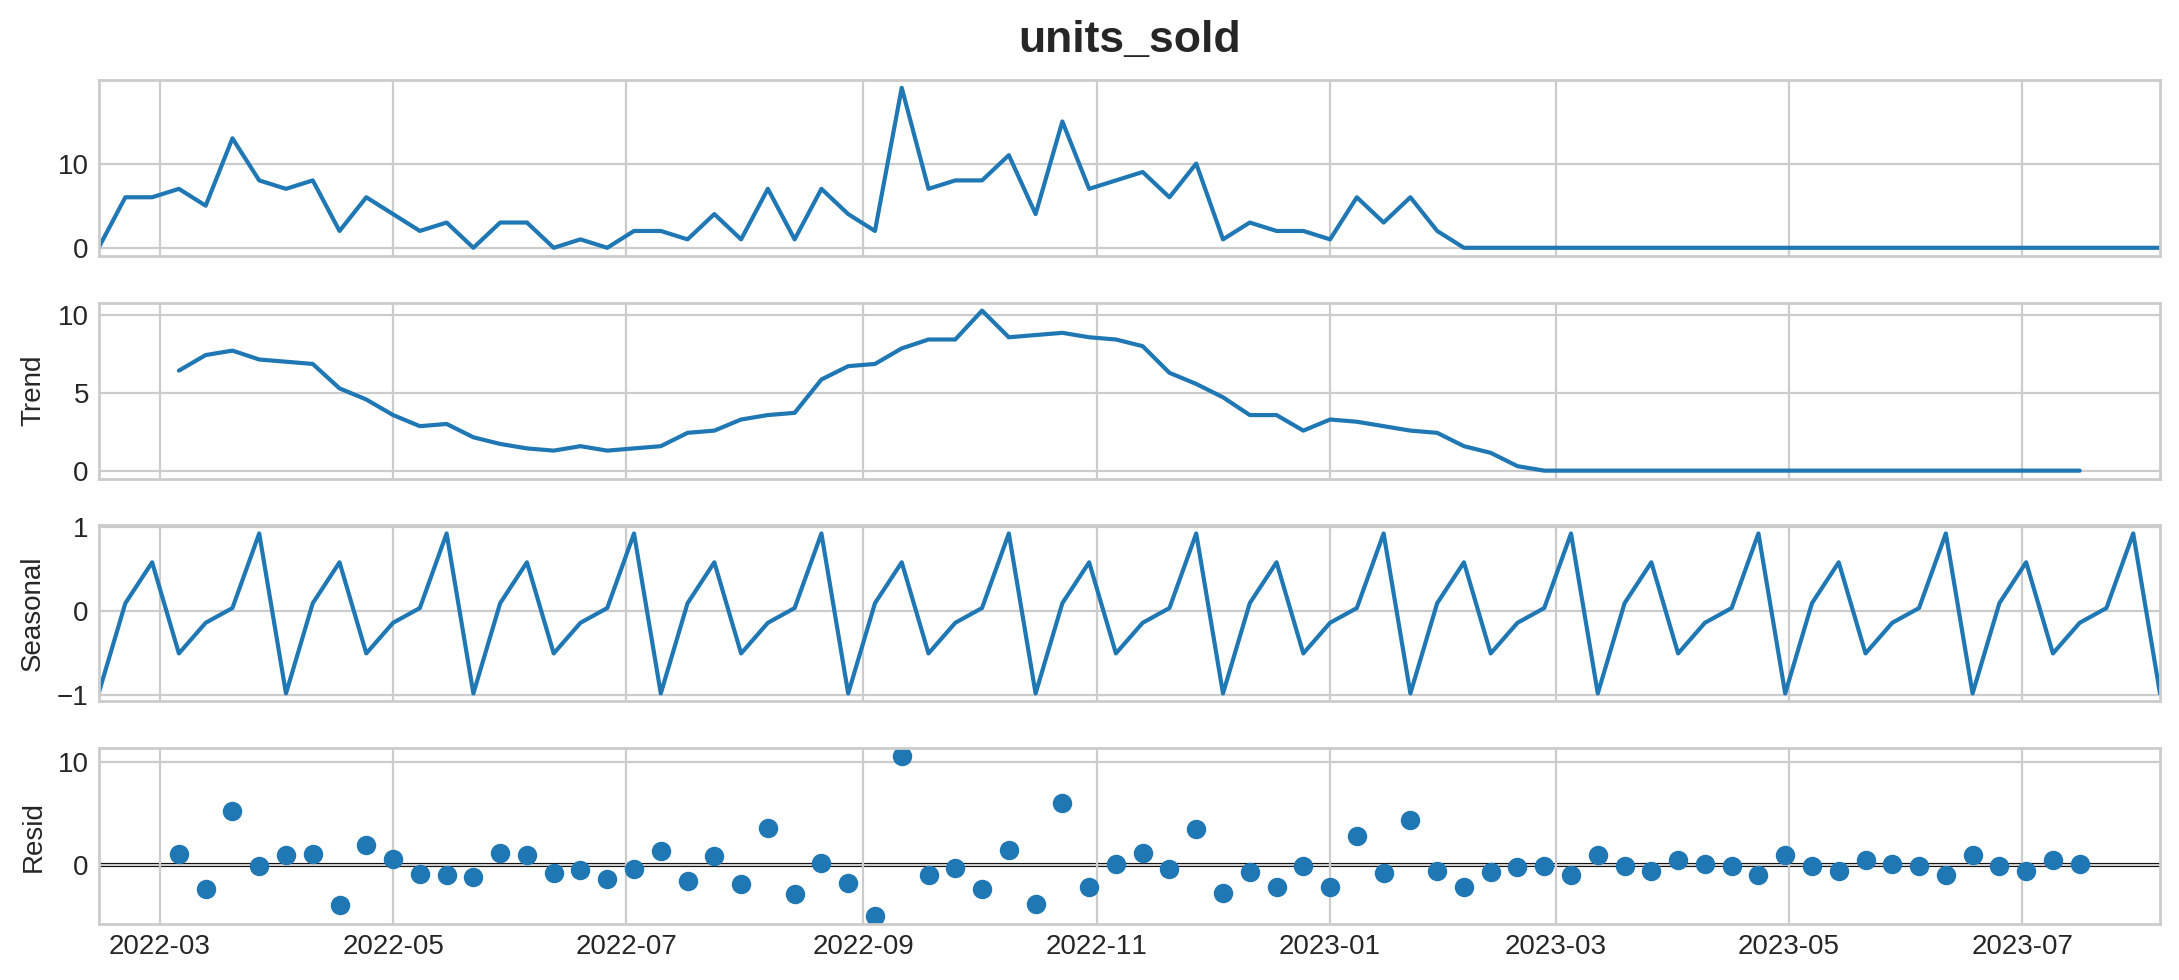

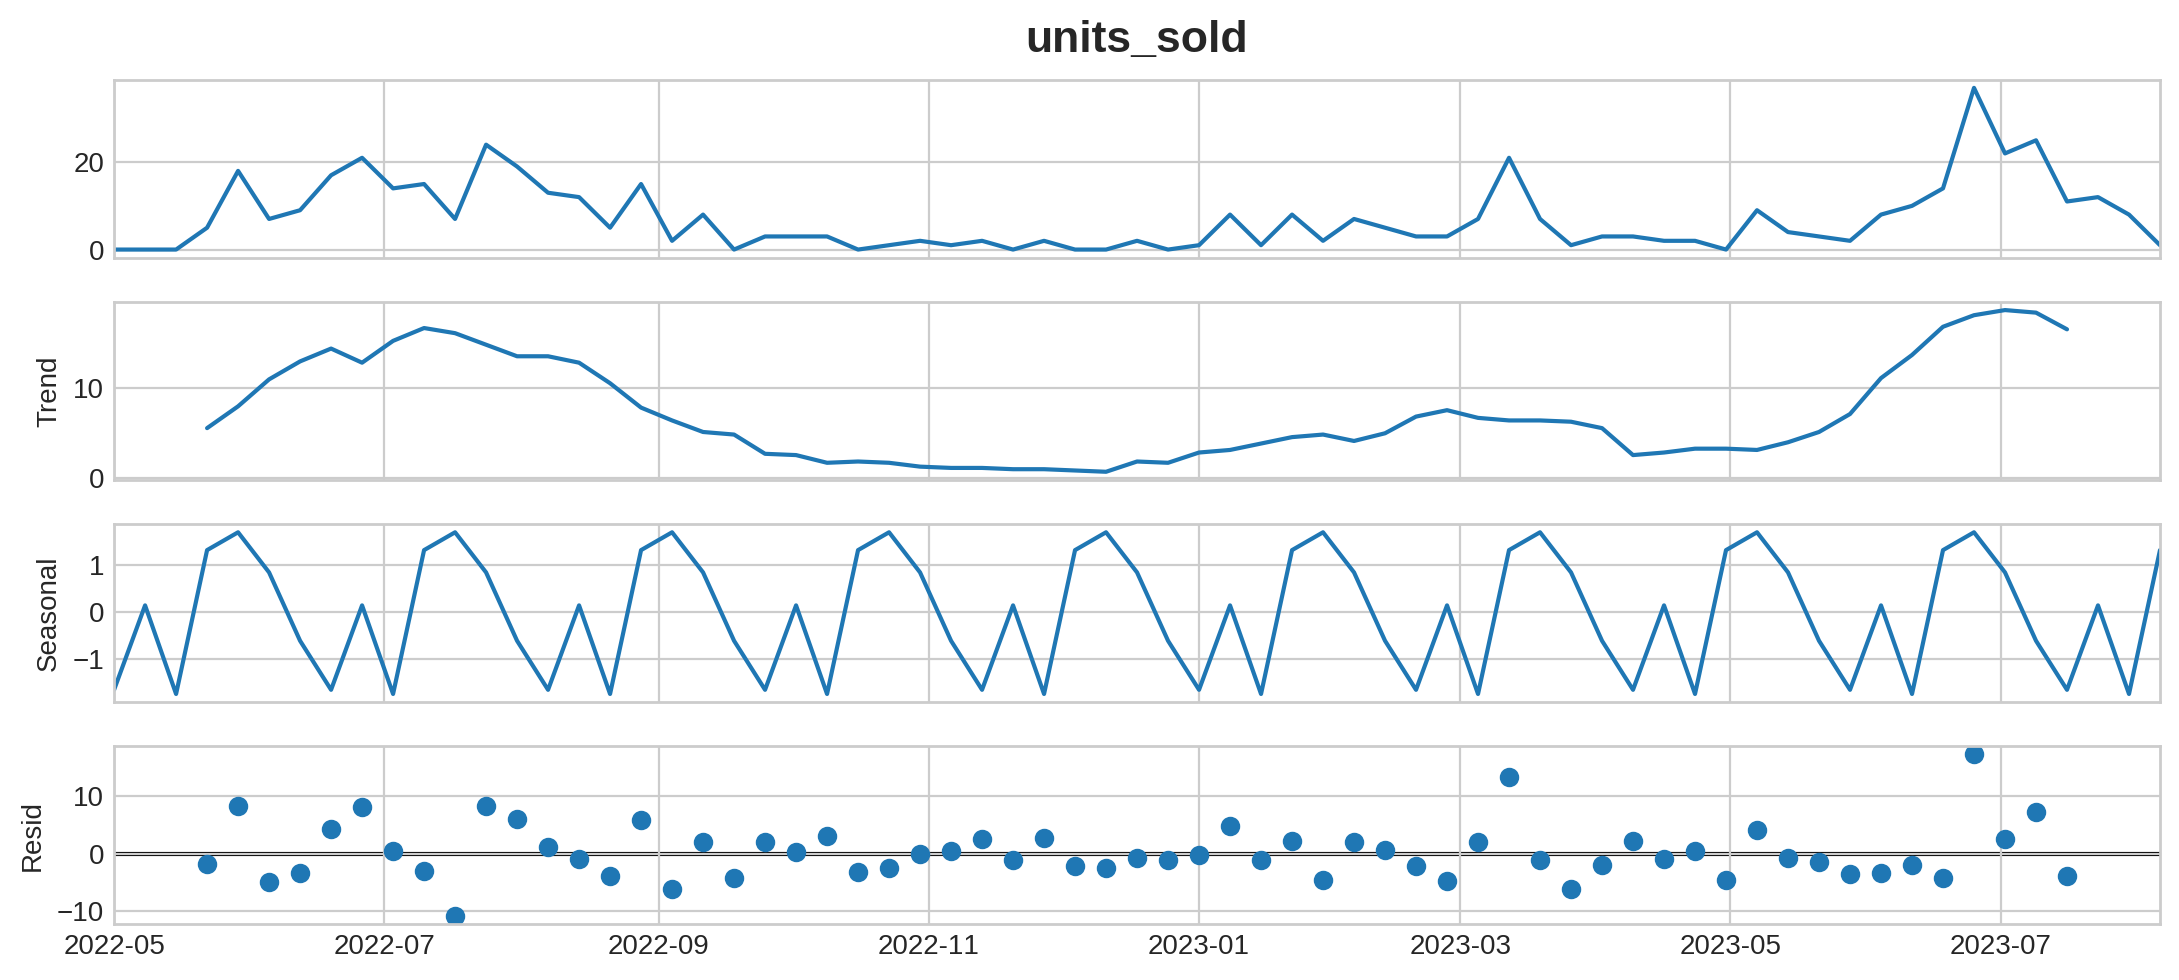

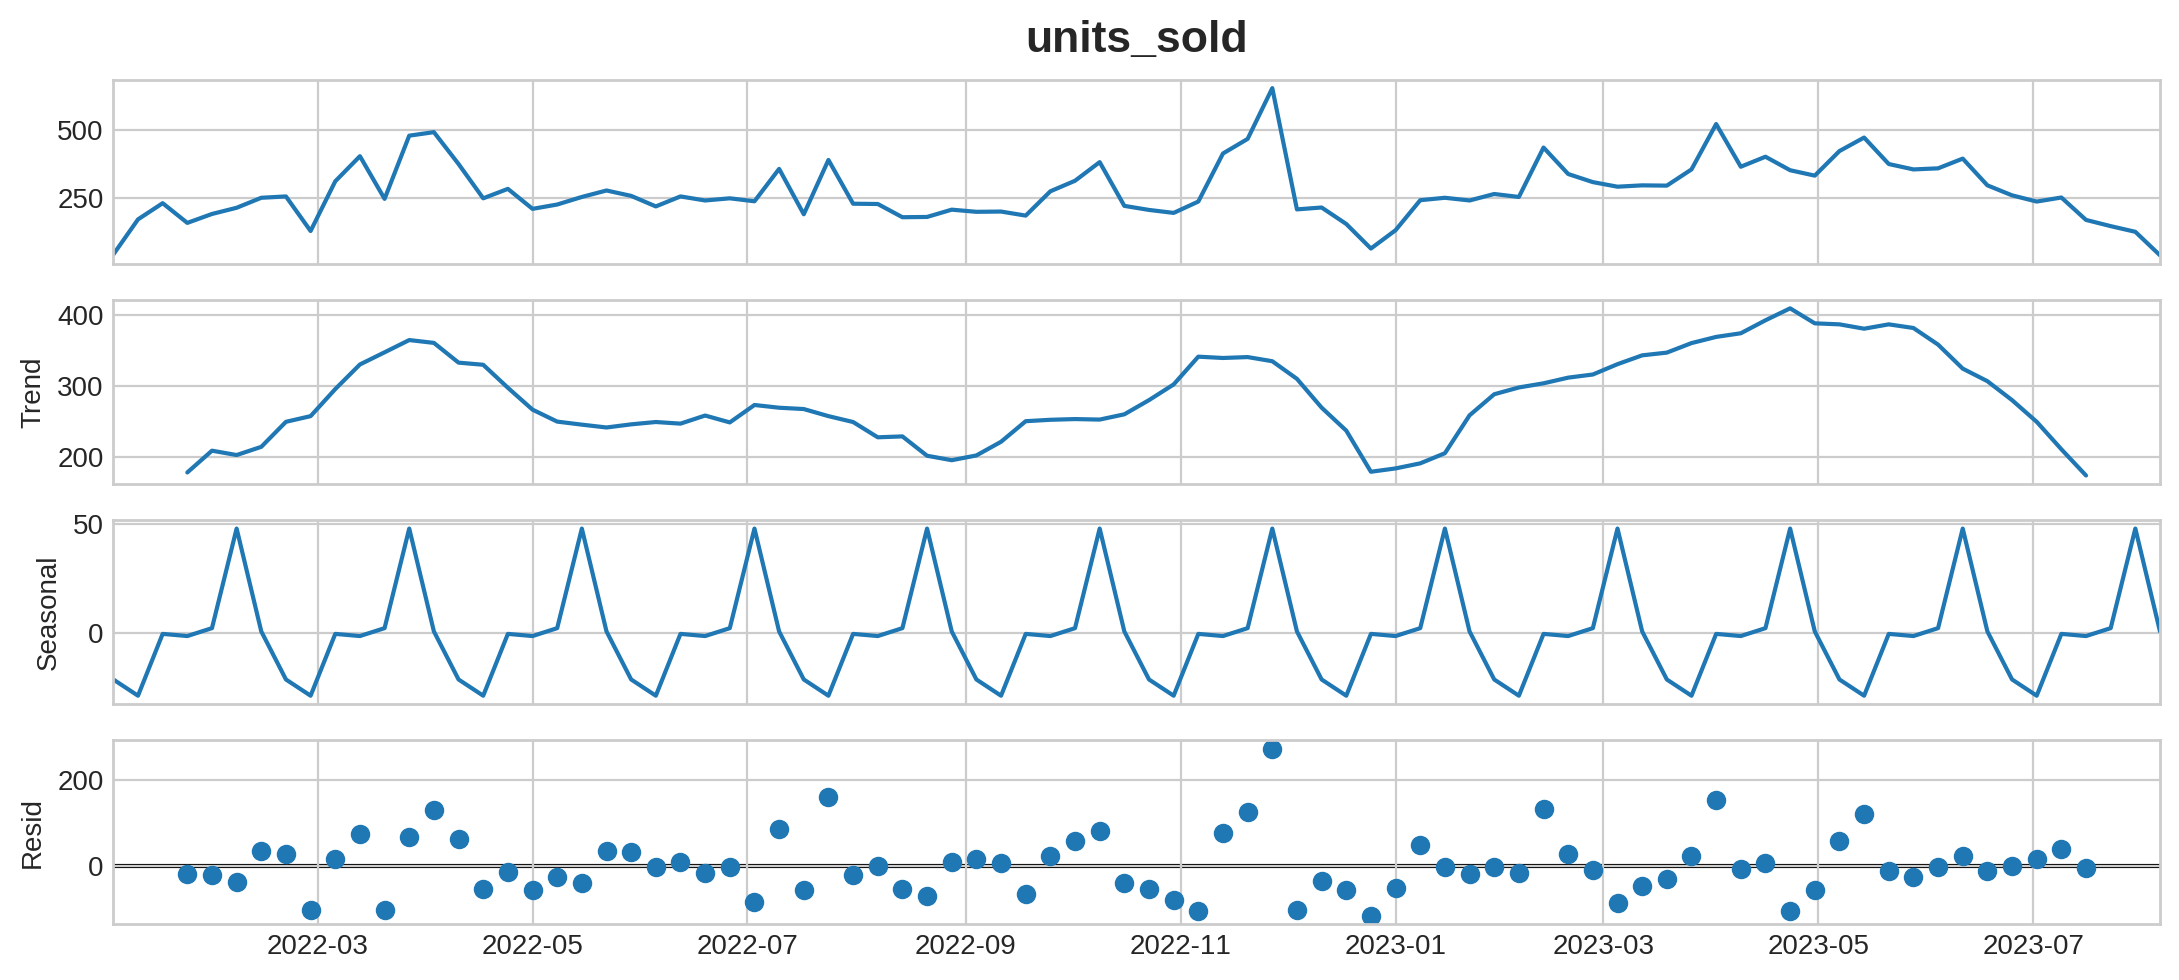

In [477]:
from statsmodels.tsa.seasonal import seasonal_decompose
for style_group in unique_style_group[0:5]:
    train_1 = df[df.style_group == style_group][['transaction_date', 'units_sold']]
    grpd_weekly = train_1.resample('W',on='transaction_date').sum()
    y = grpd_weekly.squeeze()
    result = seasonal_decompose(y,model='additive',period=7)
    display(f'style group {style_group}')
    result.plot(result)

- As expected visible seasonal component in sales.
- Further we may understand the frequency of the seasonality by converting time signal to frequency domain using Fourier transform

### Feature Engineering- Time Sereies property based

#### Seasonality analysis and FFT

In [ ]:
from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

#Seasonal Plot for each style_group
for i in unique_style_group:
    
    train_1 = df[df.style_group == i][['transaction_date', 'units_sold']]
    train_1 = train_1.set_index('transaction_date')
    train_1["day"] = train_1.index.dayofweek  # the x-axis (freq)
    train_1["week"] = train_1.index.week  # the seasonal period (period)

    # days within a year
    train_1["dayofyear"] = train_1.index.dayofyear
    train_1["year"] = train_1.index.year
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    seasonal_plot(train_1, y="units_sold", period="year", freq="dayofyear", ax=ax1);

### periodogram & seasonality selection

- The periodogram tells us the strength of the frequencies in a time series.

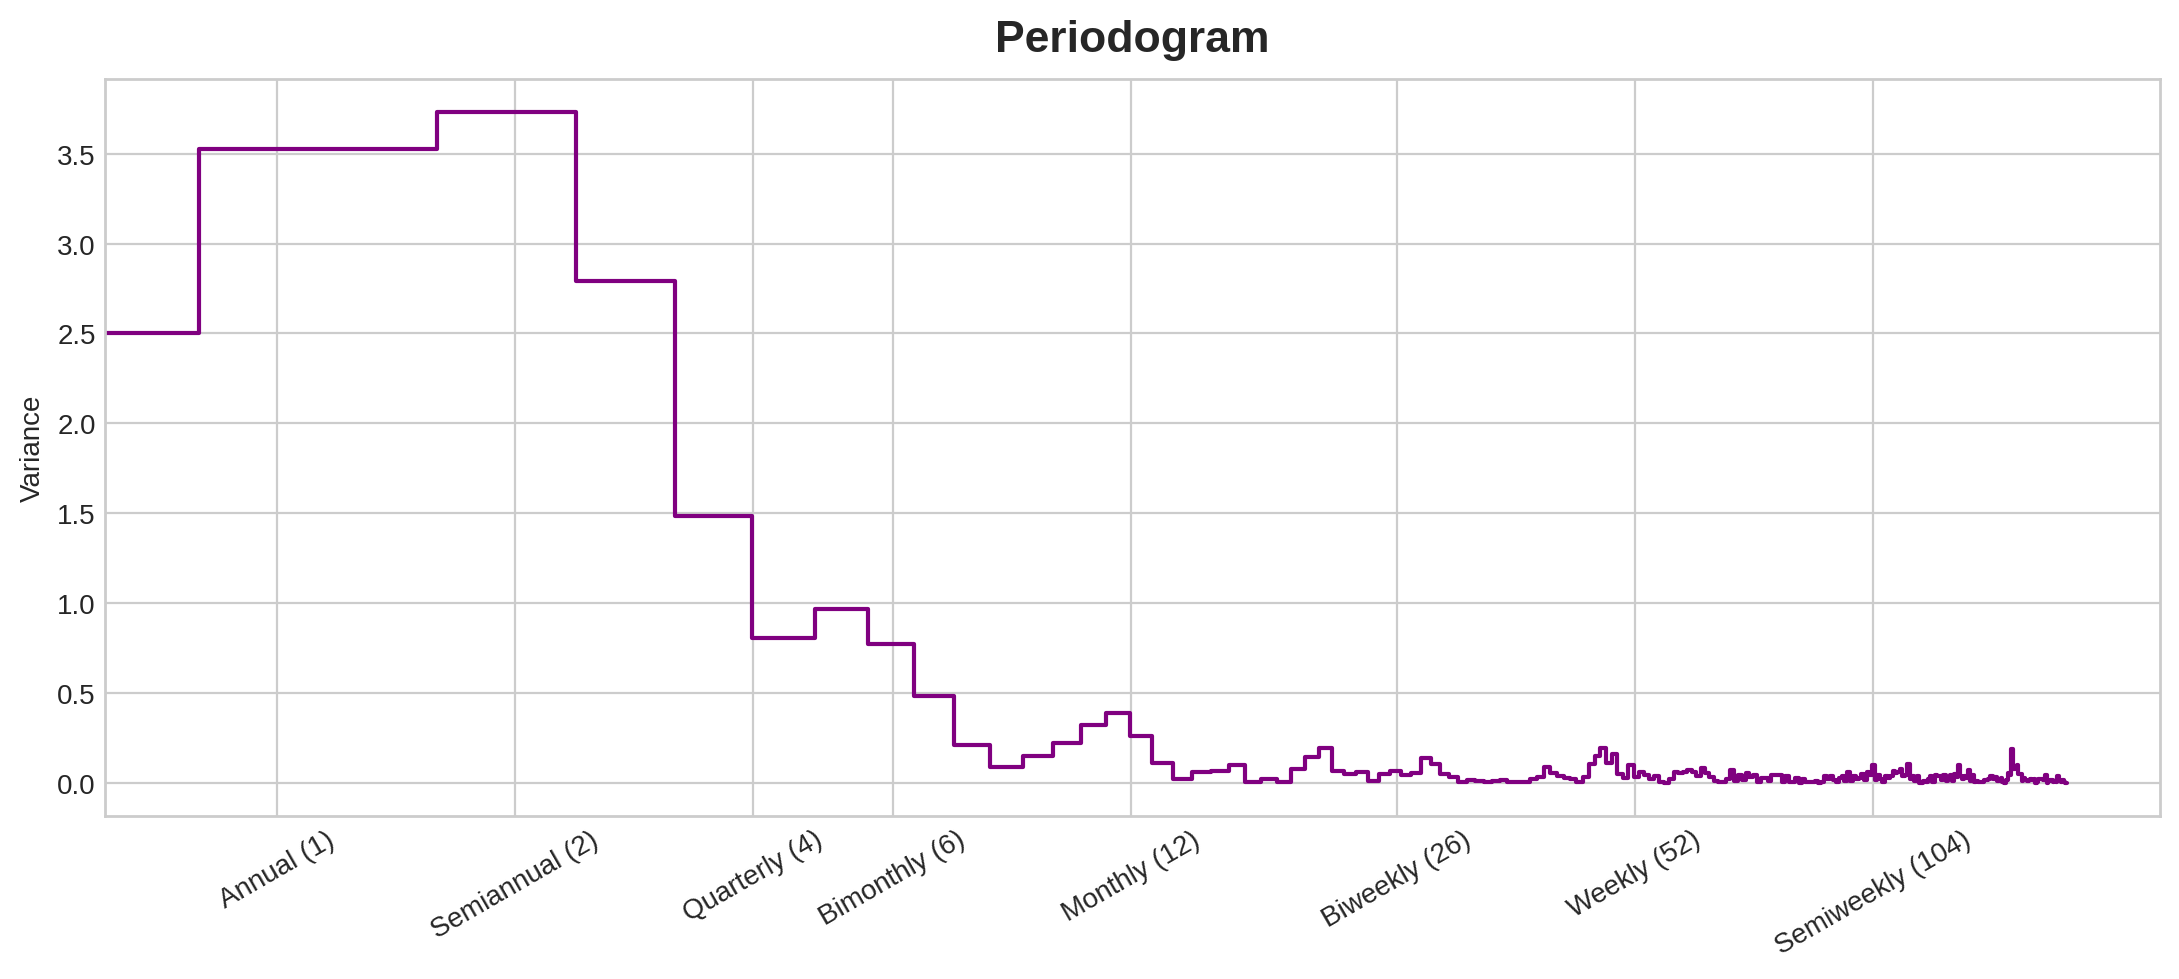

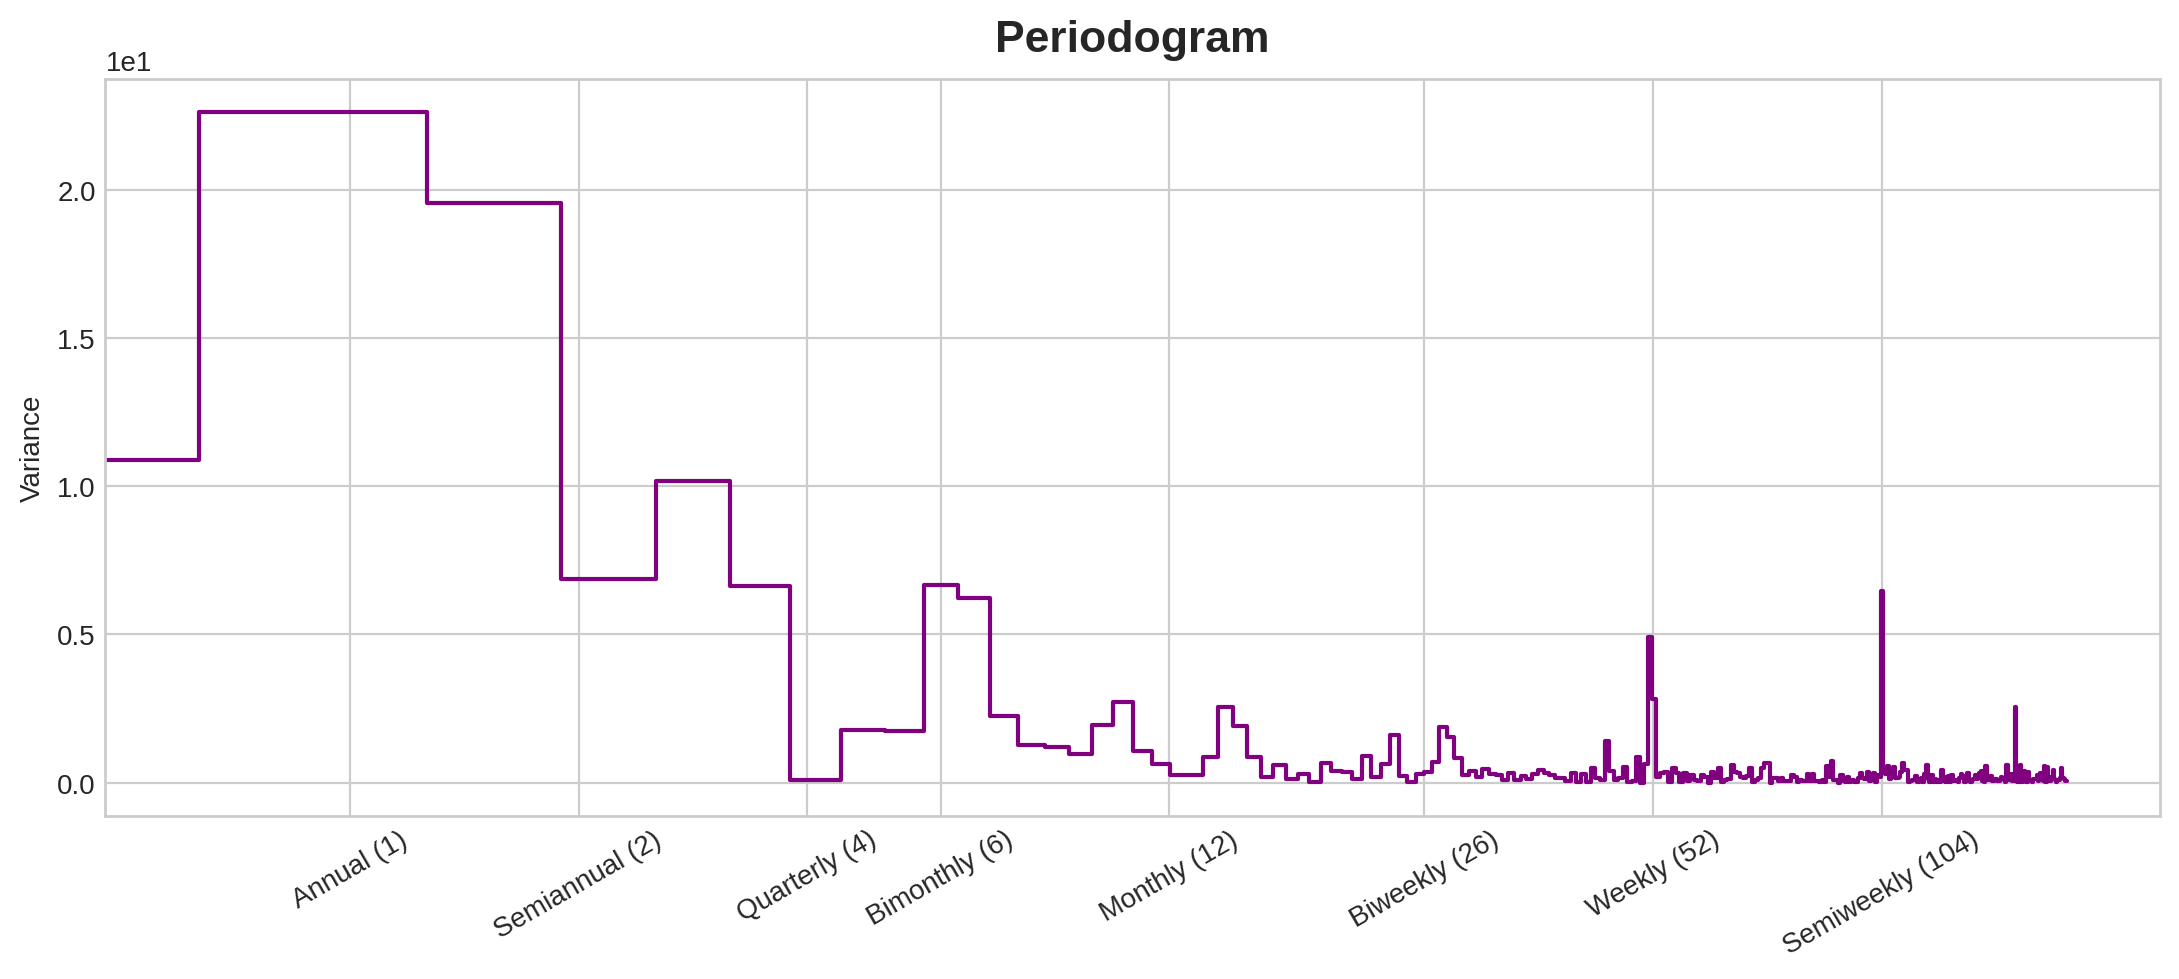

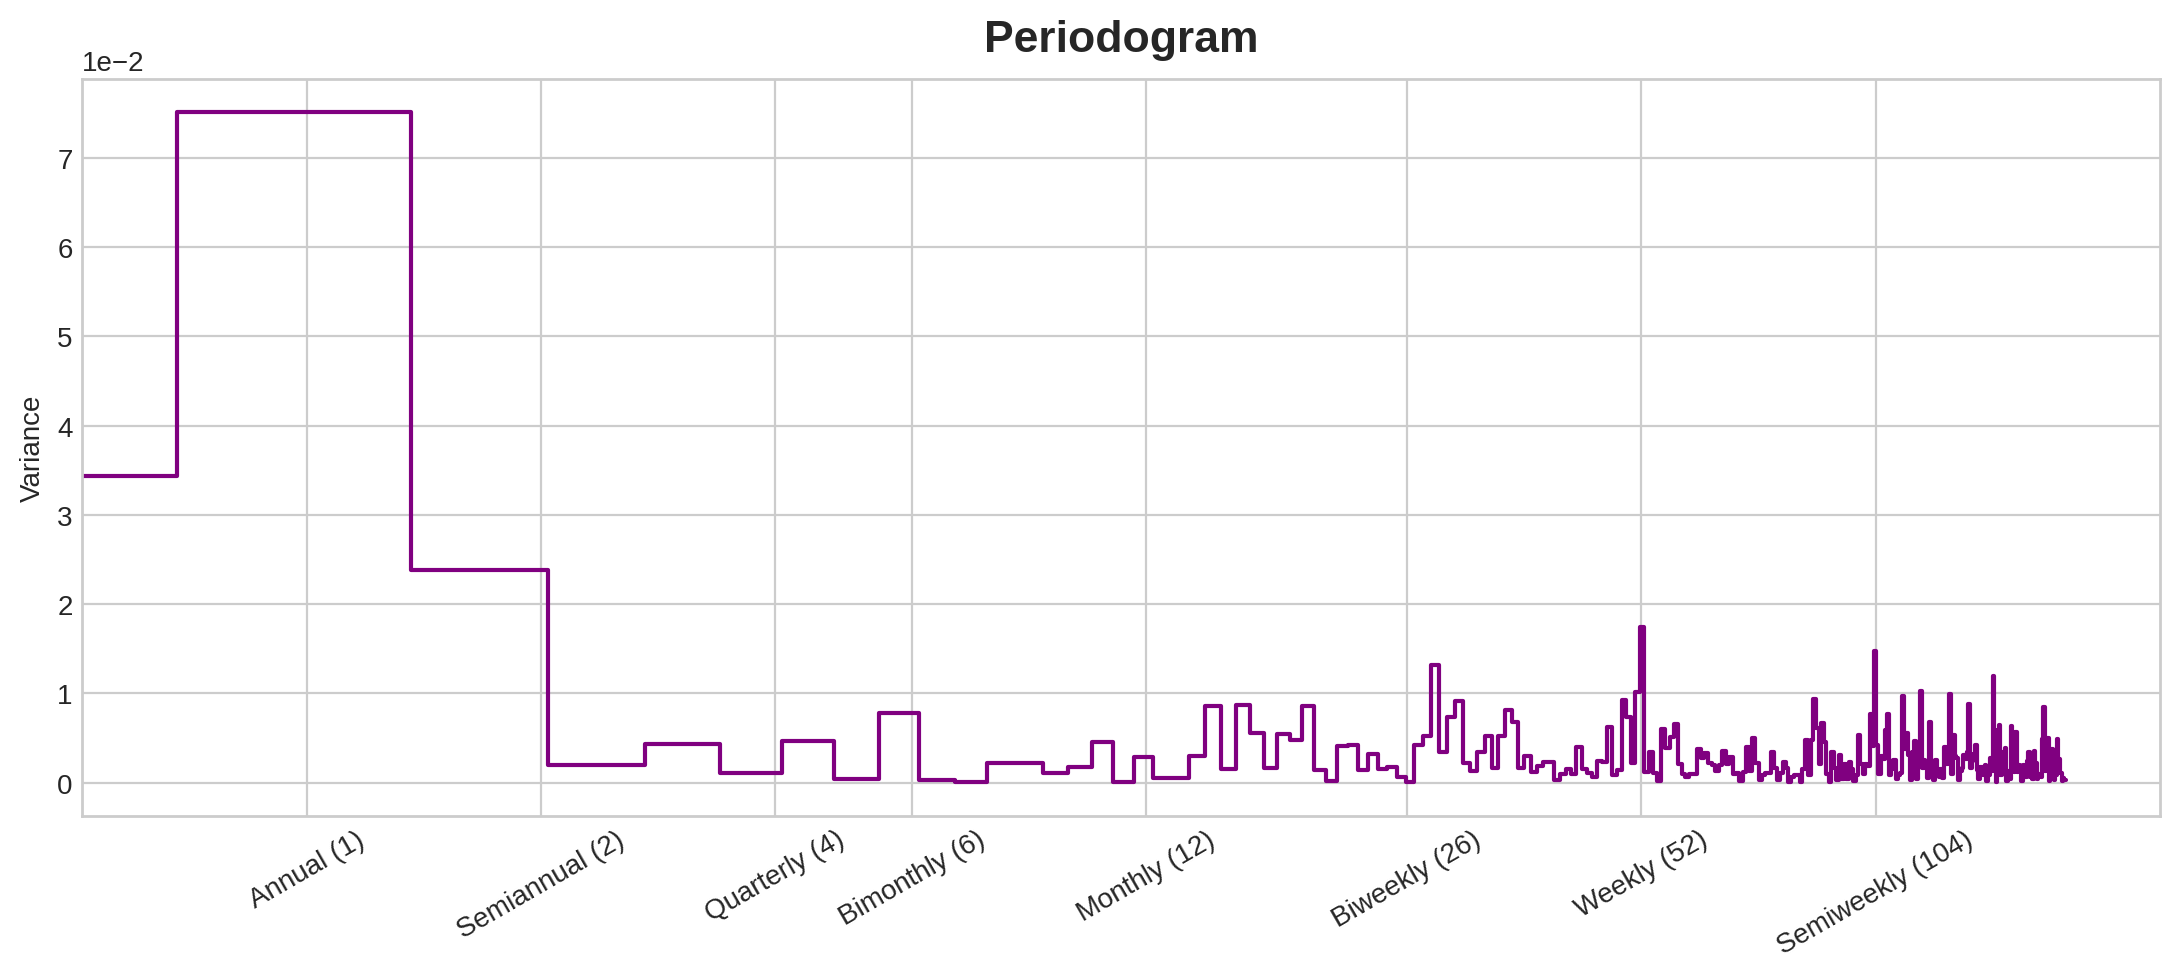

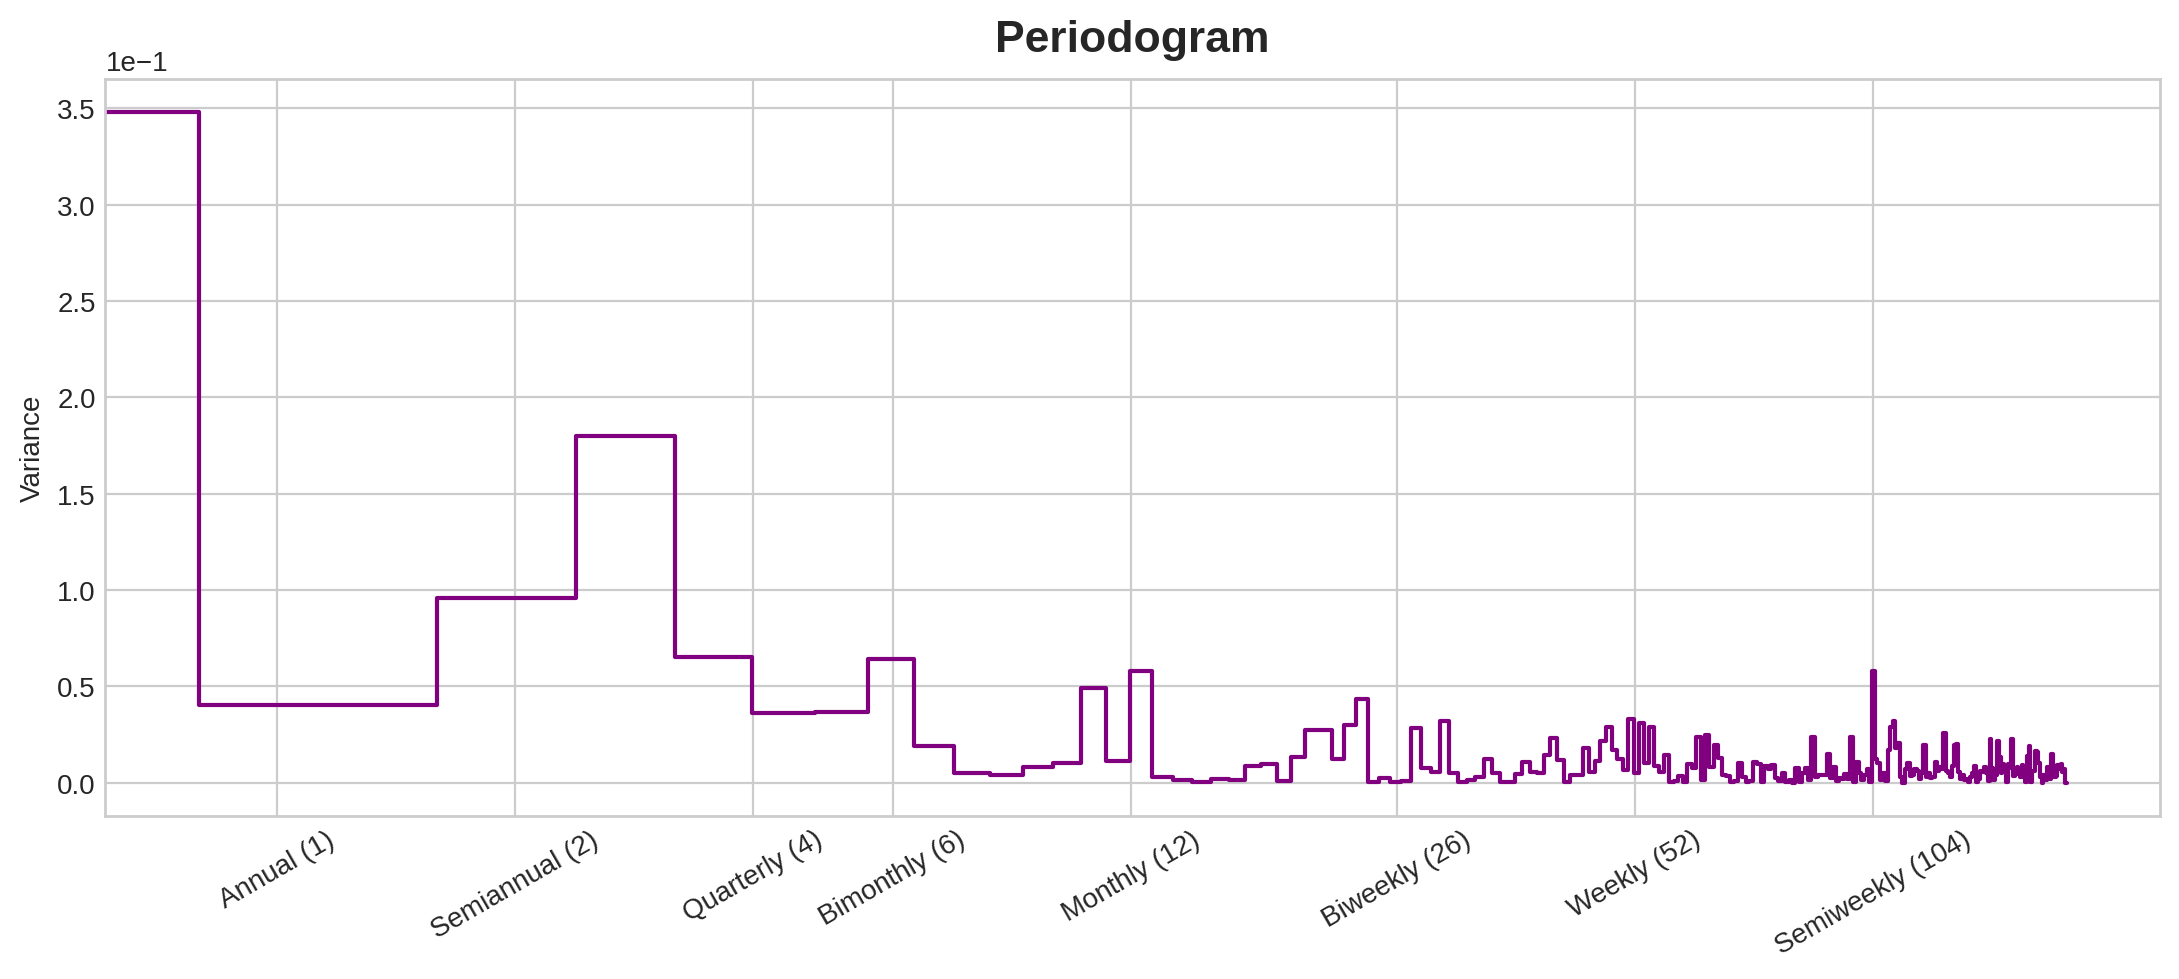

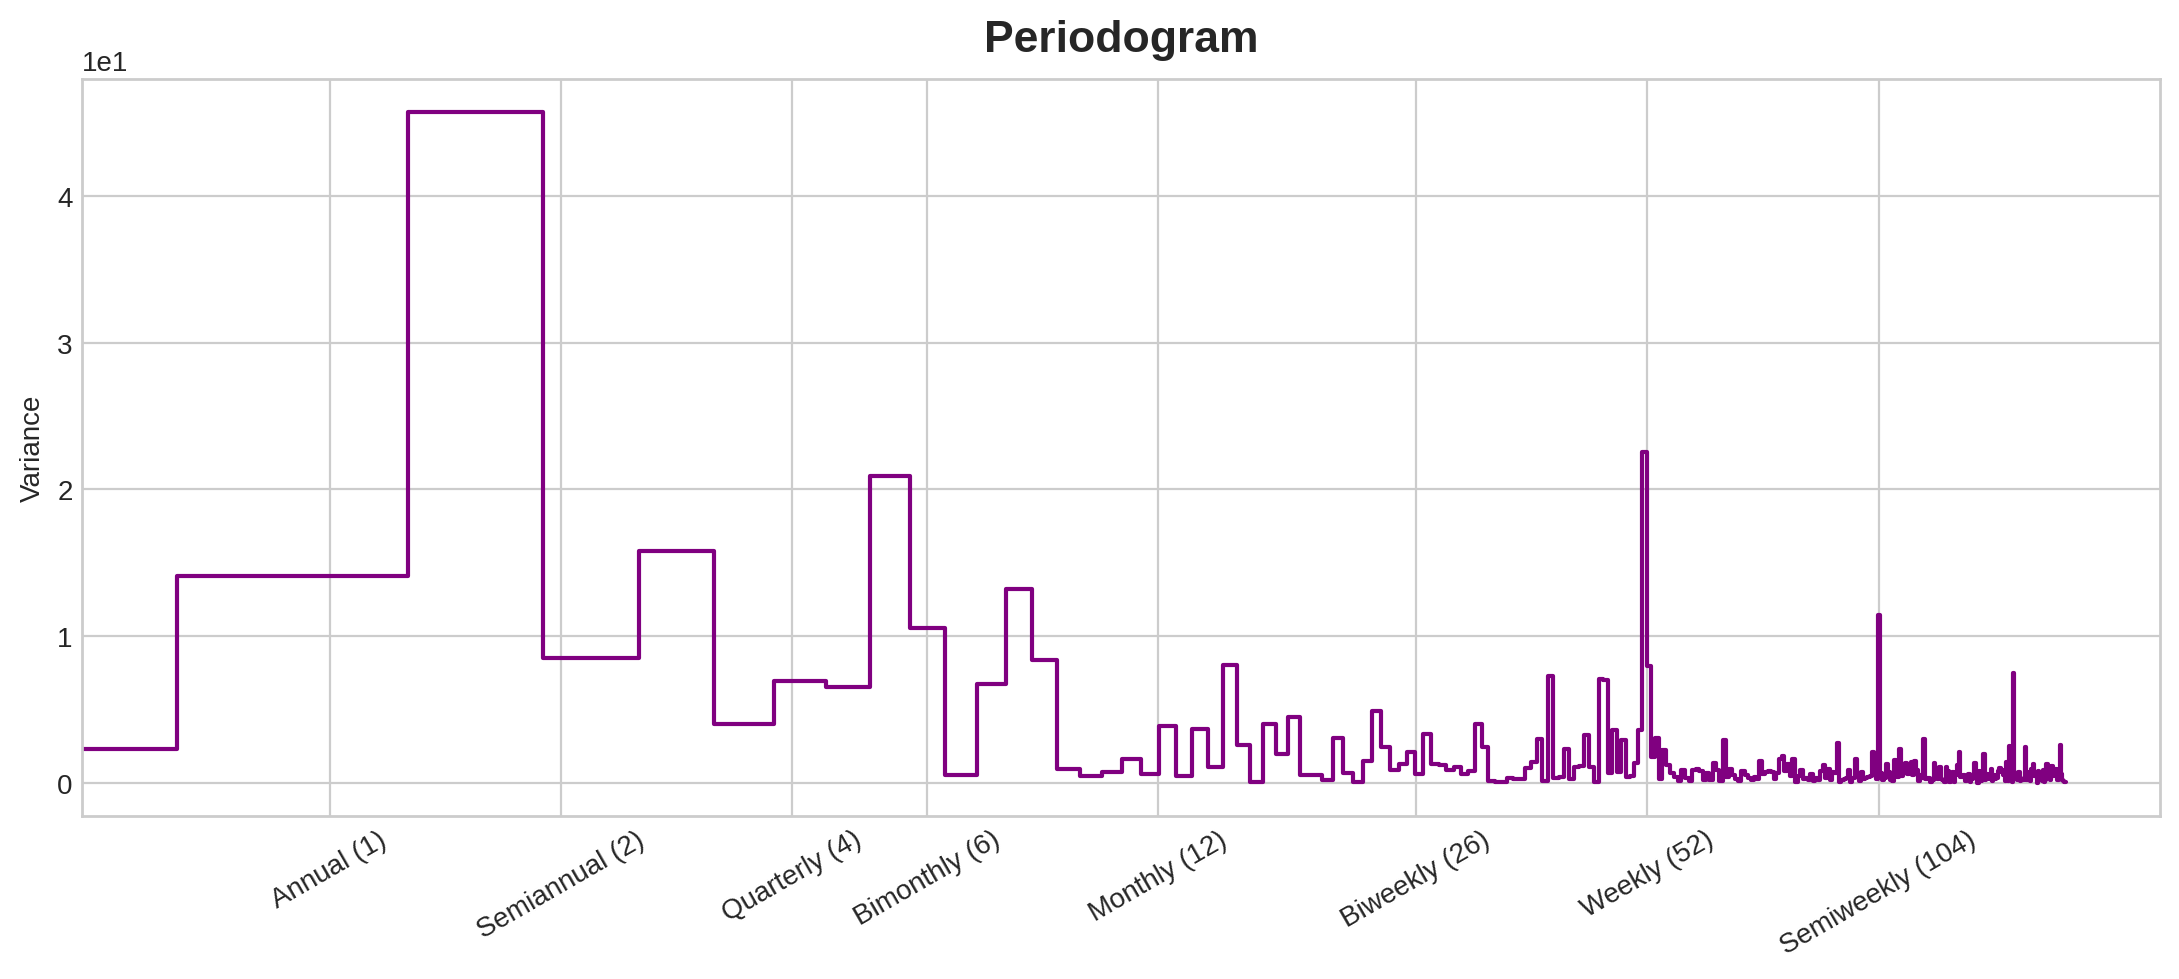

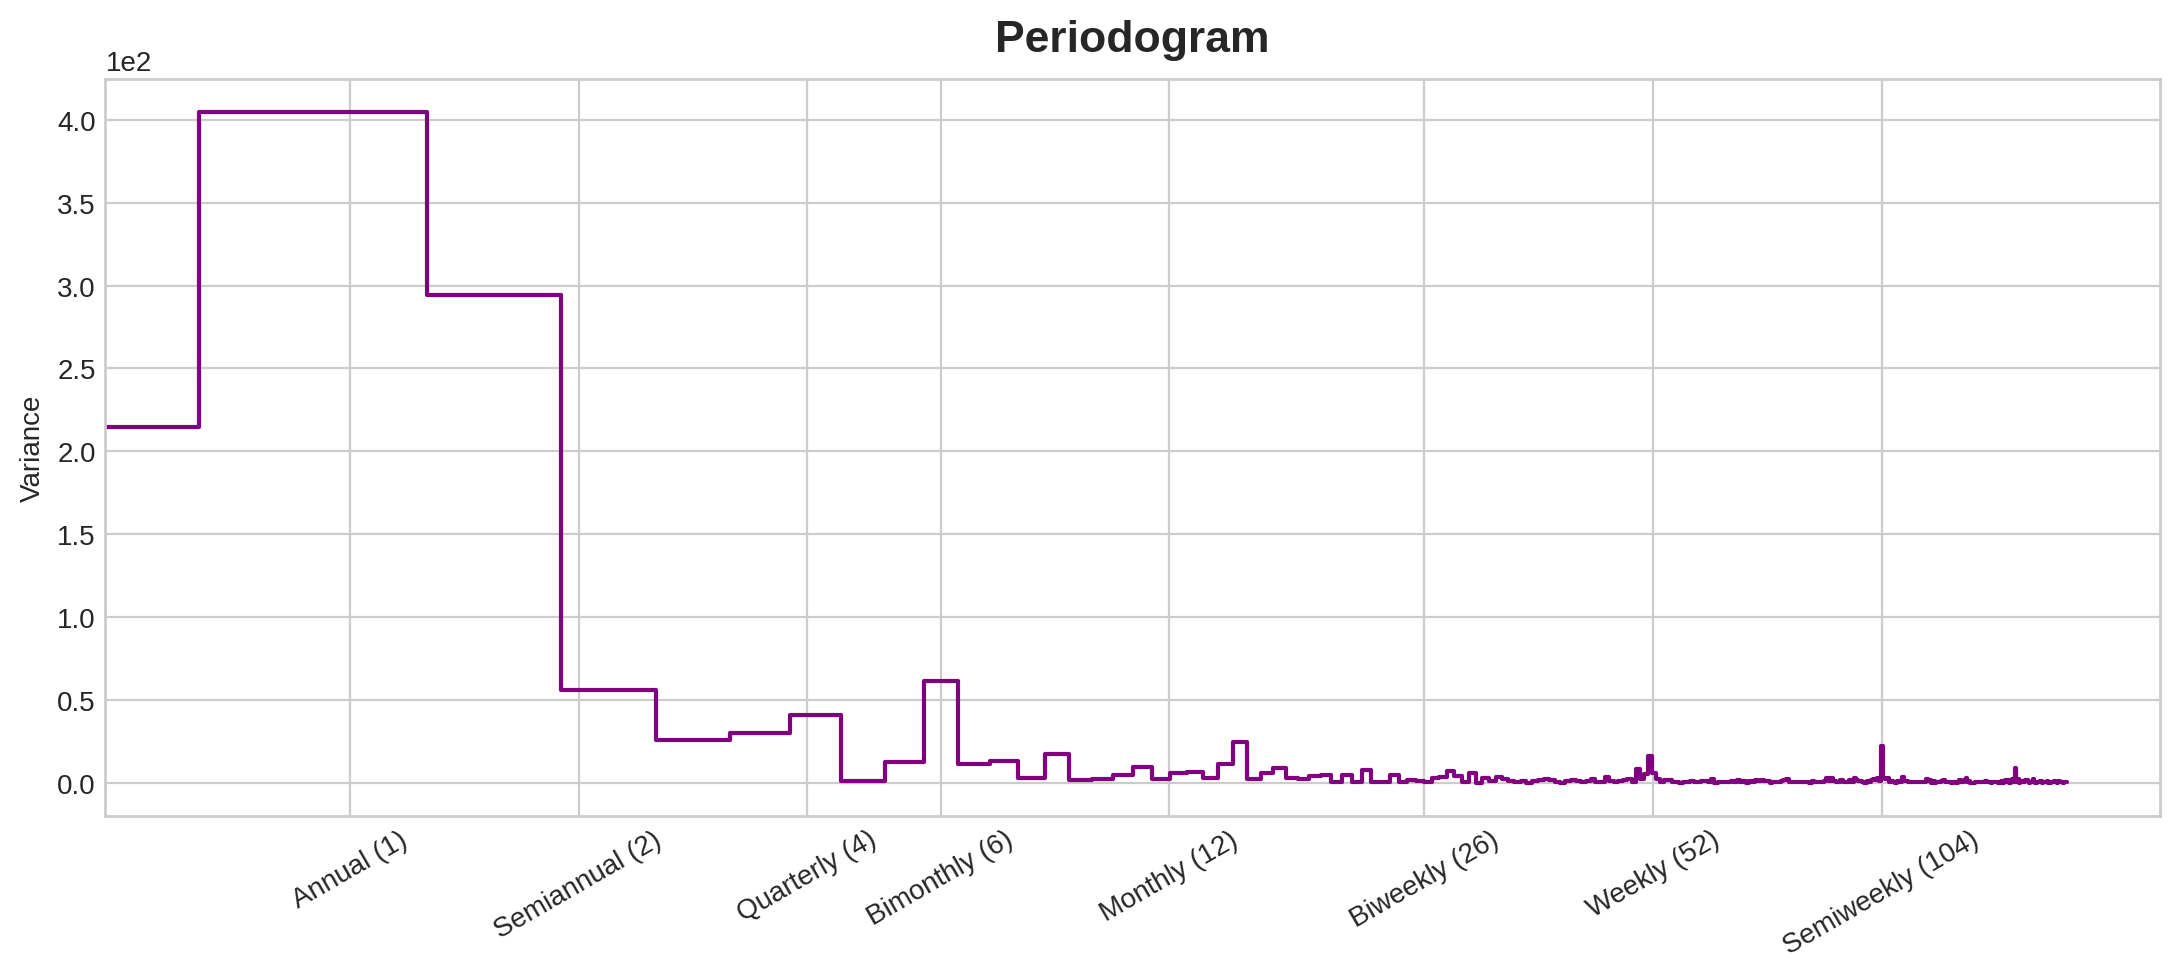

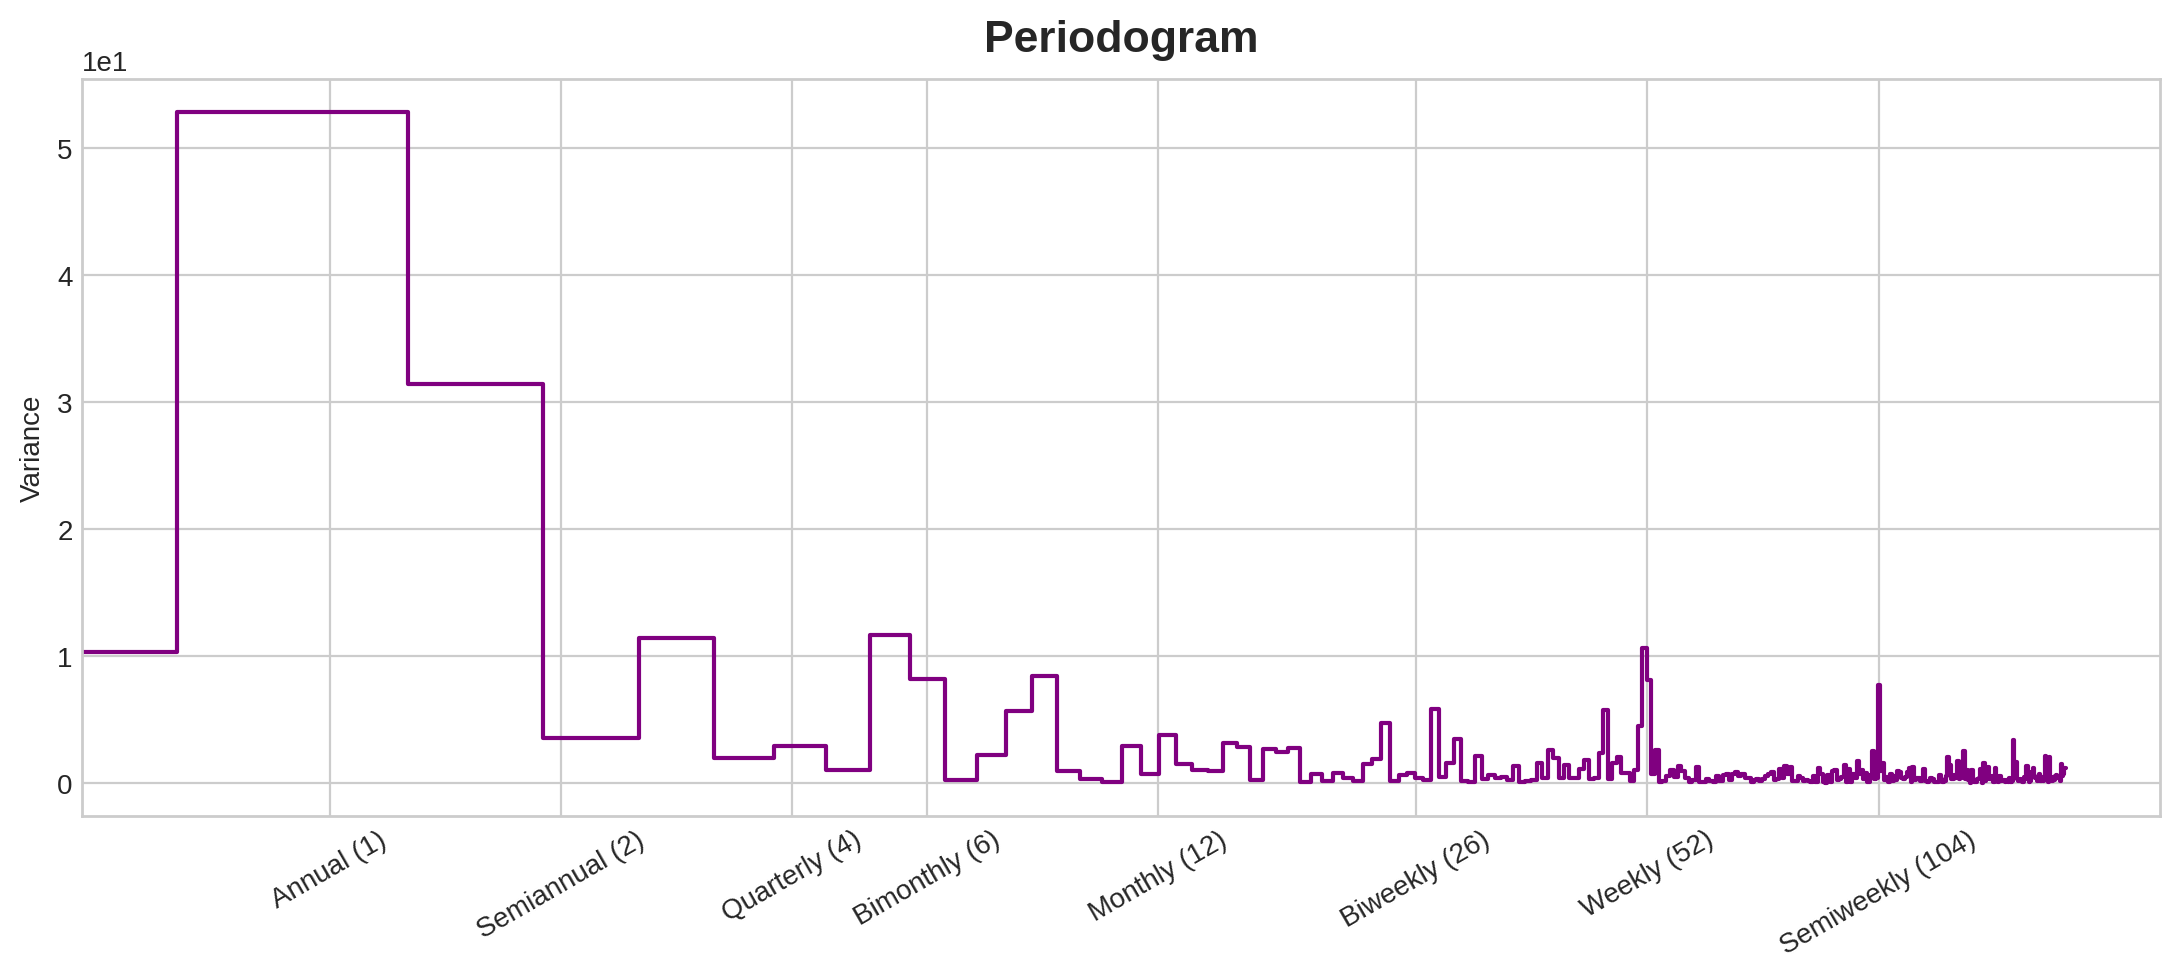

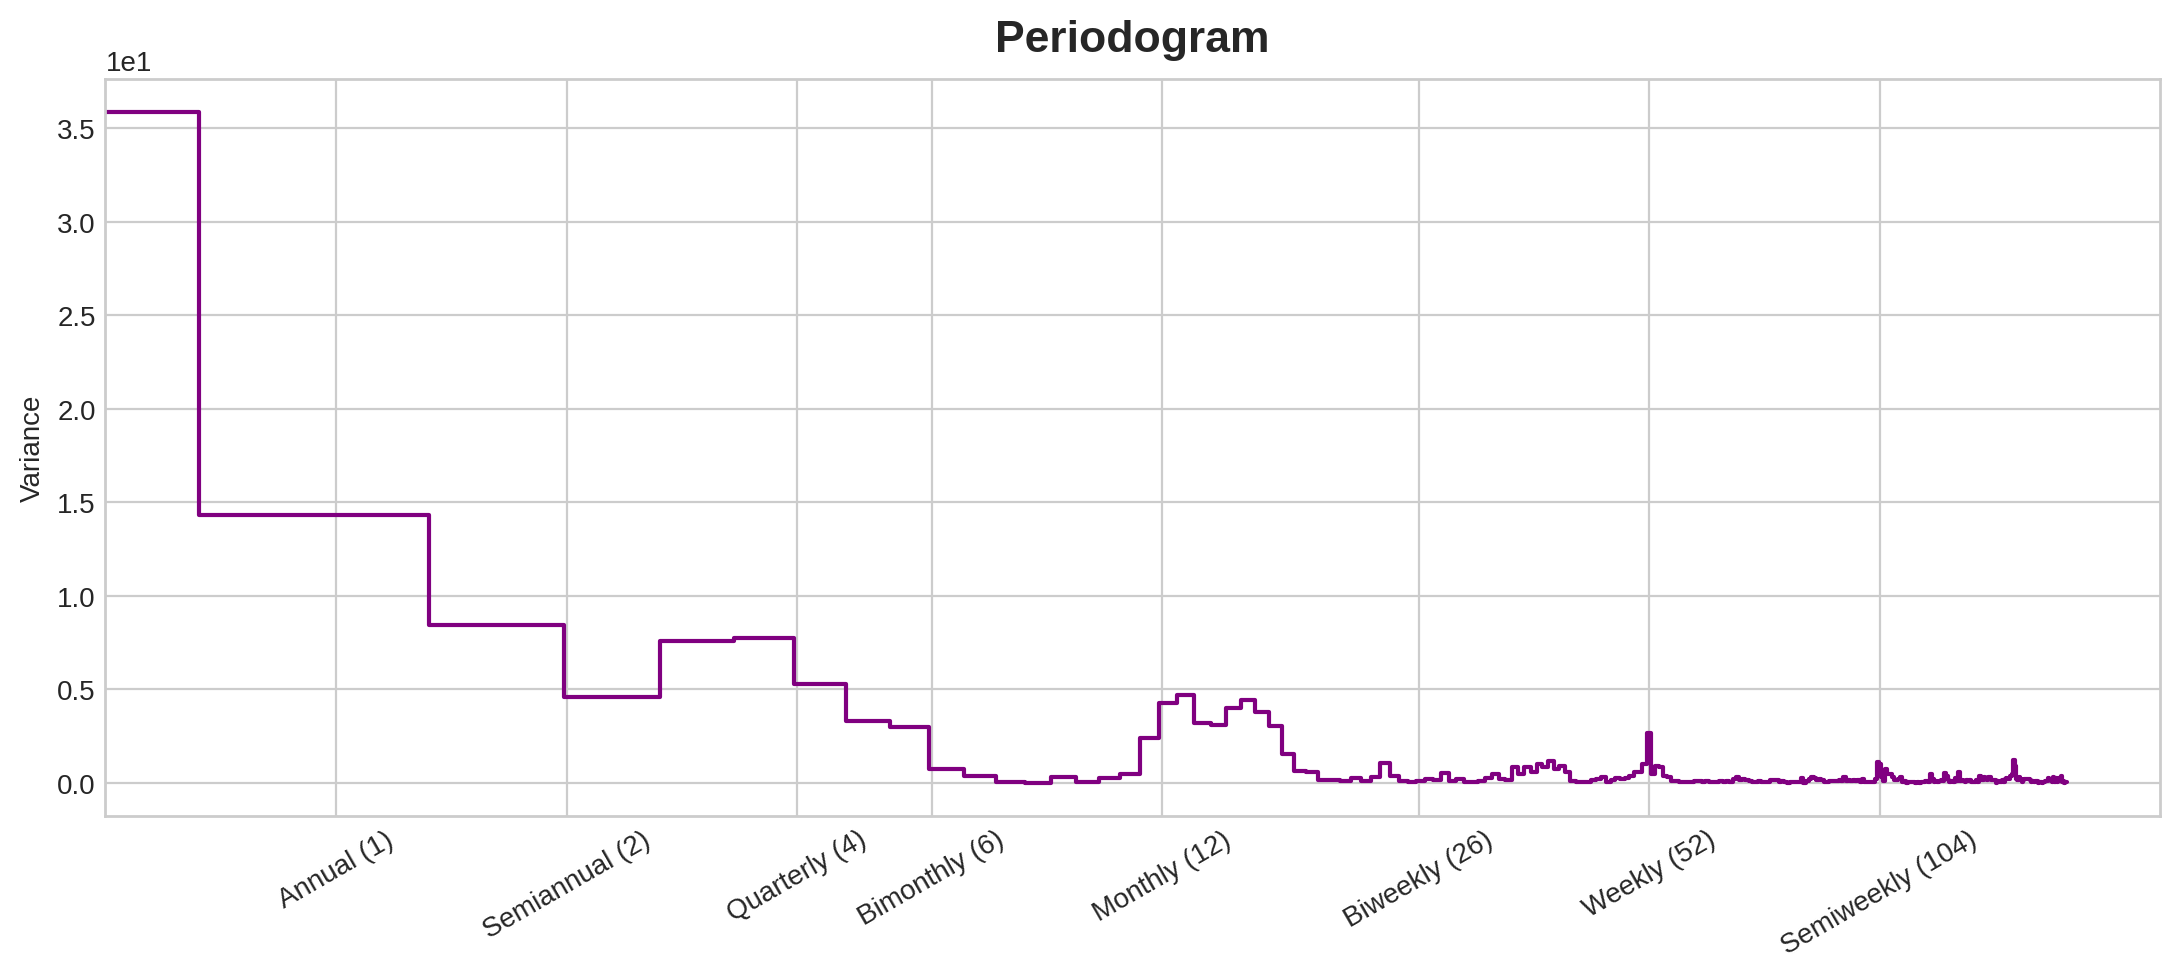

In [479]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


for i in unique_style_group:
    train_1 = df[df.style_group == i][['transaction_date', 'units_sold']]
    plot_periodogram(train_1.units_sold, detrend='linear')

#### Mostly quarterly seasonality(frequency = 4)

- From right to left, the periodogram falls off between Bimonthly (6) and quarterly (12), so let's use 4 Fourier pairs of frequency 4
- So it will create 8 new features based on the seasonality



In [480]:
#Seasonal feature generator

def fourier_features(index, freq, order):

    '''create fourier features for a given frequency and order '''
    
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
train_1 = df[df.style_group == style_group][['transaction_date', 'units_sold']]
fourier_features(train_1.units_sold, freq=4, order=4)

sin_4_1       cos_4_1       sin_4_2  cos_4_2       sin_4_3  \
units_sold                                                                    
18          0.000000e+00  1.000000e+00  0.000000e+00      1.0  0.000000e+00   
22          1.000000e+00 -4.371139e-08 -8.742278e-08     -1.0 -1.000000e+00   
19         -8.742278e-08 -1.000000e+00  1.748456e-07      1.0 -2.384976e-08   
44         -1.000000e+00  1.192488e-08 -2.384976e-08     -1.0  1.000000e+00   
22          1.748456e-07  1.000000e+00  3.496911e-07      1.0  4.769952e-08   
...                  ...           ...           ...      ...           ...   
16          4.550691e-05  1.000000e+00  9.101383e-05      1.0  7.548559e-05   
18          1.000000e+00 -4.996137e-05 -9.992273e-05     -1.0 -1.000000e+00   
23         -5.441582e-05 -1.000000e+00  1.088316e-04      1.0 -1.022123e-04   
37         -1.000000e+00 -2.164878e-06  4.329756e-06     -1.0  1.000000e+00   
37          2.289577e-06  1.000000e+00  4.579154e-06      1.0 -1.152016e-04   

                 cos_4_3       sin_4_4  cos_4_4  
units_sold                                       
18          1.000000e+00  0.000000e+00      1.0  
22          1.192488e-08  1.748456e-07      1.0  
19         -1.000000e+00  3.496911e-07      1.0  
44         -3.577464e-08  4.769952e-08      1.0  
22          1.000000e+00  6.993822e-07      1.0  
...                  ...           ...      ...  
16          1.000000e+00  1.820277e-04      1.0  
18          8.884895e-05  1.998455e-04      1.0  
23         -1.000000e+00  2.176633e-04      1.0  
37          1.285649e-04 -8.659513e-06      1.0  
37          1.000000e+00  9.158308e-06      1.0  

[577 rows x 8 columns]

### Feature Engineering

#### We will generate following features for time series forecasting

- Temporal features: day, month, year, day of week, week of year, quarter etc.
- Holiday flag
- FFT features(as described above)
- trend features: linear_trend, rolling mean

#### Processor

- Binary encoder for categorical features
- One hot encoding for categorical features

In [6]:
selected_feats = ['style_color_group', 'style_group','transaction_date',
       'level3', 'level4', 'units_sold',
       'final_price', 'is_promotion']

train = train[selected_feats]

class FeatureProcessor(TransformerMixin,BaseEstimator,RegressorMixin):
    
    """
    Feature Engineering class.

    Args:
        params: 
            X:style_color_group level transaction data

    Returns:
        a) style_color_group level Featurized(date and daily price) data
    """
    
    def transform(self,X):

        '''Method for feature collection and aggregation'''

        X = self.add_date_feats(X)
        FFT = self.add_seasonal_features(X)
        trend_MA = self.add_trend_MA_feats(X)
        X = pd.concat([X.reset_index(drop=True),FFT.reset_index(drop=True),trend_MA.reset_index(drop=True)],axis=1).\
            drop(['transaction_Elapsed','transaction_Dayofyear'],axis=1)
        X = self.binarize_cat(X)
        X = self.ohe_cat(X)
        return X

    def add_date_feats(self,X):

        '''Method to extract date features'''
        
        X['transaction_date'] = pd.to_datetime(X['transaction_date'])
        X['holiday_flag'] = X['transaction_date'].apply(lambda x: 0 if holidays.DE().get(x) is None else 1)
        date = X['transaction_date'] 
        X = add_datepart(X,'transaction_date')
        X = pd.concat([X,date],axis=1)
        return X
    
    def add_seasonal_features(self,X):

        '''method to extract FFT(fast fourier transform) based seasonal features'''
        
        y = X[['units_sold','transaction_date']]
        def fourier_features(index, freq, order):
            time = np.arange(len(index), dtype=np.float32)
            k = 2 * np.pi * (1 / freq) * time
            features = {}
            for i in range(1, order + 1):
                features.update({
                    f"sin_{freq}_{i}": np.sin(i * k),
                    f"cos_{freq}_{i}": np.cos(i * k),
                })
            return pd.DataFrame(features, index=index)
        #to capture quarterly seasonality
        FFT = fourier_features(y, freq=4, order=4)
        return FFT
    
    def add_trend_MA_feats(self,X):

        '''method to extract FFT(fast fourier transform) based seasonal features'''

        y = X[['units_sold','transaction_date']]
        #trend feature
        dp = DeterministicProcess(
        index=y.index,  # dates from the training data
        order=1,             # the time dummy (trend)
        drop=True,           # drop terms if necessary to avoid collinearity
    )

        trend = dp.in_sample()
        
        #MA feature
        moving_average = y.rolling(
        window=52,       # 365-day window
        center=True,      # puts the average at the center of the window
        min_periods=26,  # choose about half the window size
    ).mean()           
        X = pd.concat([trend,moving_average],axis=1)
        X.columns = ['trend','MA']
        return X
    
    def binarize_cat(self,X):

        '''Method for binary categorical features'''

        bin_col = ['transaction_Is_month_end',
       'transaction_Is_month_start', 'transaction_Is_quarter_end',
       'transaction_Is_quarter_start', 'transaction_Is_year_end',
       'transaction_Is_year_start']
        bin = sklearn.preprocessing.LabelBinarizer()
        X[bin_col] = bin.fit_transform(X[bin_col])
        X['transaction_Year'] = np.where(X['transaction_Year'] == '2022',0,1)
        return X

    def ohe_cat(self,X):

        '''Method for onehot encode of categorical features'''

        cat_col = ['transaction_Month','transaction_Dayofweek']
        ohe = sklearn.preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(X[cat_col])
        x = ohe.transform(X[cat_col])
        x = pd.DataFrame(x)
        x.columns = ohe.get_feature_names_out()
        X = pd.concat([X.drop(cat_col,axis=1).reset_index(drop=True),x],axis=1)  
        return X 

#### Illustraion- feature Engg. pipeline

In [7]:
pd.set_option('mode.chained_assignment', None)
unique_style_group = train.style_group.unique()
train_1 = train[train['style_group'] == unique_style_group[1]]
fp = FeatureProcessor()
df1 = fp.transform(train_1)
display(df1.head(1))

style_color_group  \
0  87d85321d82e8f4fa5da85797da9281aea9c179aab7e1cf223a363b21f513ccb   

                                                        style_group    level3  \
0  f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4  Trousers   

  level4  units_sold  final_price  is_promotion  holiday_flag  \
0   long           0        59.99             0             0   

   transaction_Year  transaction_Week  ...  transaction_Month_10  \
0                 1                 4  ...                   0.0   

   transaction_Month_11  transaction_Month_12  transaction_Dayofweek_0  \
0                   0.0                   0.0                      0.0   

   transaction_Dayofweek_1  transaction_Dayofweek_2  transaction_Dayofweek_3  \
0                      0.0                      1.0                      0.0   

  transaction_Dayofweek_4  transaction_Dayofweek_5  transaction_Dayofweek_6  
0                     0.0                      0.0                      0.0  

[1 rows x 47 columns]

### Stationarity Check 

In [483]:
style_group
adf_stat = {}
for style_group in unique_style_group[0:5]:
    print(style_group)
    train_1 = df[df.style_group == style_group]
    print(train_1.shape)
    train_1 = fp.transform(train_1)[['transaction_date','units_sold']]
    train_1 = train_1.set_index('transaction_date')
    grpd_weekly = train_1.resample('W').sum()
    result = adfuller(grpd_weekly.values.flatten())
    print(f'ADF Statistic: {result[0]}')
    
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    adf_stat[i] = {'pval':result[1],'adf_val':result[0],'critical_value':list(result[4].values())} 
display(adf_stat)

2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5
(458, 6)
ADF Statistic: -7.017222789089639
p-value: 6.684367004193042e-10
Critial Values:
   1%, -3.552928203580539
Critial Values:
   5%, -2.9147306250000002
Critial Values:
   10%, -2.595137155612245
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f
(577, 6)
ADF Statistic: -2.2336780437307806
p-value: 0.1942500582630422
Critial Values:
   1%, -3.512738056978279
Critial Values:
   5%, -2.8974898650628984
Critial Values:
   10%, -2.585948732897085
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0
(536, 6)
ADF Statistic: -1.5540137521020163
p-value: 0.5066426650891621
Critial Values:
   1%, -3.520713130074074
Critial Values:
   5%, -2.9009249540740742
Critial Values:
   10%, -2.5877813777777776
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37
(458, 6)
ADF Statistic: -2.867113297921334
p-value: 0.04930810645954987
Critial Values:
   1%, -3.5352168748293127
Critial Values:
   5%,

{'f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4': {'pval': 6.397690051832154e-05,
  'adf_val': -4.763005083323375,
  'critical_value': [-3.5117123057187376,
   -2.8970475206326833,
   -2.5857126912469153]}}

#### For few products series is not stationary, so may have to make the time series closer to being stationary may have to deseasonalize and detrend during forecasting pipeline.

## Time Series Forecasting

### Framework
- We will use sktime for time series forecasting with base estimator to convert time series to tabular data regression problem
- sktime is a unified framework for machine learning with time series, which takes care of feature extraction based on windowing, so we do not need to do it manually calculate the lag features.So sktime extracts the lag features automatically based on the windowing strategy.

![Screenshot from 2023-10-26 18-48-15.png](<attachment:Screenshot from 2023-10-26 18-48-15.png>)

- There are different Windowing(make_reduction) Strategy

a) "recursive“(Default, one at a time at forecasting horizon based on latest)

b) "multioutput“(Single estimator capable of handling multioutput targets is fitted to all the future steps in the forecasting horizon)

c)"direct“(separate forecaster is fitted for each step ahead of the forecasting horizon.)

- Also with different window based cross-validation strategy

![Screenshot from 2023-10-26 18-49-56.png](<attachment:Screenshot from 2023-10-26 18-49-56.png>)

### Design
 - Style-group specific Models- With this we have flexibility to roll up the forecast in level4 and level3
 - Unit of data- Daily level- With this we have flexibility to roll up the forecast in weekly, monthly, quarterly etc.
 - forecasting is for last 2 weeks(14 days) and model trained on rest of the data(for each product)
 - For quick implementation assume quarterly and additive quarterly seasonality and Polynomial trend of degree 1
 - I used TransformedTargetForecaster from sktime to build Forecasting pipeline using default XGBoost as regressor
 - To make things simple, I built seperate model(local model) for each Style-group instead of one global model.
 
 ### Assumption
  - A) Daily final_price will be available during forecasting period
  - B) Alternatively next day forecasting can be done based on last day price level

### Performance Evaluation
  - A) MAPE(Mean Absolute Percentage Error) generally is used as performance metric, however sMAPE is a better metric than MAPE to avoid dealing with an unbounded metric.
  - B) sMAPE is symmetric, so it doesn't matter if the actuals are higher or lower than the forecast, the error is treated the same way.
  - C) sMAPE and MAPE are scale independent, so it can be used to compare forecasts across different products.
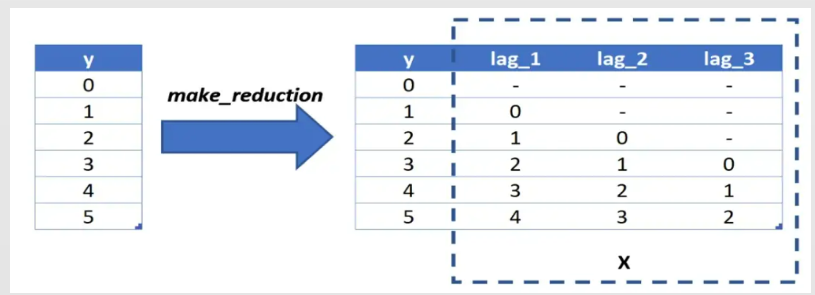
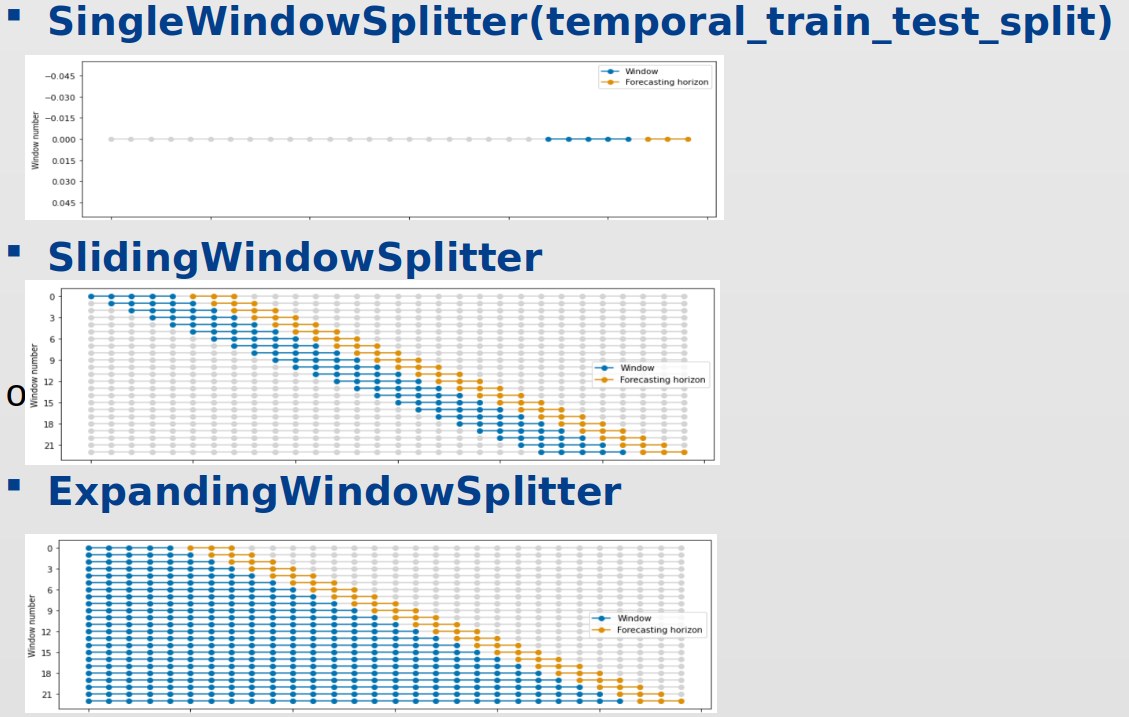

#### Model training and Evaluation pipeline

In [24]:
path = '../models'
class Model_train_prediction(TransformerMixin,RegressorMixin,BaseEstimator):

    '''Class for building model and prediction including evaluation
        Input: Product level Featurized data at daily level
    '''
    
    def __init__(self,window_len, test_size,path):

       '''test_size- Period of Forecasting(2 weeks)
          window_len- number of lags sliding window transformation  
       ''' 
       self.test_size = test_size 
       self.window_len = window_len
       self.path = path
       if not os.path.exists(self.path):
            os.makedirs(self.path)


    def data_prep(self,data):

        '''Method to create train and test data'''

        X = data[x_feats]
        Y = data[[target]]
        train_y, test_y,train_x, test_x = temporal_train_test_split(y=Y,X=X,test_size=self.test_size)
        return train_y, test_y,train_x, test_x

    def model_train(self,train_x, train_y,test_y):

        '''Method to train Model using grid search'''

        fh = ForecastingHorizon(values=test_y.index,is_relative=False)

        #estimator- XGBoost Regressor
        regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300,\
                                      learning_rate=0.05, n_jobs=-1,random_state=42,\
                                        max_depth=4,subsample=0.8,colsample_bytree=0.6)
        
        #grid search parameters
        param_grid = {'estimator__max_depth':[3,4],
                      'window_length':[15,30],
                      'estimator__learning_rate':[0.05,0.1],
                      'estimator__subsample':[0.7,0.8],
                      'estimator__colsample_bytree':[0.5,0.6,0.7]}
        
        #Forecasting pipeline with deseasonalizer, detrender and regressor 
        #this window_len defines the lagged unit_sold feature the forecaster will extract
        forecaster = TransformedTargetForecaster([
        ("deseasonalize",Deseasonalizer(model="additive",sp = 90)),
        ("dtrend",Detrender(forecaster = PolynomialTrendForecaster(degree=1))),
        ("forecast", MultioutputTabularRegressionForecaster(estimator=regressor,window_length=self.window_len)),
    ])
        forecaster = MultioutputTabularRegressionForecaster(estimator=regressor,window_length=self.window_len)

        #fitting with grid search
        cv = SlidingWindowSplitter(initial_window=30, window_length=15)
        forecaster = ForecastingRandomizedSearchCV(forecaster,\
                                             n_jobs=-1,verbose=1,n_iter=5,param_distributions=param_grid,cv=cv)
        forecaster.fit(y=train_y,X=train_x,fh = fh)
        return forecaster,fh

    def make_forecast(self, forecaster, test_x, fh):

        """Method for Forecasting and make negative values to zero"""

        pred_y = round(forecaster.predict(X=test_x, fh=fh), 0)
        pred_y = np.where(pred_y <= 0, 0, pred_y)
        pred_y = pd.DataFrame(pred_y)
        pred_y.columns = ['units_sold']
        return pred_y

    def evaluate(self,test_y,pred_y):

        '''Method to evaluate Forecasting result'''

        def MAPE(Y_actual,Y_Predicted):

            """Mean Absolute Percentage Error with 0.1 added to denominator to avoid division by zero"""
            mape = np.mean(np.abs((Y_actual - Y_Predicted)/(Y_actual + 0.1)))*100
            return mape[0]

        def calculate_smape(actual, predicted) -> float: 

            """Symmetric mean absolute percentage error with 0.1 added to denominator to avoid division by zero"""
  
            return round( 
                np.mean( 
                    np.abs(predicted - actual) / 
                    ((np.abs(predicted) + np.abs(actual) + 0.1)/2) 
                )*100, 2,
            )[0] 
        
        mape = MAPE(test_y,pred_y)
        mae = sklearn.metrics.mean_absolute_error(test_y,pred_y)
        smape = calculate_smape(test_y,pred_y)
        return mape,mae,smape
    

### Feature Importance and analysis- we can have an estimation by fitting the estimator

- We start with all features and with insight of feature importance we can have a better understanding of feature selection
- As I build local model for each style_group, I don't need to use 'month_of_launch','season_start_date', 'season_end_date','current_season', 'initial_season' as they are style_group specific

In [9]:
x_feats = ['final_price', 'is_promotion', 'holiday_flag', 'transaction_Year',
       'transaction_Week', 'transaction_Day', 'transaction_Is_month_end',
       'transaction_Is_month_start', 'transaction_Is_quarter_end',
       'transaction_Is_quarter_start', 'transaction_Is_year_end',
       'transaction_Is_year_start','sin_4_1', 'cos_4_1',
       'sin_4_2', 'cos_4_2', 'sin_4_3', 'cos_4_3', 'sin_4_4', 'cos_4_4',
       'trend', 'MA', 'transaction_Month_1', 'transaction_Month_2',
       'transaction_Month_3', 'transaction_Month_4', 'transaction_Month_5',
       'transaction_Month_6', 'transaction_Month_7', 'transaction_Month_8',
       'transaction_Month_9', 'transaction_Month_10', 'transaction_Month_11',
       'transaction_Month_12', 'transaction_Dayofweek_0',
       'transaction_Dayofweek_1', 'transaction_Dayofweek_2',
       'transaction_Dayofweek_3', 'transaction_Dayofweek_4',
       'transaction_Dayofweek_5', 'transaction_Dayofweek_6']
target = 'units_sold'

Optimized Parameters
{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 4, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 300, 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Optimized window length
30


feature  importance  cum_importance
21                            MA    0.149731        0.149731
20                         trend    0.091824        0.241556
0                    final_price    0.081977        0.323533
23           transaction_Month_2    0.080264        0.403797
4               transaction_Week    0.074329        0.478126
24           transaction_Month_3    0.069488        0.547615
1                   is_promotion    0.060871        0.608485
22           transaction_Month_1    0.050271        0.658756
5                transaction_Day    0.049713        0.708469
40       transaction_Dayofweek_6    0.029696        0.738164
19                       cos_4_4    0.020311        0.758475
36       transaction_Dayofweek_2    0.019884        0.778359
18                       sin_4_4    0.018954        0.797313
39       transaction_Dayofweek_5    0.018874        0.816187
34       transaction_Dayofweek_0    0.016779        0.832967
26           transaction_Month_5    0.016110        0.849077
7     transaction_Is_month_start    0.013801        0.862878
17                       cos_4_3    0.012880        0.875758
25           transaction_Month_4    0.012710        0.888468
27           transaction_Month_6    0.012231        0.900699
2                   holiday_flag    0.010320        0.911019
35       transaction_Dayofweek_1    0.010102        0.921121
12                       sin_4_1    0.009946        0.931067
14                       sin_4_2    0.008147        0.939215
16                       sin_4_3    0.006595        0.945810
13                       cos_4_1    0.006312        0.952121
37       transaction_Dayofweek_3    0.006217        0.958338
38       transaction_Dayofweek_4    0.006053        0.964391
31          transaction_Month_10    0.004936        0.969327
15                       cos_4_2    0.004781        0.974109
30           transaction_Month_9    0.004771        0.978880
32          transaction_Month_11    0.004655        0.983535
6       transaction_Is_month_end    0.004354        0.987889
8     transaction_Is_quarter_end    0.004301        0.992190
29           transaction_Month_8    0.003786        0.995976
28           transaction_Month_7    0.003232        0.999208
9   transaction_Is_quarter_start    0.000792        1.000000
10       transaction_Is_year_end    0.000000        1.000000
33          transaction_Month_12    0.000000        1.000000
11     transaction_Is_year_start    0.000000        1.000000
3               transaction_Year    0.000000        1.000000

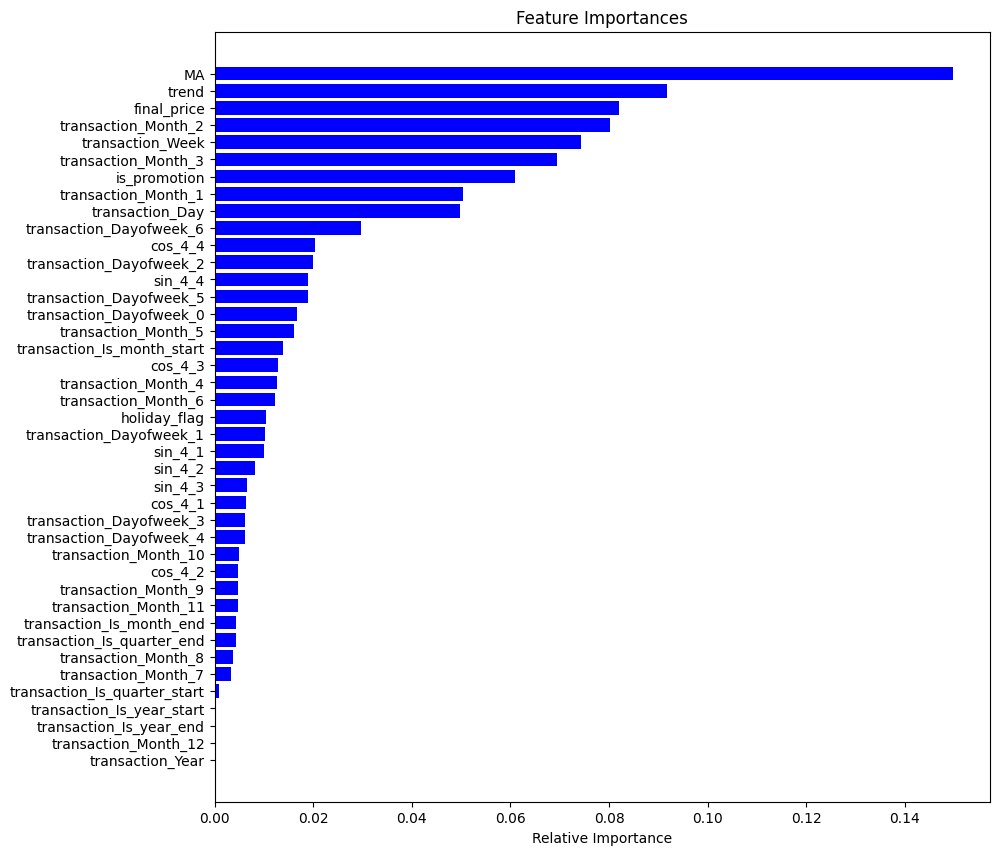

In [27]:
path = '../models'
cols_to_drop = ['sales_price','style_color_group', 'style_group', 'level3', 'level4', 'units_sold','transaction_date']
target = 'units_sold'
cols = list(df.columns)
x_feats = [x for x in df1.columns if x not in cols_to_drop]
mtp = Model_train_prediction(window_len=30, test_size=14,path = path)
train_y, test_y,train_x, test_x = mtp.data_prep(df1)
forecaster,fh = mtp.model_train(train_x, train_y,test_y)

#fitting the estimator
forecaster.estimator.fit(train_x,train_y)

#Grid search best parameters
print('Optimized Parameters')
print(forecaster.estimator_.get_params())
print('Optimized window length')
print(forecaster.window_length_)

#feature importance plot and table.make a figsize of 10,10
fig, ax = plt.subplots(figsize=(10,10))
importance = forecaster.estimator.feature_importances_
indices = np.argsort(importance)
features = train_x.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

#also create a table of feature importance with names and values in descending order
feature_importance = pd.DataFrame({'feature':train_x.columns,'importance':forecaster.estimator.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False)
feature_importance['cum_importance'] = feature_importance['importance'].cumsum()
display(feature_importance)

#### Feature importance & Selection

- As expected moving average of sales,promotion,trend, price and a few temporal features emerged as important features
- We select features which constitute  > 98% of the variance in the data

In [16]:
#drop the least important features have values cum_importance > 0.98

drop_cols = list(feature_importance[feature_importance['cum_importance'] > 0.98]['feature'])
x_feats = [x for x in x_feats if x not in drop_cols]


### Orchestrating the pipeline

In [109]:

path = '../models'
evaluation_metric = {}
prediction = {}
actual = {}
if __name__ == '__main__':
    mtp = Model_train_prediction(window_len=30, test_size=14,path = path)
    for i in unique_style_group:
        fp = FeatureProcessor()
        train_feat = fp.transform(df[df.style_group==i])
        train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
        forecaster,fh = mtp.model_train(train_x, train_y,test_y)
        with open(os.path.join(path, f'item_{i}.pkl'),'wb') as f:
            pickle.dump(forecaster,f)
        pred_y = mtp.make_forecast(forecaster,test_x,fh)
        prediction[i] = list(pred_y.units_sold.values)
        actual[i] = list(test_y.units_sold.values)
        evaluation_metric[i] = mtp.evaluate(test_y.reset_index(drop=True),pred_y.reset_index(drop=True))
    actuals = pd.DataFrame(actual)
    actuals.columns = [f'actual_{i}' for i in actual.keys()]
    predictions = pd.DataFrame(prediction)
    predictions.columns = [f'prediction_{i}' for i in prediction.keys()]
    acutal_prediction = pd.concat([actuals,predictions],axis=1)
    acutal_prediction.to_csv(os.path.join(path, 'acutal_prediction.csv'),index=False) 
    acutal_prediction.head() 

### Forcasting Performance- Evaluation(Style-Group Hierarchy level)

##### Qualitative analysis- Actual vs. Forecast Curve

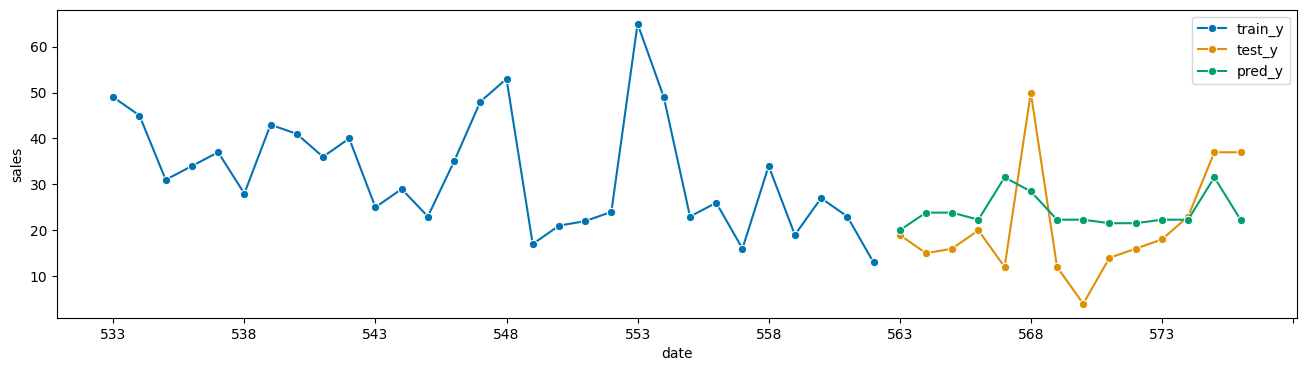

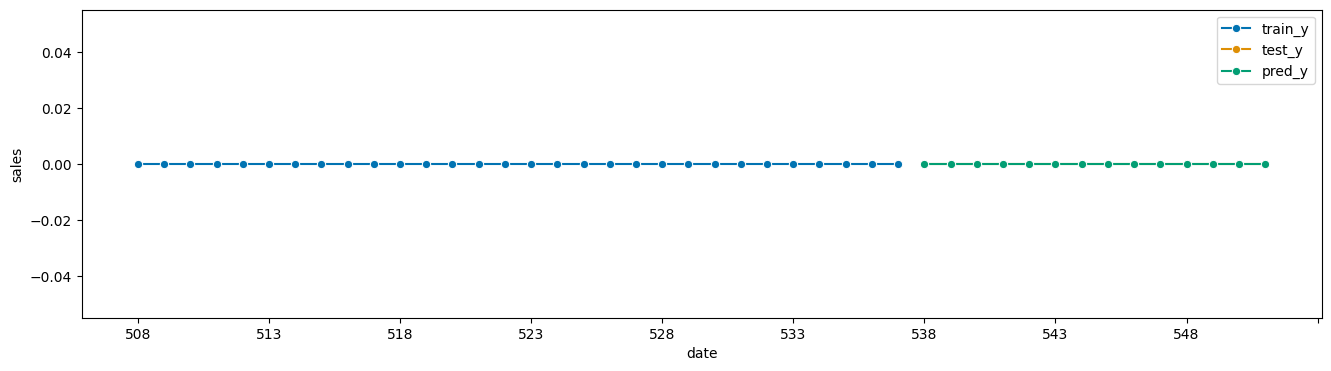

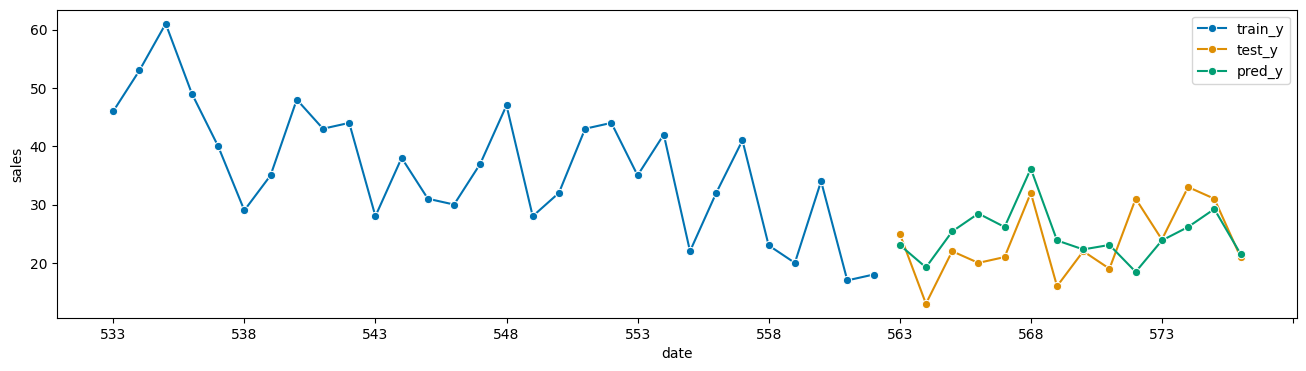

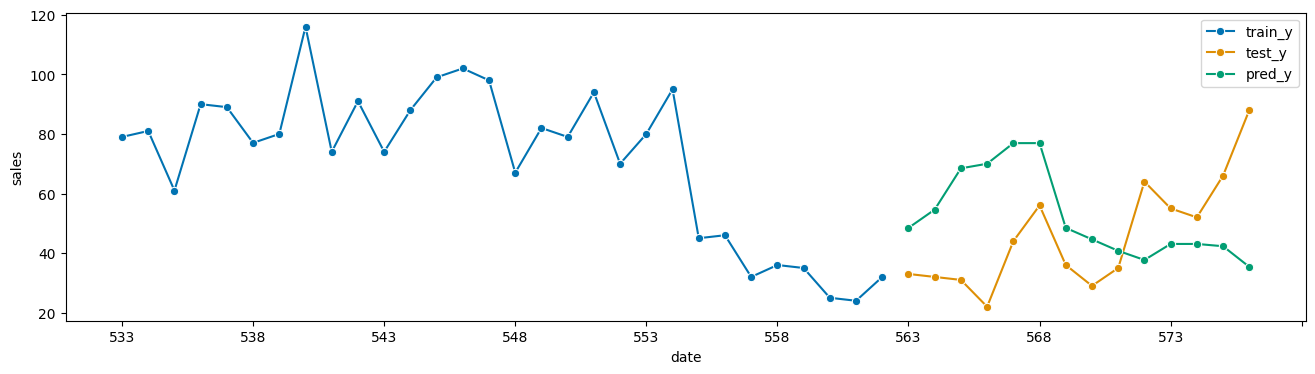

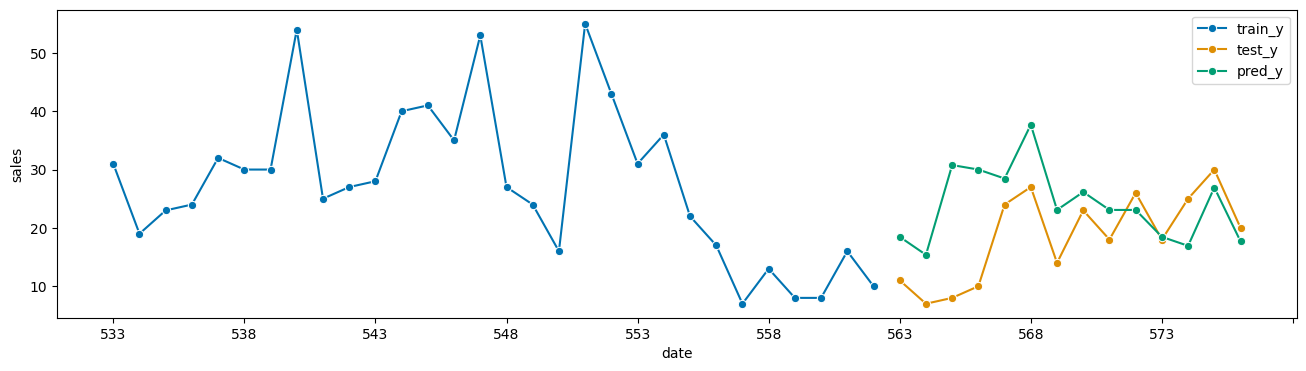

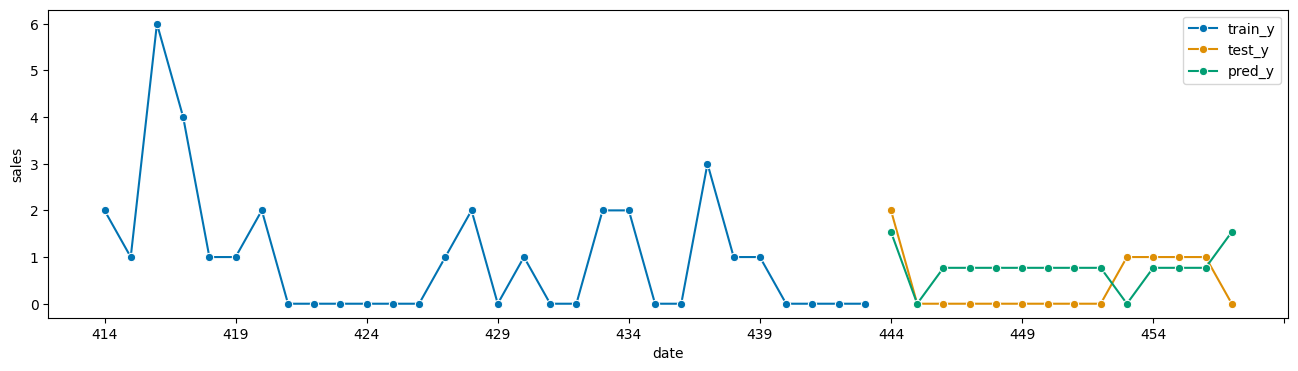

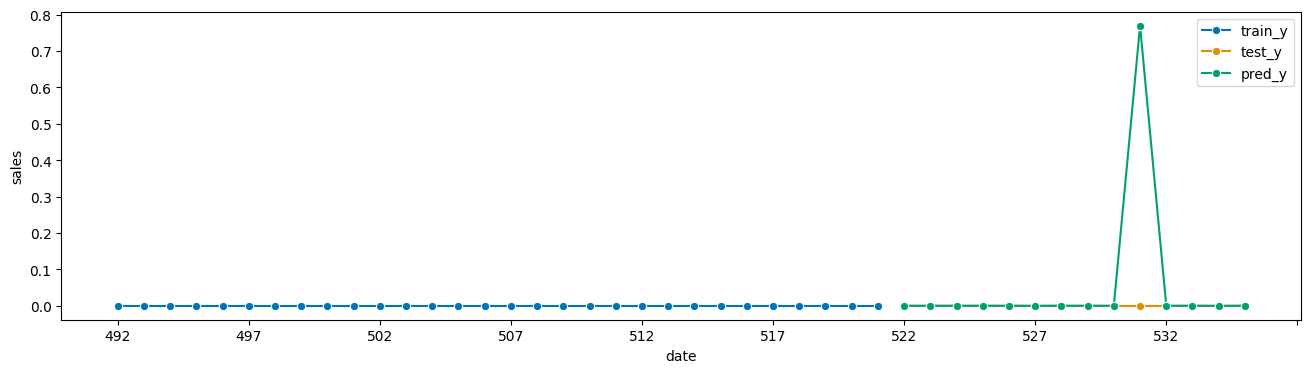

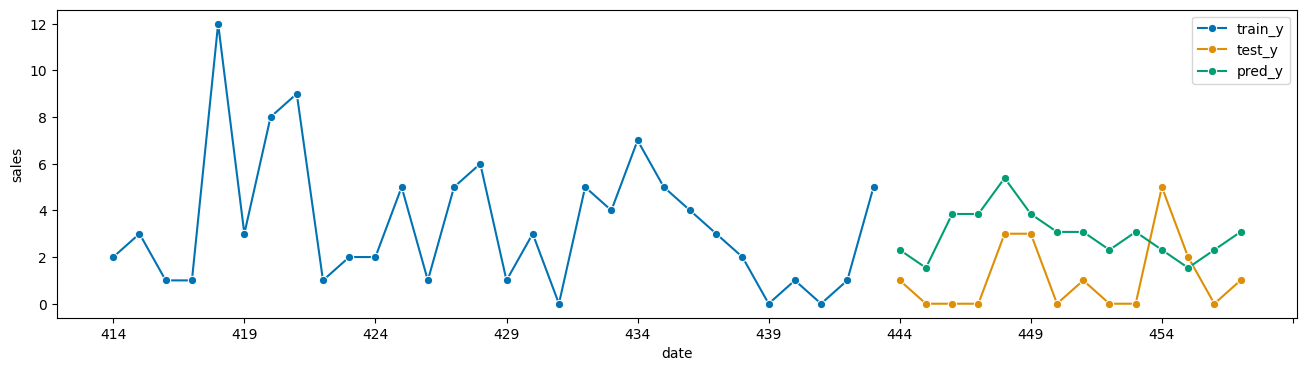

In [110]:
for i in unique_style_group:
    fp = FeatureProcessor()
    train_feat = fp.transform(df[df.style_group==i])
    train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
    pred_y = pd.DataFrame(prediction[i])
    pred_y = pred_y.set_index(test_y.index)
    plot_series(train_y[-30:], test_y, pred_y, labels = ['train_y','test_y','pred_y'],x_label = 'date',y_label = 'sales')

#### Quantitative analysis

In [33]:
## style_group level evaluation metric-daily

#make pandas dataframe of evaluation_metric

evaluation_metric = pd.DataFrame(evaluation_metric).T
evaluation_metric.columns = ['mape','mae','smape']
evaluation_metric['style_group'] = evaluation_metric.index

evaluation_metric = evaluation_metric.reset_index(drop=True)

#make style_group as first column
cols = list(evaluation_metric.columns)
cols = [cols[-1]] + cols[:-1]
evaluation_metric = evaluation_metric[cols]
evaluation_metric

style_group  \
0  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   
1  aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   
2  ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0   
3  ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37   
4  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   
5  e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac   
6  f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5   
7  f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4   

         mape        mae   smape  
0   71.428571   0.714286   61.90  
1   98.556136  13.571429   55.25  
2    7.142857   0.071429    7.14  
3  218.452381   2.928571  106.33  
4   99.608016  13.357143   56.67  
5   84.857042  31.571429   55.74  
6   44.557544   9.571429   34.80  
7    0.000000   0.000000    0.00

In [111]:
## Actual vs. Forecasted mean accross style_group

mean_forecast_vs_actual = {}
for i in unique_style_group:
    pred_y = prediction[i]
    test_y = actual[i]
    mean_forecast = np.mean(pred_y)
    mean_actual = np.mean(test_y)
    mean_forecast_vs_actual[i] = [mean_forecast, mean_actual]
mean_forecast_vs_actual = pd.DataFrame(mean_forecast_vs_actual).T
mean_forecast_vs_actual.columns = ['mean_forecast','mean_actual']
mean_forecast_vs_actual

mean_forecast  \
ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f      24.010986   
f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4       0.000000   
f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5      24.780218   
e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac      52.197807   
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f      24.010990   
2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5       0.769231   
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0       0.054945   
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37       2.967033   

                                                                  mean_actual  
ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    20.928571  
f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4     0.000000  
f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5    23.571429  
e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac    45.928571  
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f    18.642857  
2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5     0.428571  
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0     0.000000  
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37     1.142857

### Hierarchical Forecasting

##### We may roll it up to the level4 hierarchy and see the performance

##### Also we can aggregate the forecasted sales to weekly level and analyse the performance

##### Before that it's better to build the Inference pipeline to forecast for the next 14 days for all style_group

### Inference Pipeline

- Preparing data to forecast for next 14 days for all style_group

In [92]:
test_df = pd.DataFrame()
test_y_df = pd.DataFrame()
for i in unique_style_group:
    fp = FeatureProcessor()
    train_feat = fp.transform(df[df.style_group==i])
    train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
    test_y['style_group'] = i
    test_x['style_group'] = i
    test_y['day'] = range(1,15)
    test_df = test_df.append(test_x)
    test_y_df = test_y_df.append(test_y)
test_df.to_csv('../data/test_data.csv',index=False) 
test_y_df.to_csv('../data/test_data_y.csv',index=False) 

#### Pipeline

In [116]:
class Model_Inference(TransformerMixin,RegressorMixin,BaseEstimator):

    '''Class for using model for prediction
        Input: Featurized data at daily level
    '''
    def __init__(self,model_path):

       self.model_path = model_path 

    def collect_data_model(self,data):
        test_x = data.drop('style_group',axis=1)
        with open(self.model_path ,'rb') as fout:
            model= pickle.load(fout)
        return model,test_x    

    def make_forecast(self,model,test_x):

        '''Method for Forecasting'''

        pred_y = round(model.predict(fh = model.fh,X=test_x),0)
        pred_y = np.where(pred_y <= 0, 0, pred_y)
        pred_y = pd.DataFrame(pred_y)
        pred_y.columns = ['units_sold']
        return pred_y

#### Orchestration

In [138]:
path = '../forecast/'
model_path = '../models/'
predictions = pd.DataFrame()
if __name__ == '__main__':
    test_df = pd.read_csv(os.path.join('../data','test_data.csv'))
    for i in unique_style_group:
        test_x = test_df[test_df.style_group == i]
        prod_mod_path = os.path.join(model_path,f'item_{i}.pkl')
        mi = Model_Inference(model_path=prod_mod_path)
        model,test_x = mi.collect_data_model(test_x)
        pred = mi.make_forecast(model,test_x)
        pred = pd.DataFrame({'style_group':i,'forecast':pred.units_sold.values, 'day':list(range(1,15))})
        if not os.path.exists(path):
            os.makedirs(path)
        pred.to_csv(os.path.join(path,f'item_{i}.csv'),index=False)
        predictions = predictions.append(pred)
    predictions.to_csv(os.path.join(path,'all_style_prediction.csv'),index=False) 

predictions = pd.merge(test_y_df,predictions, on=['style_group','day'], how='left')
predictions.head()    

units_sold  \
0          19   
1          15   
2          16   
3          20   
4          12   

                                                        style_group  day  \
0  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    1   
1  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    2   
2  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    3   
3  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    4   
4  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    5   

    forecast  
0  18.571428  
1  22.142857  
2  22.142857  
3  20.714287  
4  29.285715

In [147]:
### Roll up prediction to level4

# predictions = pd.merge(predictions, train[['style_group','level3','level4']].drop_duplicates(), on='style_group', how='left')
predictions['abs_error'] = abs(predictions['units_sold'] - predictions['forecast'])

#adding a small value to denominator to avoid division by zero
predictions['abs_percentage_error'] = abs(predictions['units_sold'] - predictions['forecast'])/(predictions['units_sold'] + 0.2)
display(predictions.head())
print('overall MAPE at style_group level',np.mean(predictions['abs_percentage_error'])*100)

#actual vs. forecasted in level3

predictions_level3 = predictions.groupby(['level3','day'],as_index=False).agg({'units_sold':'sum','forecast':'sum'})
predictions_level3.columns = ['level3','day','actual','forecast']
predictions_level3['abs_error'] = abs(predictions_level3['actual'] - predictions_level3['forecast'])
predictions_level3['abs_percentage_error'] = abs(predictions_level3['actual'] - predictions_level3['forecast'])/predictions_level3['actual']

predictions_level3.head()
print('overall MAPE at level4',np.mean(predictions_level3['abs_percentage_error'])*100)

units_sold  \
0          19   
1          15   
2          16   
3          20   
4          12   

                                                        style_group  day  \
0  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    1   
1  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    2   
2  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    3   
3  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    4   
4  ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f    5   

    forecast    level3         level4  abs_error  abs_percentage_error  
0  18.571428  T-shirts  short-sleeved   0.428572              0.021755  
1  22.142857  T-shirts  short-sleeved   7.142857              0.454959  
2  22.142857  T-shirts  short-sleeved   6.142857              0.367836  
3  20.714287  T-shirts  short-sleeved   0.714287              0.034507  
4  29.285715  T-shirts  short-sleeved  17.285715              1.361080

overall MAPE at style_group level 61.01054257693856
overall MAPE at level4 44.186988376380434


#### Level3 wise predicted vs. actual sales plt day wise

level3  week  actual    forecast   abs_error  abs_percentage_error
0  T-shirts     1     394  500.000000  106.000000              0.269036
1  T-shirts     2     490  447.142853   42.857147              0.087464
2  Trousers     1     263  439.285736  176.285736              0.670288
3  Trousers     2     402  287.857147  114.142853              0.283937

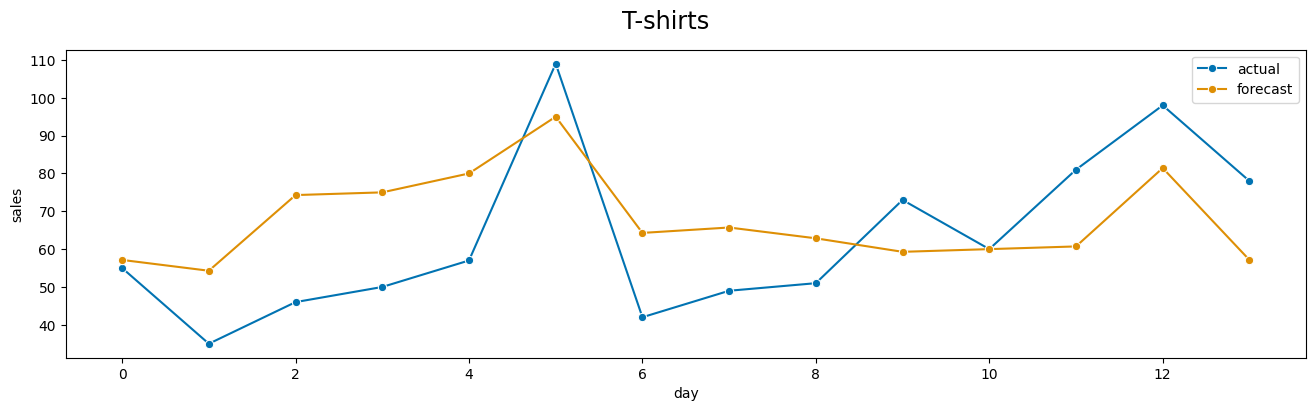

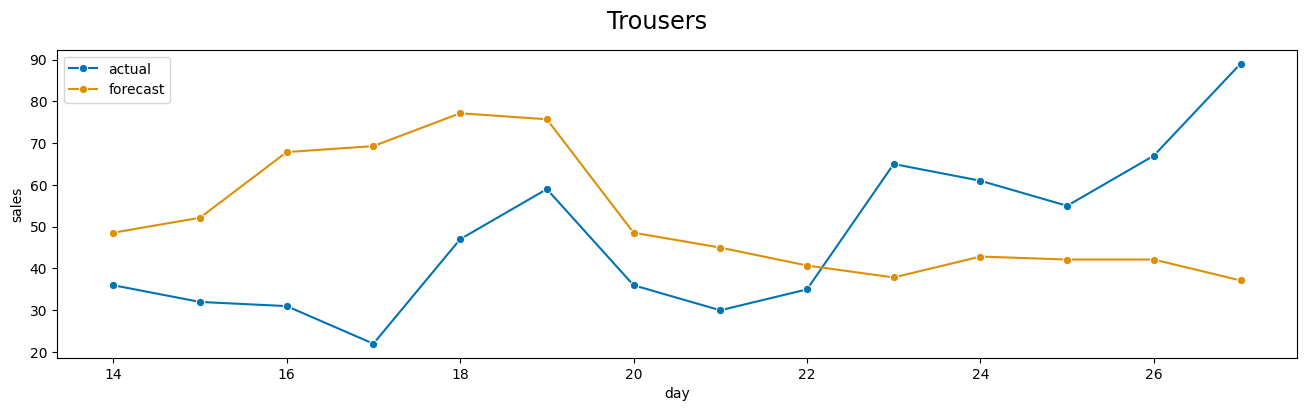

In [167]:
unique_level_3 = train['level3'].unique()
for i in unique_level_3:
    pred = predictions_level3[predictions_level3.level3 == i]   
    plot_series(pred.actual, pred.forecast, labels = ['actual','forecast'],x_label = 'day',y_label = 'sales',title = f'{i}')  

# roll it upto weekly level
predictions_level3['week'] = np.where(predictions_level3['day'] <= 7, 1,2)
predictions_level3_week = predictions_level3.groupby(['level3','week'],as_index=False).agg({'actual':'sum','forecast':'sum'})
predictions_level3_week.columns = ['level3','week','actual','forecast']
predictions_level3_week['abs_error'] = abs(predictions_level3_week['actual'] - predictions_level3_week['forecast'])
predictions_level3_week['abs_percentage_error'] = abs(predictions_level3_week['actual'] - predictions_level3_week['forecast'])/predictions_level3_week['actual']
predictions_level3_week.head()


### Improvement and Future work(with more time)

- A) Other base estimators like LightGBM, CatBoost, Random Forest, Linear Regression can be used to build the forecasting pipeline
- B) We can use different windowing strategy and cross-validation strategy,seasonality and trend
- C) A global model can be built instead of local model for each style_group to capture the intaction between style_group features(price, unit_sold etc.)

  a) Darts: Perhaps the most popular with almost all forecasting algorithms including cutting-edge DL(BlockRNNModel,NBEATSModel,NHiTSModel,TCNModel etc.)and transformer(TransformerModel,TFTModel etc.) based models.

  b) Nixtla(mlforecast): Global ML-based forecasting algorithms like LinearRegression, LightGBM or XGBoost, etc.

### Price Elasticity

#### Relationship with price and sales

In [6]:
price = df.groupby('style_group').agg({'final_price':['max','min','std','mean']})
price

final_price  \
                                                                         max   
style_group                                                                    
2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5       49.99   
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f       35.99   
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0       35.99   
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37       59.99   
ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f       15.99   
e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac       49.99   
f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5       15.99   
f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4       59.99   

                                                                             \
                                                                        min   
style_group                                                                   
2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5  37.450000   
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f  19.140000   
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0  17.020000   
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37  30.520000   
ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f  15.272500   
e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac  28.253333   
f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5  15.265000   
f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4  33.990000   

                                                                             \
                                                                        std   
style_group                                                                   
2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   3.875831   
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f   7.923533   
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0   6.346610   
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37  11.697022   
ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f   0.155975   
e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac  10.096140   
f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5   0.157122   
f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4   9.679040   

                                                                             
                                                                       mean  
style_group                                                                  
2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5  45.194316  
aaf7667ca5752231b549866a71566af86efde98725873ad6cc29dddcb389489f  29.867071  
ac7bc8f4cd09fea57a4ebb9cd46a83a105a9e0a04ff967e3f53a9ca8888f75e0  23.963881  
ba5b05b595b80b0c3eebfdbdc2aa82824576a2a28805c415815bd8d377c6db37  44.359148  
ca06da7963036e9655dfb97d44721e692b2cdd162484c3e67c0ac65c5ca2887f  15.848083  
e9c94746f2b7fd29eed8d34ee12dc8b9ae601d7d80046018a219bcb8436902ac  42.177735  
f04720b11a56c0af3e2cbadcfd1e99e0b74dfd7daba63720f958fea31ee85ab5  15.849791  
f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4  46.253037

style_group_  \
0  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   
1  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   
2  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   
3  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   
4  2661d00eab3a953d8e5c4c5d4fe325f7a03406e7f81ca0d6c0f7b150539a20d5   

  transaction_date_  final_price_mean  units_sold_sum  
0        2022-04-30             49.99               0  
1        2022-05-01             49.99               0  
2        2022-05-02             49.99               0  
3        2022-05-03             49.99               0  
4        2022-05-04             49.99               0

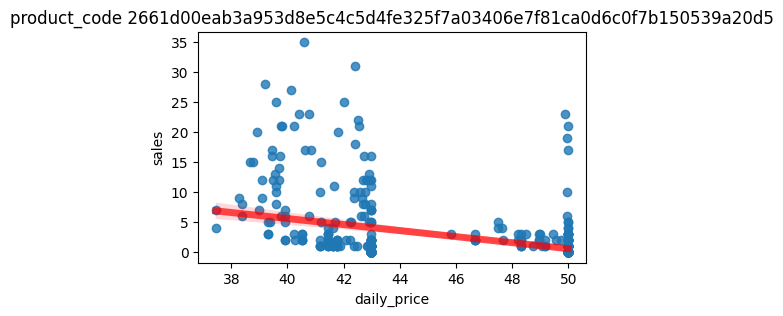

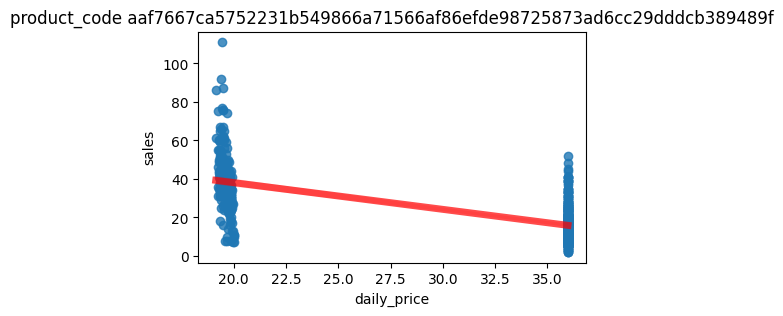

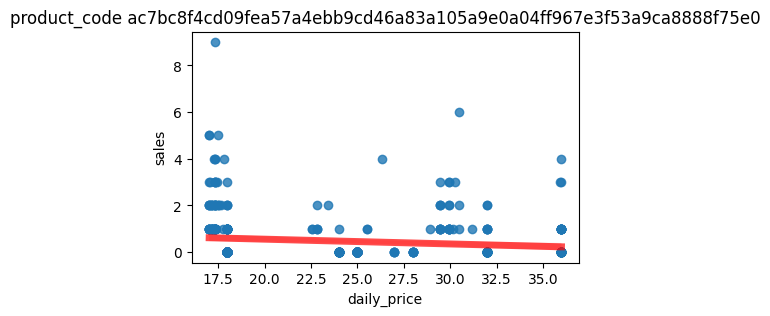

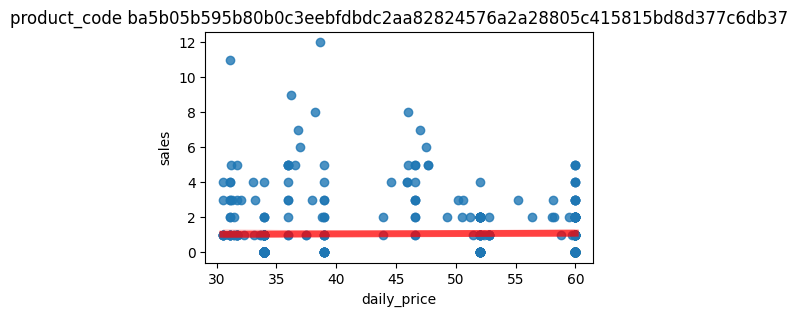

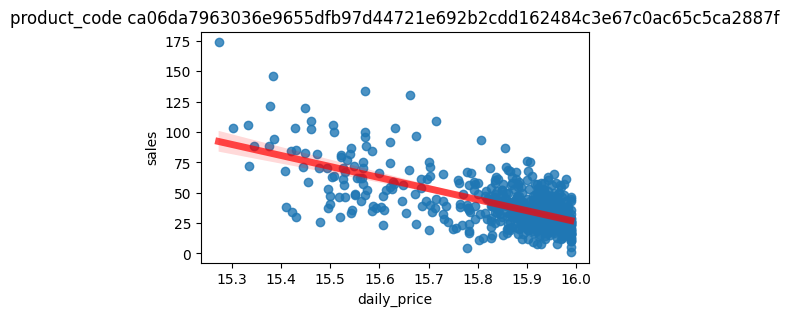

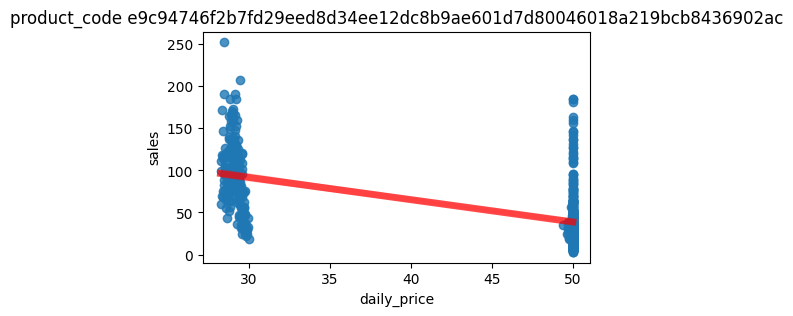

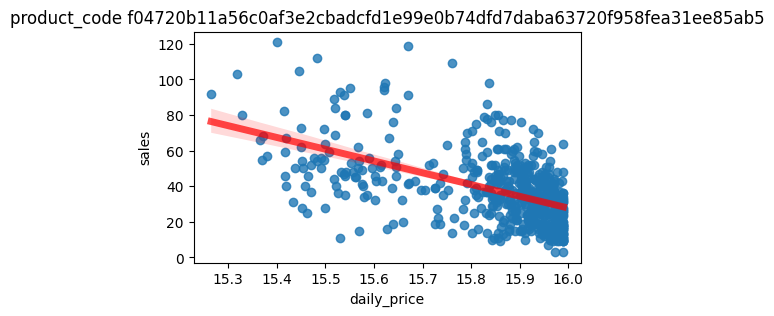

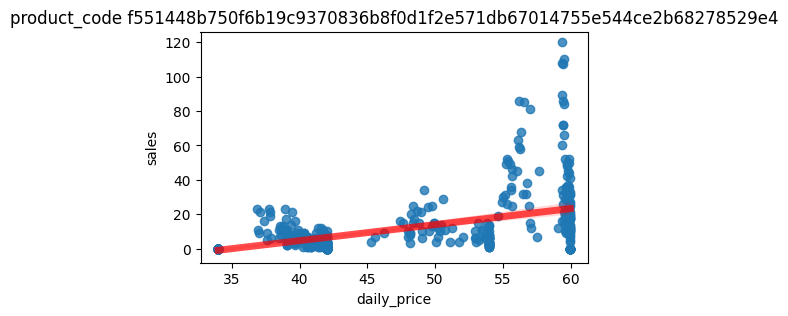

In [20]:
import seaborn as sns
unique_style_group = df.style_group.unique()
price = df.groupby(['style_group','transaction_date'],as_index=False).agg({'final_price':['mean'], 'units_sold':['sum']})
price.columns = ['_'.join(x) for x in price.columns.ravel()]
for i in unique_style_group:
    temp = price[price.product_code_ == i][['final_price_mean','units_sold_sum']]
# df_price_cross = df_price_cross.rename(columns = style)
    fig.set_size_inches(5,3)
    sns.regplot(x=temp.final_price_mean, y=temp.units_sold_sum, line_kws={"color":"r","alpha":0.7,"lw":5})
    plt.title(f'product_code {i}')
    plt.xlabel("daily_price")
    plt.ylabel("sales")
    plt.show()


- This plots show there is inverse relationship between price and sales except for style group f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4
- These negative relationship(Price elasticities of demand) are intuitive as price and quantity demanded mostly move in opposite directions

### Implementation

- I use here simple beta regression model to estimate the price elasticity of demand for different hierarchy level(style_group,level4,level3 etc.)
- I tried to estimate both price elasticity and cross price elasticity of demand.
- Disclaimer- Due to time contraint,I merely implement the concept with out much rigor to have an accurate estimation.



#### Data preparation

![Screenshot from 2023-10-26 19-58-52.png](<attachment:Screenshot from 2023-10-26 19-58-52.png>)
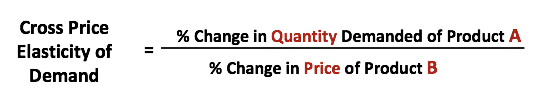

- Based on the above, we need to transform the data from long to wide format to have price of all style_group as features and sales as target variable for each date
- Then for each style_group we can fit a beta regression model to estimate the price elasticity and cross price elasticity of demand

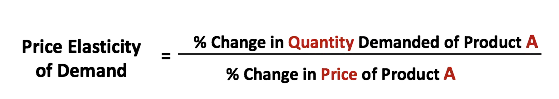

In [68]:
f = pd.read_csv('../data/transaction_grid.csv')
df['l3_l4'] = df['level3'] + '_' + df['level4']
df['holiday_flag'] = df['transaction_date'].apply(lambda x: 0 if holidays.DE().get(x) is None else 1)
df['month'] = df['transaction_date'].dt.month
price_sensitivity_holiday = pd.DataFrame(df.groupby(['l3_l4','holiday_flag']).agg({'units_sold':['max','min','mean']\
    ,'final_price':['mean'],'season_start_date':['max'],'season_end_date':['max']})).reset_index()
price_sensitivity_holiday   

l3_l4 holiday_flag units_sold                final_price  \
                                              max min       mean        mean   
0   T-shirts_long-sleeved            0         60   0   6.359854   28.395231   
1   T-shirts_long-sleeved            1         25   0   6.931034   28.489483   
2  T-shirts_short-sleeved            0         75   0   9.677253   15.849682   
3  T-shirts_short-sleeved            1         37   0  12.347458   15.799915   
4           Trousers_long            0        105   0  11.776970   44.158264   
5           Trousers_long            1         63   0  13.494253   44.625517   
6          Trousers_short            0         15   0   1.024103   44.895970   
7          Trousers_short            1          5   0   0.375000   48.313958   

  season_start_date season_end_date  
                max             max  
0        2022-06-01      2023-07-14  
1        2022-06-01      2023-07-14  
2        2022-06-01      2023-07-14  
3        2022-06-01      2023-07-14  
4        2022-05-09      2023-03-03  
5        2022-05-09      2023-03-03  
6        2022-04-04      2023-06-02  
7        2022-04-04      2023-06-02

In [57]:
# df['holiday_flag'] = df['transaction_date'].apply(lambda x: 0 if holidays.DE().get(x) is None else 1)
#convert to month name
import calendar
df['month'] = df['transaction_date'].dt.month
price_sensitivity_month = pd.DataFrame(df.groupby(['l3_l4','month']).agg({'units_sold':['max','min','mean']\
    ,'final_price':['mean']})).reset_index()
price_sensitivity_month.columns = ['_'.join(x) for x in price_sensitivity_month.columns.ravel()]
#sort it with l3_l4 and month
price_sensitivity_month = price_sensitivity_month.sort_values(by=['l3_l4_','month_'])
price_sensitivity_month['month_'] = price_sensitivity_month['month_'].apply(lambda x: calendar.month_abbr[x])

l3_l4_ month_  units_sold_max  units_sold_min  \
0    T-shirts_long-sleeved    Jan             111               0   
1    T-shirts_long-sleeved    Feb              67               0   
2    T-shirts_long-sleeved    Mar              67               0   
3    T-shirts_long-sleeved    Apr              87               0   
4    T-shirts_long-sleeved    May              77               0   
5    T-shirts_long-sleeved    Jun              54               0   
6    T-shirts_long-sleeved    Jul              55               0   
7    T-shirts_long-sleeved    Aug              26               0   
8    T-shirts_long-sleeved    Sep              38               0   
9    T-shirts_long-sleeved    Oct              48               0   
10   T-shirts_long-sleeved    Nov              41               0   
11   T-shirts_long-sleeved    Dec              31               0   
12  T-shirts_short-sleeved    Jan              68               9   
13  T-shirts_short-sleeved    Feb             134               9   
14  T-shirts_short-sleeved    Mar             109              15   
15  T-shirts_short-sleeved    Apr             105              15   
16  T-shirts_short-sleeved    May             130              18   
17  T-shirts_short-sleeved    Jun              93              19   
18  T-shirts_short-sleeved    Jul             112               4   
19  T-shirts_short-sleeved    Aug              64              15   
20  T-shirts_short-sleeved    Sep              95              15   
21  T-shirts_short-sleeved    Oct             106               9   
22  T-shirts_short-sleeved    Nov             174               3   
23  T-shirts_short-sleeved    Dec              46               1   
24           Trousers_long    Jan             153               0   
25           Trousers_long    Feb             252               0   
26           Trousers_long    Mar             185               0   
27           Trousers_long    Apr             190               0   
28           Trousers_long    May             185               0   
29           Trousers_long    Jun             116               0   
30           Trousers_long    Jul             102               0   
31           Trousers_long    Aug              39               1   
32           Trousers_long    Sep              70               2   
33           Trousers_long    Oct              62               0   
34           Trousers_long    Nov              78               0   
35           Trousers_long    Dec              47               0   
36          Trousers_short    Jan               6               0   
37          Trousers_short    Feb               5               0   
38          Trousers_short    Mar              11               0   
39          Trousers_short    Apr               4               0   
40          Trousers_short    May               5               0   
41          Trousers_short    Jun              35               0   
42          Trousers_short    Jul              28               0   
43          Trousers_short    Aug              20               0   
44          Trousers_short    Sep               8               0   
45          Trousers_short    Oct               3               0   
46          Trousers_short    Nov               5               0   
47          Trousers_short    Dec               2               0   

    units_sold_mean  final_price_mean  
0         18.526882         24.477455  
1         15.666667         26.539085  
2         15.298387         28.966667  
3         17.208333         28.642194  
4         14.750000         28.028978  
5         11.275000         26.857806  
6          9.346774         25.906828  
7          8.129032         26.840000  
8         11.766667         26.849500  
9          9.854839         26.864032  
10         9.333333         26.791167  
11         4.935484         25.912151  
12        26.129032         15.928414  
13        35.625000         15.855625  
14        48.629032         15.786452 

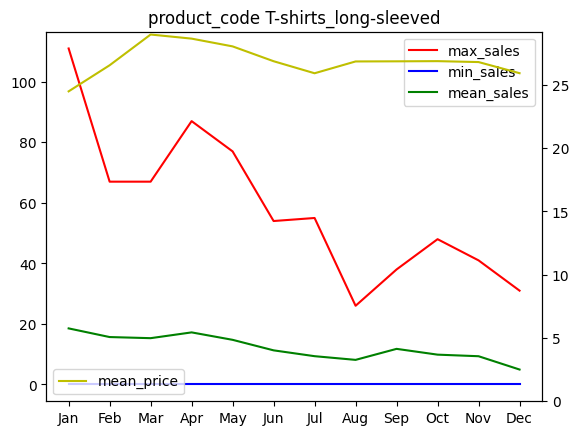

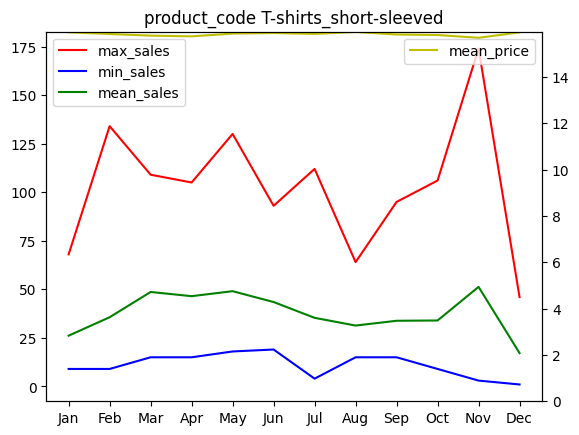

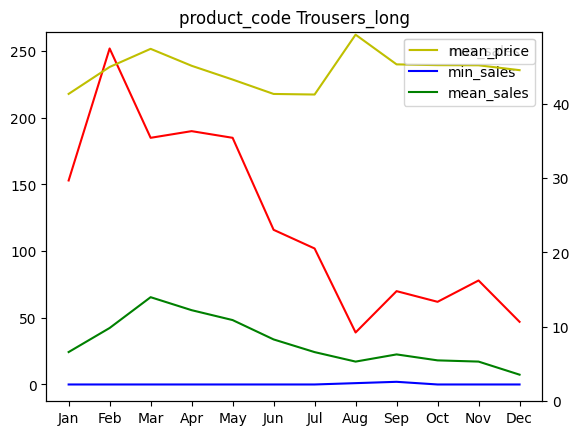

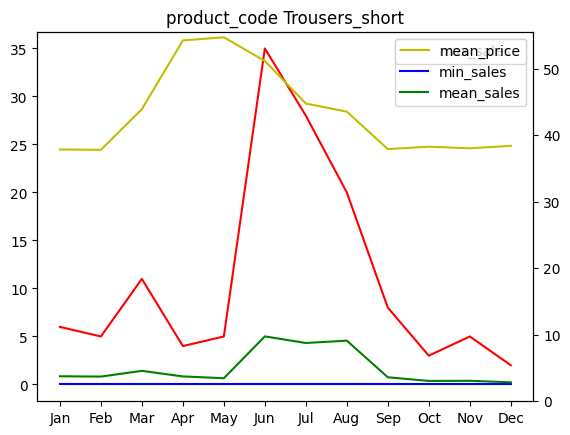

In [82]:
for i in unique_l3_l4:
    temp = price_sensitivity_month[price_sensitivity_month.l3_l4_ == i][['final_price_mean','month_','units_sold_mean','units_sold_max', 'units_sold_min']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.month_,temp.units_sold_max,'r',label='max_sales')
    plt.plot(temp.month_,temp.units_sold_min,'b',label='min_sales')
    plt.plot(temp.month_,temp.units_sold_mean,'g',label='mean_sales')
    plt.legend()
    #second y axis for price
    ax2 = plt.twinx()
    ax2.plot(temp.month_,temp.final_price_mean,'y',label='mean_price')
    
    plt.legend()
    #regression plot with confidence interval    
    plt.title(f'product_code {i}')
    plt.legend()
    plt.xlabel("month")
    #remove negative from y axis
    plt.ylim(bottom=0)
    
    plt.show()

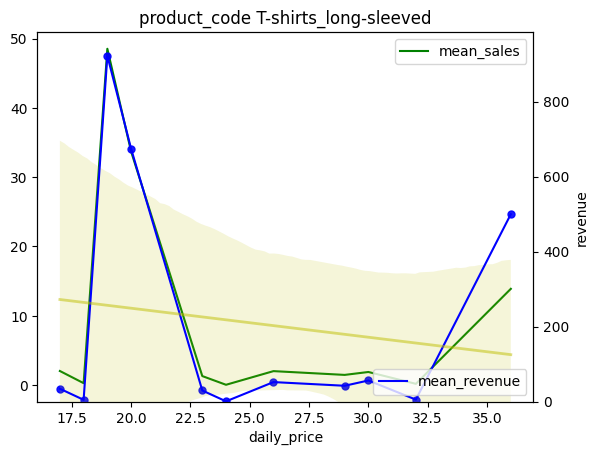


relationship with price: -29.21


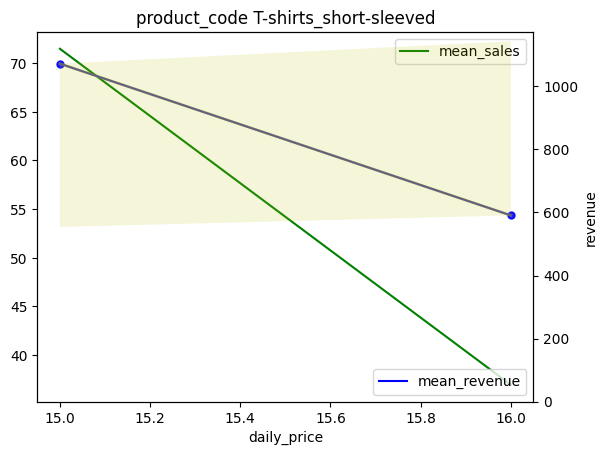


relationship with price: -100.0


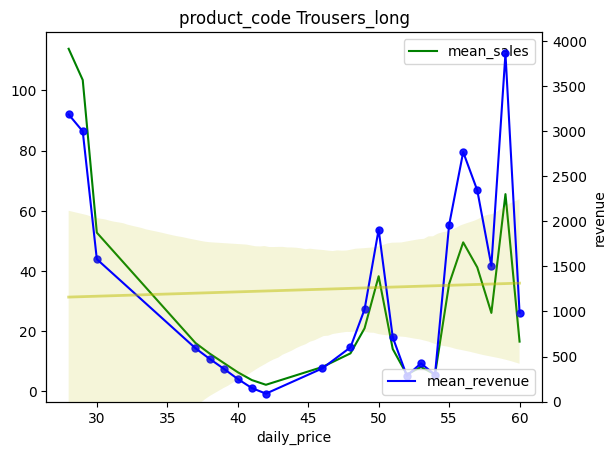


relationship with price: -34.85


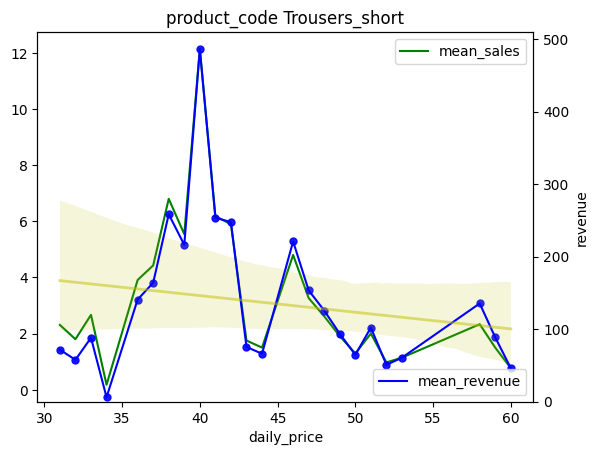


relationship with price: -32.44


In [93]:
price_sensitivity['revenue'] = price_sensitivity['final_price_round_'] * price_sensitivity['units_sold_mean']
for i in unique_l3_l4:
    temp = price_sensitivity[price_sensitivity.l3_l4_ == i][['final_price_round_','units_sold_max','units_sold_min','units_sold_mean','revenue']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.final_price_round_,temp.units_sold_mean,'g',label='mean_sales')
    plt.legend()
    plt.xlabel("daily_price")
    ax2 = plt.twinx()
    ax2.plot(temp.final_price_round_,temp.revenue,'b',label='mean_revenue')

    #regression plot with confidence interval
    sns.regplot(x=temp.final_price_round_, y=temp.revenue, line_kws={"color":"y","alpha":0.5,"lw":2},ci=95,\
        scatter_kws={"color":"b","alpha":0.9,"s":100},marker='.')    
    plt.title(f'product_code {i}')
    #put the legend in bottom right
    plt.legend(loc='lower right')
    
    #remove negative from y axis
    plt.ylim(bottom=0)
    plt.show()
    #print the correlation coefficient
    cor = round(np.corrcoef(temp.final_price_round_,temp.units_sold_mean)[0][1] * 100,2)
    #print the correlation coefficient red if negative and green if positive
    if cor < 0:
        print('')
        print('relationship with price:',colored(cor,'green'))
    else:
        print('relationship with price:',colored(cor,'red'))

#### Price and revenue moves in same direction
#### so the price maximising the sales is same as price maximising the revenue
#### But it should depend on the month/season as well

#### Seasonal price recommendation

- Dynamic pricing

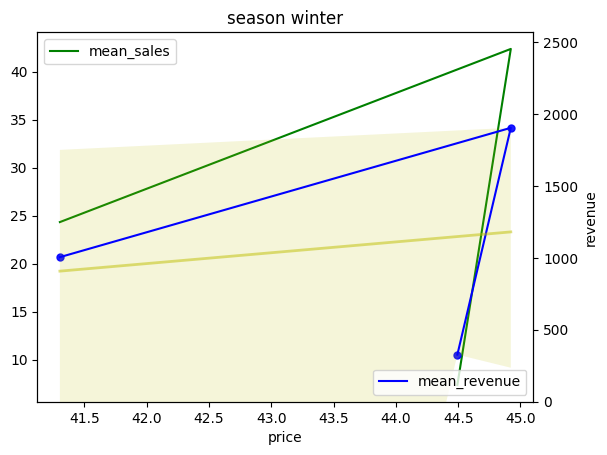

relationship with price: 12.6


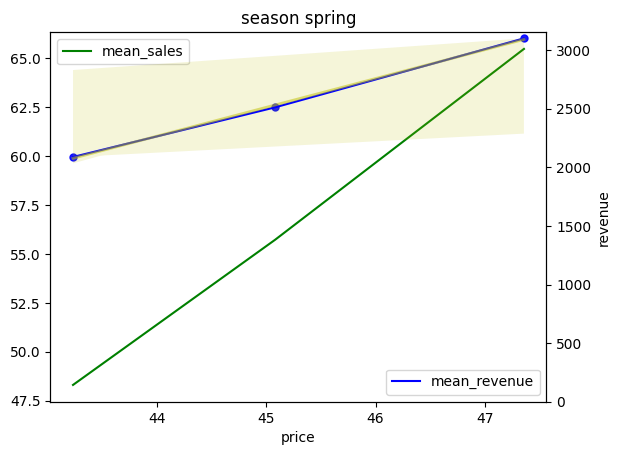

relationship with price: 99.98


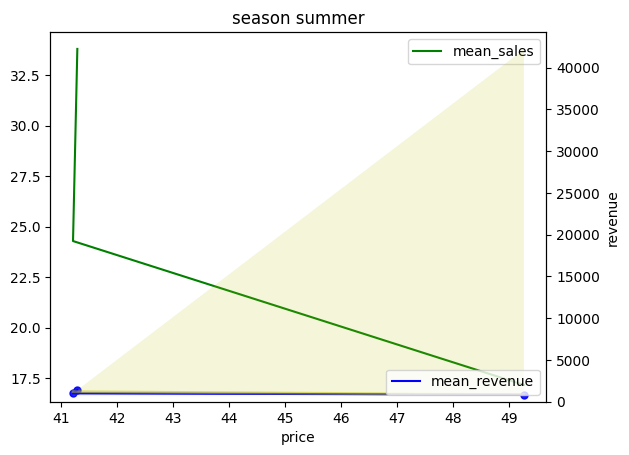


relationship with price: -81.7


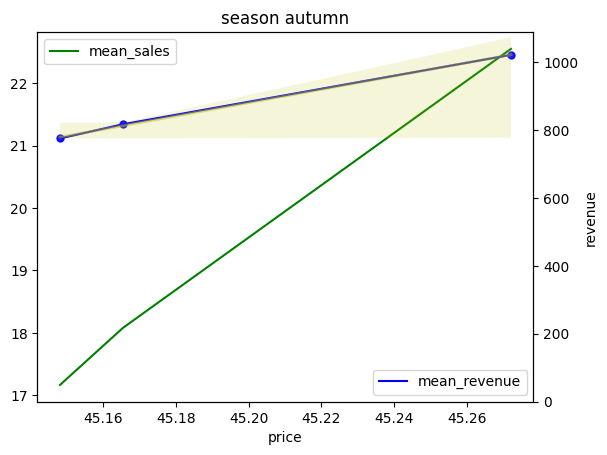

relationship with price: 99.95


In [112]:
trousers_long = price_sensitivity_month[price_sensitivity_month.l3_l4_ == 'Trousers_long'][['final_price_mean','month_','units_sold_mean','units_sold_max', 'units_sold_min','revenue']]
unique_month = trousers_long.month_.unique()

#make it season with grouping months into season
season = {'spring':['Mar','Apr','May'],'summer':['Jun','Jul','Aug'],'autumn':['Sep','Oct','Nov'],'winter':['Dec','Jan','Feb']}
#apply this season to month column
trousers_long['season'] = trousers_long['month_'].apply(lambda x: [k for k,v in season.items() if x in v][0])
unique_season = trousers_long.season.unique()
price_sensitivity_month['revenue'] = price_sensitivity_month['final_price_mean'] * price_sensitivity_month['units_sold_mean']
for i in unique_season:
    temp = trousers_long[trousers_long.season == i][['revenue',
       'units_sold_mean', 'final_price_mean']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.final_price_mean,temp.units_sold_mean,'g',label='mean_sales')
    plt.legend()
    plt.xlabel("price")
    ax2 = plt.twinx()
    ax2.plot(temp.final_price_mean,temp.revenue,'b',label='mean_revenue')

    #regression plot with confidence interval
    sns.regplot(x=temp.final_price_mean, y=temp.revenue, line_kws={"color":"y","alpha":0.5,"lw":2},ci=95,\
        scatter_kws={"color":"b","alpha":0.9,"s":100},marker='.')    
    plt.title(f'season {i}')
    #put the legend in bottom right
    plt.legend(loc='lower right')
    
    #remove negative from y axis
    plt.ylim(bottom=0)
    plt.show()
    #print the correlation coefficient
    cor = round(np.corrcoef(temp.final_price_mean,temp.units_sold_mean)[0][1] * 100,2)
    #print the correlation coefficient red if negative and green if positive
    if cor < 0:
        print('')
        print('relationship with price:',colored(cor,'green'))
    else:
        print('relationship with price:',colored(cor,'red'))

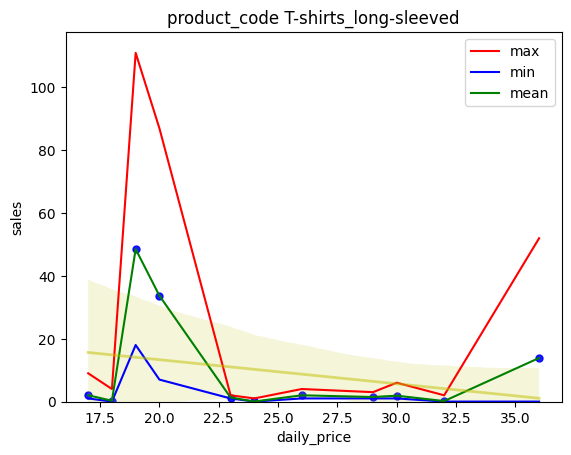


relationship with price: -29.21


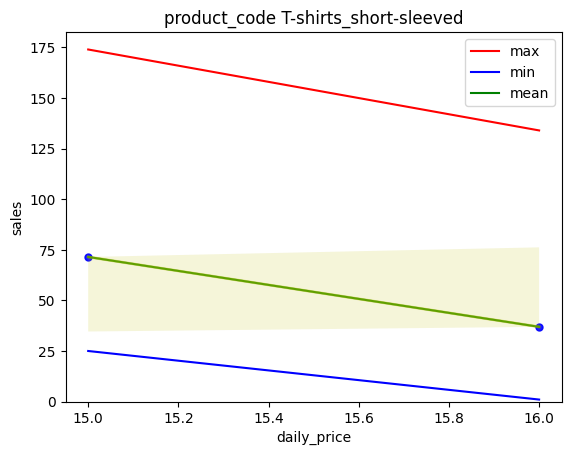


relationship with price: -100.0


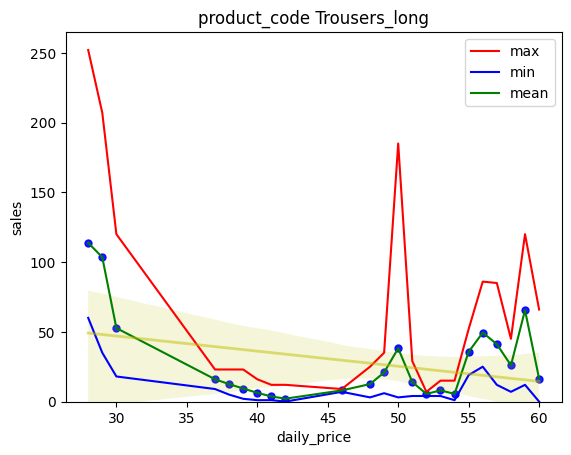


relationship with price: -34.85


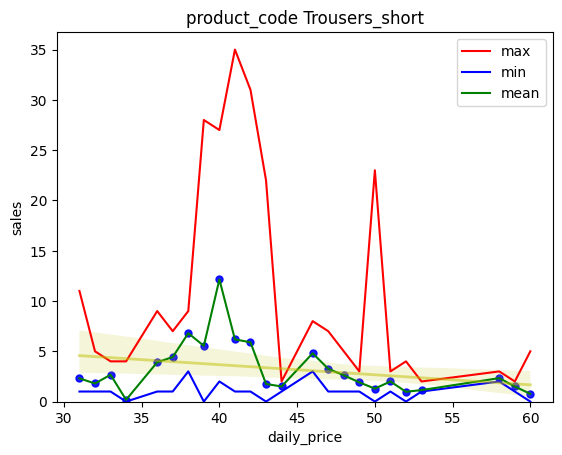


relationship with price: -32.44


In [47]:

import seaborn as sns
df['final_price_round'] = np.round(df['final_price']).astype(int)
price_sensitivity = pd.DataFrame(df.groupby(['l3_l4','final_price_round']).agg({'units_sold':['max','min','std','mean']})).reset_index()
price_sensitivity = price_sensitivity[(price_sensitivity['units_sold']['std'] > 0)]
price_sensitivity.columns = ['_'.join(x) for x in price_sensitivity.columns.ravel()]
unique_style_group = df.style_group.unique()
unique_l3_l4 = df.l3_l4.unique()
for i in unique_l3_l4:
    temp = price_sensitivity[price_sensitivity.l3_l4_ == i][['final_price_round_','units_sold_max','units_sold_min','units_sold_mean']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.final_price_round_,temp.units_sold_max,'r',label='max')
    plt.plot(temp.final_price_round_,temp.units_sold_min,'b',label='min')
    plt.plot(temp.final_price_round_,temp.units_sold_mean,'g',label='mean')

    #regression plot with confidence interval
    sns.regplot(x=temp.final_price_round_, y=temp.units_sold_mean, line_kws={"color":"y","alpha":0.5,"lw":2},ci=95,\
        scatter_kws={"color":"b","alpha":0.9,"s":100},marker='.')    
    plt.title(f'product_code {i}')
    plt.legend()
    plt.xlabel("daily_price")
    #remove negative from y axis
    plt.ylim(bottom=0)
    plt.ylabel("sales")
    plt.show()
    #print the correlation coefficient
    cor = round(np.corrcoef(temp.final_price_round_,temp.units_sold_mean)[0][1] * 100,2)
    #print the correlation coefficient red if negative and green if positive
    if cor < 0:
        print('')
        print('relationship with price:',colored(cor,'green'))
    else:
        print('relationship with price:',colored(cor,'red'))

##### style_group level   

In [126]:

#to avoid long style_group names
style = {}
for i,style_group in enumerate(unique_style_group):
    style[style_group] = f'style_{i+1}'

df_price = df[['style_group', 'transaction_date','sales_price','units_sold','level3','level4']]
df_price = df_price['style_group'].map(style).to_frame().join(df_price.drop('style_group', axis=1))
df_price['l3_l4'] = df_price['level3'] + '_' + df_price['level4']
df_price_cross = df_price.pivot(index='transaction_date', columns='style_group', values=['sales_price','units_sold'])

df_price_cross.columns = ['_'.join(x) for x in df_price_cross.columns.ravel()]
df_price_cross.head()

##### Individual OLS model to estimate price elasticity and cross-price elasticity 

In [128]:
import statsmodels.api as sm

for i in list(style.values()):
    #keep all price related columns
    print(f'for style_group {i}')
    style_df = pd.concat([df_price_cross.iloc[:,0:8], df_price_cross[f'units_sold_{i}']], axis=1).dropna()
    model = sm.OLS(style_df[f'units_sold_{i}'],style_df.drop([f'units_sold_{i}'],axis=1),missing='drop')
    result = model.fit()
    results_summary = result.summary()
    display(results_summary)

for style_group style_1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_1   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     60.93
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           1.79e-48
Time:                        16:42:44   Log-Likelihood:                -1319.5
No. Observations:                 458   AIC:                             2651.
Df Residuals:                     452   BIC:                             2676.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1    -1.7900      0.221     -8.110      0.000      -2.224      -1.356
sales_price_style_2    -0.2852      0.044     -6.519      0.000      -0.371      -0.199
sales_price_style_3     0.5088      0.148      3.442      0.001       0.218       0.799
sales_price_style_4     0.3372      0.027     12.647      0.000       0.285       0.390
sales_price_style_5     1.9218      0.273      7.052      0.000       1.386       2.457
sales_price_style_6     0.2447      0.037      6.549      0.000       0.171       0.318
sales_price_style_7    -0.1130      0.060     -1.868      0.062      -0.232       0.006
sales_price_style_8     1.9218      0.273      7.052      0.000       1.386       2.457
==============================================================================
Omnibus:                      219.167   Durbin-Watson:                   0.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              990.983
Skew:                           2.152   Prob(JB):                    6.47e-216
Kurtosis:                       8.780   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_2   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     83.97
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           2.89e-62
Time:                        16:42:44   Log-Likelihood:                -1795.4
No. Observations:                 458   AIC:                             3603.
Df Residuals:                     452   BIC:                             3628.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1    -1.0371      0.624     -1.663      0.097      -2.263       0.189
sales_price_style_2    -1.1639      0.124     -9.411      0.000      -1.407      -0.921
sales_price_style_3    -0.1639      0.418     -0.392      0.695      -0.985       0.657
sales_price_style_4     0.3128      0.075      4.150      0.000       0.165       0.461
sales_price_style_5     3.5564      0.770      4.618      0.000       2.043       5.070
sales_price_style_6    -0.3422      0.106     -3.240      0.001      -0.550      -0.135
sales_price_style_7    -0.0731      0.171     -0.427      0.669      -0.409       0.263
sales_price_style_8     3.5564      0.770      4.618      0.000       2.043       5.070
==============================================================================
Omnibus:                      121.951   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              379.951
Skew:                           1.228   Prob(JB):                     3.12e-83
Kurtosis:                       6.725   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_3


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_3   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     17.39
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           9.31e-16
Time:                        16:42:44   Log-Likelihood:                -574.00
No. Observations:                 458   AIC:                             1160.
Df Residuals:                     452   BIC:                             1185.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1     0.0195      0.043      0.449      0.653      -0.066       0.105
sales_price_style_2     0.0179      0.009      2.080      0.038       0.001       0.035
sales_price_style_3    -0.0186      0.029     -0.641      0.522      -0.076       0.038
sales_price_style_4    -0.0141      0.005     -2.693      0.007      -0.024      -0.004
sales_price_style_5    -0.0168      0.054     -0.314      0.754      -0.122       0.088
sales_price_style_6     0.0171      0.007      2.329      0.020       0.003       0.032
sales_price_style_7    -0.0022      0.012     -0.182      0.856      -0.025       0.021
sales_price_style_8    -0.0168      0.054     -0.314      0.754      -0.122       0.088
==============================================================================
Omnibus:                      390.084   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10402.445
Skew:                           3.547   Prob(JB):                         0.00
Kurtosis:                      25.244   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_4   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9118
Date:                Thu, 26 Oct 2023   Prob (F-statistic):              0.473
Time:                        16:42:44   Log-Likelihood:                -884.88
No. Observations:                 458   AIC:                             1782.
Df Residuals:                     452   BIC:                             1807.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1    -0.0041      0.085     -0.048      0.961      -0.172       0.164
sales_price_style_2    -0.0082      0.017     -0.486      0.627      -0.042       0.025
sales_price_style_3     0.0120      0.057      0.209      0.834      -0.100       0.124
sales_price_style_4     0.0087      0.010      0.843      0.400      -0.012       0.029
sales_price_style_5     0.0297      0.105      0.282      0.778      -0.178       0.237
sales_price_style_6    -0.0010      0.014     -0.069      0.945      -0.029       0.027
sales_price_style_7    -0.0023      0.023     -0.098      0.922      -0.048       0.044
sales_price_style_8     0.0297      0.105      0.282      0.778      -0.178       0.237
==============================================================================
Omnibus:                      268.739   Durbin-Watson:                   1.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1952.497
Skew:                           2.524   Prob(JB):                         0.00
Kurtosis:                      11.765   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_5   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     8.945
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           4.08e-08
Time:                        16:42:44   Log-Likelihood:                -2038.9
No. Observations:                 458   AIC:                             4090.
Df Residuals:                     452   BIC:                             4115.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1    -4.2200      1.062     -3.975      0.000      -6.306      -2.134
sales_price_style_2    -1.1290      0.210     -5.365      0.000      -1.543      -0.715
sales_price_style_3     2.5204      0.711      3.545      0.000       1.123       3.917
sales_price_style_4     0.5145      0.128      4.012      0.000       0.262       0.767
sales_price_style_5     6.3938      1.311      4.878      0.000       3.818       8.970
sales_price_style_6     0.5890      0.180      3.278      0.001       0.236       0.942
sales_price_style_7    -0.9673      0.291     -3.325      0.001      -1.539      -0.396
sales_price_style_8     6.3938      1.311      4.878      0.000       3.818       8.970
==============================================================================
Omnibus:                      247.132   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1781.504
Skew:                           2.262   Prob(JB):                         0.00
Kurtosis:                      11.538   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_6   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     129.1
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           1.02e-84
Time:                        16:42:44   Log-Likelihood:                -2163.8
No. Observations:                 458   AIC:                             4340.
Df Residuals:                     452   BIC:                             4364.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1    -1.9134      1.394     -1.372      0.171      -4.654       0.827
sales_price_style_2    -2.4923      0.276     -9.016      0.000      -3.036      -1.949
sales_price_style_3     0.5493      0.934      0.588      0.557      -1.286       2.384
sales_price_style_4     1.2300      0.168      7.301      0.000       0.899       1.561
sales_price_style_5     6.7102      1.722      3.898      0.000       3.327      10.093
sales_price_style_6    -1.0161      0.236     -4.305      0.000      -1.480      -0.552
sales_price_style_7    -0.4849      0.382     -1.269      0.205      -1.236       0.266
sales_price_style_8     6.7102      1.722      3.898      0.000       3.327      10.093
==============================================================================
Omnibus:                      113.532   Durbin-Watson:                   0.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.172
Skew:                           1.067   Prob(JB):                     3.19e-95
Kurtosis:                       7.272   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_7   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     24.83
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           4.00e-22
Time:                        16:42:44   Log-Likelihood:                -1947.5
No. Observations:                 458   AIC:                             3907.
Df Residuals:                     452   BIC:                             3932.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1    -2.1689      0.870     -2.494      0.013      -3.878      -0.460
sales_price_style_2    -0.5706      0.172     -3.310      0.001      -0.909      -0.232
sales_price_style_3     1.4121      0.582      2.425      0.016       0.268       2.557
sales_price_style_4     0.7757      0.105      7.383      0.000       0.569       0.982
sales_price_style_5     3.1251      1.074      2.911      0.004       1.015       5.235
sales_price_style_6     0.2644      0.147      1.796      0.073      -0.025       0.554
sales_price_style_7    -0.5204      0.238     -2.184      0.029      -0.989      -0.052
sales_price_style_8     3.1251      1.074      2.911      0.004       1.015       5.235
==============================================================================
Omnibus:                      160.983   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              537.904
Skew:                           1.621   Prob(JB):                    1.57e-117
Kurtosis:                       7.204   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

for style_group style_8


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     units_sold_style_8   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     82.06
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           3.40e-61
Time:                        16:42:44   Log-Likelihood:                -1353.2
No. Observations:                 458   AIC:                             2718.
Df Residuals:                     452   BIC:                             2743.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sales_price_style_1     0.5651      0.238      2.379      0.018       0.098       1.032
sales_price_style_2     0.3886      0.047      8.253      0.000       0.296       0.481
sales_price_style_3    -0.1304      0.159     -0.820      0.413      -0.443       0.182
sales_price_style_4    -0.0106      0.029     -0.369      0.712      -0.067       0.046
sales_price_style_5    -1.2872      0.293     -4.389      0.000      -1.864      -0.711
sales_price_style_6     0.0831      0.040      2.066      0.039       0.004       0.162
sales_price_style_7     0.2031      0.065      3.121      0.002       0.075       0.331
sales_price_style_8    -1.2872      0.293     -4.389      0.000      -1.864      -0.711
==============================================================================
Omnibus:                      123.752   Durbin-Watson:                   1.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.627
Skew:                           1.327   Prob(JB):                     3.92e-70
Kurtosis:                       6.115   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

##### These co-efficients provides us the price and cross price elasticity for each style_group

- For most of the style group we see negative price elasticity(co-efficient value own style) which is expected
- For cross price elasticity we see mix of positive values and negative values which is expected as some style_group are complements and some are substitutes
- Based on these co-efficients we can also simulate/estimate unit_sold(sales) for a given price level for each style_group

- We can have the estimate the elasticity at level4 level

In [165]:
### 

df_price = df[['style_group', 'transaction_date','final_price','units_sold','level3','level4']]
# df_price = df_price['style_group'].map(style).to_frame().join(df_price.drop('style_group', axis=1))
df_price['l3_l4'] = df_price['level3'] + '_' + df_price['level4']
df_price = df_price[['l3_l4','transaction_date','final_price','units_sold']].groupby(['l3_l4','transaction_date'],as_index=False).agg({'final_price':'mean','units_sold':'sum'})
df_price_cross = df_price.pivot(index='transaction_date', columns='l3_l4', values=['final_price','units_sold'])

df_price_cross.columns = ['_'.join(x) for x in df_price_cross.columns.ravel()]
df_price_cross.head()

In [169]:
unique_l3_l4 = df_price['l3_l4'].unique()
for i in unique_l3_l4:
    #keep all price related columns
    print(f'for style_group {i}')
    style_df = pd.concat([df_price_cross.iloc[:,0:4], df_price_cross[f'units_sold_{i}']], axis=1)
    model = sm.OLS(np.log1p(style_df[f'units_sold_{i}']),style_df.drop([f'units_sold_{i}'],axis=1),missing='drop')
    result = model.fit()
    results_summary = result.summary()
    display(results_summary)

for style_group T-shirts_long-sleeved


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     units_sold_T-shirts_long-sleeved   R-squared (uncentered):                   0.973
Model:                                          OLS   Adj. R-squared (uncentered):              0.973
Method:                               Least Squares   F-statistic:                              4094.
Date:                              Thu, 26 Oct 2023   Prob (F-statistic):                        0.00
Time:                                      17:36:10   Log-Likelihood:                         -354.56
No. Observations:                               458   AIC:                                      717.1
Df Residuals:                                   454   BIC:                                      733.6
Df Model:                                         4                                                  
Covariance Type:                          nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
final_price_T-shirts_long-sleeved     -0.0765      0.016     -4.747      0.000      -0.108      -0.045
final_price_T-shirts_short-sleeved     0.2769      0.013     21.355      0.000       0.251       0.302
final_price_Trousers_long             -0.0125      0.008     -1.499      0.135      -0.029       0.004
final_price_Trousers_short             0.0269      0.005      5.847      0.000       0.018       0.036
==============================================================================
Omnibus:                       16.461   Durbin-Watson:                   0.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.158
Skew:                          -0.405   Prob(JB):                     0.000114
Kurtosis:                       3.543   Cond. No.                         53.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

for style_group T-shirts_short-sleeved


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                        
======================================================================================================
Dep. Variable:     units_sold_T-shirts_short-sleeved   R-squared (uncentered):                   0.573
Model:                                           OLS   Adj. R-squared (uncentered):              0.569
Method:                                Least Squares   F-statistic:                              152.4
Date:                               Thu, 26 Oct 2023   Prob (F-statistic):                    1.57e-82
Time:                                       17:36:10   Log-Likelihood:                         -626.84
No. Observations:                                458   AIC:                                      1262.
Df Residuals:                                    454   BIC:                                      1278.
Df Model:                                          4                                                  
Covariance Type:                           nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
final_price_T-shirts_long-sleeved     -0.0928      0.029     -3.175      0.002      -0.150      -0.035
final_price_T-shirts_short-sleeved    -0.0447      0.023     -1.904      0.058      -0.091       0.001
final_price_Trousers_long              0.0643      0.015      4.243      0.000       0.035       0.094
final_price_Trousers_short             0.0323      0.008      3.876      0.000       0.016       0.049
==============================================================================
Omnibus:                       32.125   Durbin-Watson:                   0.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.153
Skew:                           0.442   Prob(JB):                     9.38e-06
Kurtosis:                       2.342   Cond. No.                         53.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

for style_group Trousers_long


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     units_sold_Trousers_long   R-squared (uncentered):                   0.983
Model:                                  OLS   Adj. R-squared (uncentered):              0.983
Method:                       Least Squares   F-statistic:                              6629.
Date:                      Thu, 26 Oct 2023   Prob (F-statistic):                        0.00
Time:                              17:36:10   Log-Likelihood:                         -356.03
No. Observations:                       458   AIC:                                      720.1
Df Residuals:                           454   BIC:                                      736.6
Df Model:                                 4                                                  
Covariance Type:                  nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
final_price_T-shirts_long-sleeved     -0.0587      0.016     -3.631      0.000      -0.091      -0.027
final_price_T-shirts_short-sleeved     0.2331      0.013     17.918      0.000       0.208       0.259
final_price_Trousers_long             -0.0127      0.008     -1.513      0.131      -0.029       0.004
final_price_Trousers_short             0.0520      0.005     11.276      0.000       0.043       0.061
==============================================================================
Omnibus:                       21.445   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.697
Skew:                          -0.449   Prob(JB):                     2.63e-06
Kurtosis:                       3.735   Cond. No.                         53.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

for style_group Trousers_short


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     units_sold_Trousers_short   R-squared (uncentered):                   0.989
Model:                                   OLS   Adj. R-squared (uncentered):              0.989
Method:                        Least Squares   F-statistic:                          1.009e+04
Date:                       Thu, 26 Oct 2023   Prob (F-statistic):                        0.00
Time:                               17:36:10   Log-Likelihood:                         -288.16
No. Observations:                        458   AIC:                                      584.3
Df Residuals:                            454   BIC:                                      600.8
Df Model:                                  4                                                  
Covariance Type:                   nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
final_price_T-shirts_long-sleeved     -0.0044      0.014     -0.313      0.754      -0.032       0.023
final_price_T-shirts_short-sleeved     0.2168      0.011     19.332      0.000       0.195       0.239
final_price_Trousers_long             -0.0046      0.007     -0.636      0.525      -0.019       0.010
final_price_Trousers_short             0.0255      0.004      6.411      0.000       0.018       0.033
==============================================================================
Omnibus:                       36.033   Durbin-Watson:                   0.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.103
Skew:                           0.064   Prob(JB):                     1.27e-34
Kurtosis:                       5.857   Cond. No.                         53.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### While most of the products at level_4 are having negative elasticity, only 'final_price_Trousers_short' is the exception with both elasticity and cross-price elasticity is positive.

- A possible remidy for this to conduct a Bayesian analysis to estimate the price elasticity and cross-price elasticity with prior distribution(eg. Half-Normal distribution) of the co-efficients

- From this co-efficient we can infer the substitutability or complementarity of the products.eg. Trousers_long and short-sleeve_tshirt are complements.

### Improvement and Future work(with more time)

- A) As it's time series other features to be considered like seasonality, trend, promotion etc along with price features.
- B) To estimate the more correct estimation we need to detrend and deseasonalize the data before fitting the model.
- C) Bayesian regression with informed priors distribution of the co-efficients and to have more accurate and intuitive estimation of the price elasticity and cross-price elasticity.
- D) Recommndation of optimum price level on daily/weekly basis.